In [ ]:
!pip install -q pandas numpy scipy scikit-learn ctgan matplotlib seaborn xgboost lightgbm catboost optuna shap imbalanced-learn sdv category_encoders yellowbrick missingno missforest dython optuna plotly tensorflow torch torchvision pytorch-tabnet tabpfn tab-transformer-pytorch tensorflow-gan

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score, LeaveOneOut, learning_curve
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from missforest import MissForest
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import joblib
import pickle
import scipy.stats as stats
import optuna
import warnings
import shap
import category_encoders as ce
from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.features import Rank2D, PCA as PCAViz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dython import nominal
from dython.nominal import associations
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

from ctgan import CTGAN
from pytorch_tabnet.tab_model import TabNetClassifier
from tabpfn import TabPFNClassifier
from tab_transformer_pytorch import TabTransformer



warnings.filterwarnings('ignore')
print("✅ Libraries imported successfully")

class Logger:
    """Utility class for logging pipeline steps"""
    @staticmethod
    def section(name):
        print(f"\n{'='*80}\n{name.upper()}\n{'='*80}")

    @staticmethod
    def subsection(name):
        print(f"\n{'-'*50}\n{name}\n{'-'*50}")

    @staticmethod
    def step(name):
        print(f"▶ {name}")

    @staticmethod
    def result(name, value):
        print(f"  ✓ {name}: {value}")

def plot_correlation_matrix(df, figsize=(20, 16)):
    """Plot correlation matrix with improved visualization"""
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
    plt.title("Correlation Matrix", fontsize=20)
    plt.tight_layout()
    return fig

def plot_missing_values(df):
    """Generate comprehensive missing value visualizations"""
    # Calculate missing values
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_data = pd.DataFrame({
        'Count': missing,
        'Percent': missing_percent
    }).sort_values('Percent', ascending=False)

    # Only show variables with missing values
    missing_data = missing_data[missing_data['Count'] > 0]

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Bar chart
    missing_data['Percent'].plot(kind='bar', ax=axes[0], color='crimson')
    axes[0].set_title('Percentage of Missing Values')
    axes[0].set_ylabel('Percent')
    axes[0].set_ylim([0, 100])

    # Matrix visualization
    if not missing_data.empty:
        msno.matrix(df, ax=axes[1])
    else:
        axes[1].text(0.5, 0.5, "No missing values", ha='center', va='center', fontsize=20)

    plt.tight_layout()
    return fig, missing_data

def evaluate_model(model, X_test, y_test, class_names=['Negative', 'Positive']):
    """Comprehensive model evaluation with visualizations and additional metrics"""
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate standard metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")

    # Classification report with micro, macro, and weighted averages
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve if probabilities are available
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Precision-Recall curve
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(10, 8))
        plt.plot(recall_vals, precision_vals, label=f'PR AUC = {pr_auc:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'mcc': mcc,
        'roc_auc': roc_auc if y_proba is not None else None,
        'pr_auc': pr_auc if y_proba is not None else None,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Improved function to visualize before and after imputation
def plot_before_after_imputation(df_before, df_after, column, kind='hist', figsize=(15, 5)):
    """
    Plot a feature before and after imputation with similar y-axes

    Parameters:
    -----------
    df_before : DataFrame with missing values
    df_after : DataFrame with imputed values
    column : str, column name to plot
    kind : str, plot type ('hist', 'box', 'violin')
    figsize : tuple, figure size
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    if kind == 'hist':
        sns.histplot(df_before[column].dropna(), ax=axes[0], kde=True)
        sns.histplot(df_after[column], ax=axes[1], kde=True)
    elif kind == 'box':
        sns.boxplot(x=df_before[column].dropna(), ax=axes[0])
        sns.boxplot(x=df_after[column], ax=axes[1])
    elif kind == 'violin':
        sns.violinplot(x=df_before[column].dropna(), ax=axes[0])
        sns.violinplot(x=df_after[column], ax=axes[1])

    axes[0].set_title(f'Before ({df_before[column].isna().sum()} missing)')
    axes[1].set_title('After (0 missing)')

    for ax in axes:
        ax.set_xlabel(column)

    plt.tight_layout()
    return fig

def calculate_feature_target_correlation(X, y, method='pearson'):
    """
    Calculate correlation between features and target

    Parameters:
    -----------
    X : DataFrame with features
    y : Series with target
    method : str, correlation method ('pearson', 'spearman', 'kendall')

    Returns:
    --------
    DataFrame with feature-target correlations
    """
    if isinstance(y, pd.Series):
        y_name = y.name
    else:
        y_name = 'target'

    # Combine features and target
    data = pd.concat([X, pd.Series(y, name=y_name)], axis=1)

    # Calculate correlation
    corr_matrix = data.corr(method=method)

    # Get only feature-target correlations
    feature_corr = corr_matrix[y_name].drop(y_name).sort_values(ascending=False)

    return pd.DataFrame({
        'Feature': feature_corr.index,
        'Correlation': feature_corr.values
    })


✅ Libraries imported successfully



DATA LOADING AND INSPECTION
  ✓ Data loaded from: Graduation_project (4).xlsx

--------------------------------------------------
Data Overview
--------------------------------------------------
Dataset shape: (1335, 31)

First 5 rows:


,ID,Age,Menopausal_status,Weight,Height.m.,BMI,pastDM,pastHypertension,pastCardiac,pastLiver,...,chemotherapy,Radiotherapy,Hormanal,Pain,Tenderness,Stiffness,Weakness,Referralpain,Swelling,lymphedema
0,1,45.0,Premenopausal,94.0,1.60,36.718750,no,no,no,no,...,Yes,No,Yes,yes,no,no,no,no,no,yes
1,2,69.0,Postmenopausal,NaN,0.00,NaN,no,yes,yes,no,...,No,No,No,yes,no,no,no,no,no,no
2,3,48.0,Premenopausal,99.0,1.64,36.808447,no,no,no,no,...,No,Yes,Yes,yes,no,no,no,no,no,no
3,4,54.0,Postmenopausal,63.0,1.59,24.919900,no,no,no,no,...,No,No,No,yes,yes,no,no,no,no,no
4,5,44.0,Premenopausal,97.0,1.56,39.858646,no,no,no,no,...,Yes,No,No,yes,no,no,no,no,no,no



Data Types:


,0
ID,int64
Age,float64
Menopausal_status,object
Weight,float64
Height.m.,float64
BMI,float64
pastDM,object
pastHypertension,object
pastCardiac,object
pastLiver,object



Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,1335.0,NaN,NaN,NaN,661.964794,384.108926,1.0,327.5,661.0,994.5,1328.0
Age,1318.0,NaN,NaN,NaN,53.921851,11.797357,23.0,45.0,53.0,63.0,88.0
Menopausal_status,1064,2,Postmenopausal,563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,507.0,NaN,NaN,NaN,79.072781,24.362988,0.0,70.0,79.0,91.0,157.0
Height.m.,1064.0,NaN,NaN,NaN,0.724164,0.7945,0.0,0.0,0.0,1.58,1.76
BMI,536.0,NaN,NaN,NaN,32.680016,6.606672,17.039231,28.22052,32.421875,36.575117,61.028393
pastDM,1335,2,no,1032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pastHypertension,1335,2,no,860,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pastCardiac,1335,2,no,1238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pastLiver,1335,2,no,1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  ✓ Number of duplicates: 4
  ✓ Total missing values: 4461

--------------------------------------------------
Missing Value Analysis
--------------------------------------------------


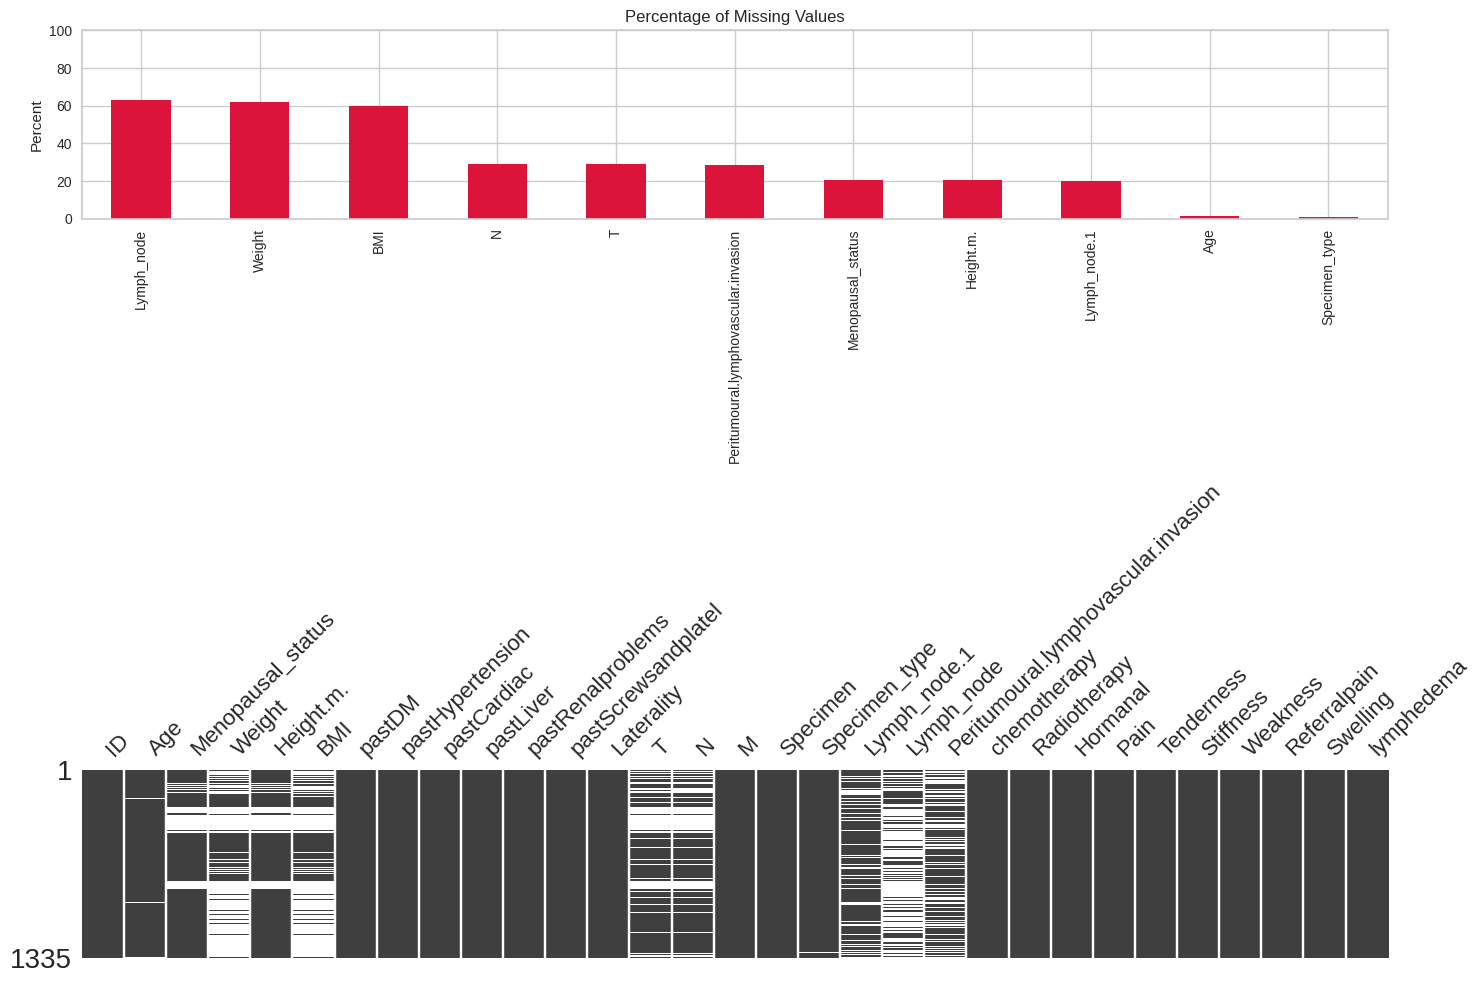

,Count,Percent
Lymph_node,842,63.071161
Weight,828,62.022472
BMI,799,59.850187
N,388,29.063670
T,387,28.988764
Peritumoural.lymphovascular.invasion,379,28.389513
Menopausal_status,271,20.299625
Height.m.,271,20.299625
Lymph_node.1,270,20.224719
Age,17,1.273408


In [ ]:
Logger.section("Data Loading and Inspection")

# Attempt to load the dataset
try:
    # Try different potential file paths
    file_paths = ['Graduation_project (4).xlsx', '/content/Graduation_project (4).xlsx']

    for path in file_paths:
        if os.path.exists(path):
            df = pd.read_excel(path)
            Logger.result("Data loaded from", path)
            break
    else:
        # If no file found, upload it
        from google.colab import files
        uploaded = files.upload()
        df = pd.read_excel(list(uploaded.keys())[0])
        Logger.result("Data loaded from uploaded file", list(uploaded.keys())[0])
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please upload the dataset manually.")

# Basic data exploration
Logger.subsection("Data Overview")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData Types:")
display(df.dtypes)

print("\nSummary Statistics:")
display(df.describe(include='all').T)

# Check for duplicates
duplicate_count = df.duplicated().sum()
Logger.result("Number of duplicates", duplicate_count)

# Check for missing values
missing_count = df.isnull().sum().sum()
Logger.result("Total missing values", missing_count)

# Visualize missing values
if missing_count > 0:
    Logger.subsection("Missing Value Analysis")
    fig, missing_data = plot_missing_values(df)
    plt.show()

    # Display missing value statistics
    if not missing_data.empty:
        display(missing_data)

# Save original dataframe for before/after comparisons
df_original = df.copy()


In [ ]:

Logger.section("Enhanced Interactive Exploratory Data Analysis")

# 1. Data Overview Dashboard
Logger.subsection("Data Overview Dashboard")

# Count types of features
numeric_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()

# Further filter numeric_cols to remove any that contain strings
true_numeric_cols = []
for col in numeric_cols:
    try:
        # This will fail if the column contains strings
        pd.to_numeric(df[col])
        true_numeric_cols.append(col)
    except:
        print(f"Note: Column '{col}' has numeric dtype but contains non-numeric values")

numeric_cols = true_numeric_cols
categorical_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
binary_cols = [col for col in df.columns if df[col].nunique() == 2]

# Print data composition
print(f"Dataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Binary features: {len(binary_cols)}")

# Create a donut chart for feature types
feature_types = {
    'Numeric': len(numeric_cols),
    'Categorical': len(categorical_cols) - len([c for c in categorical_cols if c in binary_cols]),
    'Binary': len(binary_cols)
}

# Create interactive donut chart
fig = go.Figure(data=[go.Pie(
    labels=list(feature_types.keys()),
    values=list(feature_types.values()),
    hole=.4,
    marker_colors=['#74b9ff', '#ff7675', '#55efc4']
)])

fig.update_layout(
    title_text="Feature Type Distribution",
    annotations=[dict(text='Feature<br>Types', x=0.5, y=0.5, font_size=15, showarrow=False)]
)
fig.show()

# 2. Target Variable Analysis (if present)
if 'lymphedema' in df.columns:
    Logger.subsection("Interactive Target Variable Analysis")

    # Handle the target variable which may contain strings like 'yes' and 'no'
    try:
        # First check if it's already numeric
        if pd.api.types.is_numeric_dtype(df['lymphedema']):
            target_values = df['lymphedema']
        else:
            # Try to convert string values like 'yes'/'no' to 1/0
            target_values = df['lymphedema'].map(lambda x:
                1 if str(x).lower() in ['yes', 'true', '1', 't', 'y'] else 0)

        # Count values
        value_counts = target_values.value_counts().sort_index()

        # Create interactive bar chart
        labels = ['No Lymphedema', 'Lymphedema'] if value_counts.index.isin([0, 1]).all() else value_counts.index

        fig = go.Figure(data=[
            go.Bar(
                x=labels,
                y=value_counts.values,
                marker_color=['#74b9ff', '#ff7675'] if len(labels) == 2 else None,
                text=[f"{val} ({val/sum(value_counts.values):.1%})" for val in value_counts.values],
                textposition='auto',
                hoverinfo='y+text',
                hovertemplate='Count: %{y}<br>Percentage: %{text}<extra></extra>'
            )
        ])

        fig.update_layout(
            title='Target Variable Distribution',
            xaxis_title='Lymphedema Status',
            yaxis_title='Count',
            template='plotly_white'
        )

        fig.show()
    except Exception as e:
        print(f"Could not visualize target distribution: {str(e)}")
        print("Target variable appears to contain mixed data types.")



ENHANCED INTERACTIVE EXPLORATORY DATA ANALYSIS

--------------------------------------------------
Data Overview Dashboard
--------------------------------------------------
Dataset dimensions: 1335 rows, 31 columns
Numeric features: 6
Categorical features: 25
Binary features: 19



--------------------------------------------------
Interactive Target Variable Analysis
--------------------------------------------------


In [ ]:

Logger.section("Data Preprocessing - Initial Cleaning")

# Make a copy of the original data
df_original = df.copy()

# Remove duplicates
if duplicate_count > 0:
    df = df.drop_duplicates(keep='first')
    Logger.result("Duplicates removed", duplicate_count)

# Drop unnecessary columns
columns_to_drop = ['ID', 'Weight', 'Height.m.', 'Specimen']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
Logger.result("Unnecessary columns removed", columns_to_drop)

# Display current columns
Logger.result("Remaining columns", df.columns.tolist())

# Check target variable distribution
if 'lymphedema' in df.columns:
    Logger.subsection("Target Variable Distribution")
    target_counts = df['lymphedema'].value_counts()
    target_percent = 100 * df['lymphedema'].value_counts(normalize=True)

    target_stats = pd.DataFrame({
        'Count': target_counts,
        'Percent': target_percent
    })
    display(target_stats)



    # Check class imbalance
    class_ratio = target_counts.min() / target_counts.max()
    Logger.result("Class imbalance ratio (min/max)", f"{class_ratio:.4f}")

    if class_ratio < 0.2:
        print("Warning: Severe class imbalance detected. Will apply specialized techniques.")



DATA PREPROCESSING - INITIAL CLEANING
  ✓ Duplicates removed: 4
  ✓ Unnecessary columns removed: ['ID', 'Weight', 'Height.m.', 'Specimen']
  ✓ Remaining columns: ['Age', 'Menopausal_status', 'BMI', 'pastDM', 'pastHypertension', 'pastCardiac', 'pastLiver', 'pastRenalproblems', 'pastScrewsandplatel', 'Laterality', 'T', 'N', 'M', 'Specimen_type', 'Lymph_node.1', 'Lymph_node', 'Peritumoural.lymphovascular.invasion', 'chemotherapy', 'Radiotherapy', 'Hormanal', 'Pain', 'Tenderness', 'Stiffness', 'Weakness', 'Referralpain', 'Swelling', 'lymphedema']

--------------------------------------------------
Target Variable Distribution
--------------------------------------------------


,Count,Percent
lymphedema,,
no,1104,82.945154
yes,227,17.054846


  ✓ Class imbalance ratio (min/max): 0.2056


In [ ]:

Logger.section("Data Preprocessing - Feature Engineering")

# Function to convert categorical variables to numeric with mapping
def convert_categorical_to_numeric(df):
    # Make a copy to avoid modifying the original
    df_encoded = df.copy()

    # Standard binary mappings
    binary_mappings = {
        'yes': 1, 'no': 0,
        'Yes': 1, 'No': 0,
        'TRUE': 1, 'FALSE': 0,
        'Present': 1, 'Absent': 0,
        'Right': 0, 'Left': 0, 'Bilateral': 1
    }

    # Domain-specific mappings
    special_mappings = {
        'Menopausal_status': {'Premenopausal': 0, 'Postmenopausal': 1},
        'Specimen_type': {'Conservative': 1, 'MRM': 2},
        'T': {'T0': 0, 'Tis': 1, 'T1': 2, 'T2': 3, 'T3': 4, 'T4': 5},
        'N': {'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3},
        'M': {'M0': 0, 'M1': 1},
        'Peritumoural.lymphovascular.invasion': {'Absent': 0, 'suspicious': 1, 'Present': 2},
        'Lymph_node': {'SLNB': 0, 'AxillaryDissection(ALND)': 1, 'AxillaryLymphNodeSampling': 2, 'SLNB&Non-SLNB': 3}
    }

    # Process columns
    for col in df_encoded.columns:
        # Skip numeric columns
        if pd.api.types.is_numeric_dtype(df_encoded[col]):
            continue

        # Apply special mapping if available
        if col in special_mappings:
            df_encoded[col] = df_encoded[col].map(special_mappings[col])
            Logger.result(f"Applied special mapping to", col)
        else:
            # Apply standard binary mappings
            if df_encoded[col].nunique() <= 2:
                # Replace known binary values
                for old_val, new_val in binary_mappings.items():
                    df_encoded[col] = df_encoded[col].replace(old_val, new_val)

                # Check if the column still contains non-numeric values
                if not pd.api.types.is_numeric_dtype(df_encoded[col]):
                    # Create a label encoder for remaining categories
                    unique_vals = df_encoded[col].dropna().unique()
                    if len(unique_vals) == 1:
                        # If only one unique value, set to 1
                        df_encoded[col] = df_encoded[col].fillna(0).map(lambda x: 1 if x == unique_vals[0] else 0)
                    elif len(unique_vals) == 2:
                        # Map to 0 and 1
                        val_map = {unique_vals[0]: 0, unique_vals[1]: 1}
                        df_encoded[col] = df_encoded[col].map(val_map)

                Logger.result(f"Applied binary mapping to", col)
            else:
                # For categorical with >2 categories, use ordinal encoding
                # Get unique non-null values
                unique_vals = df_encoded[col].dropna().unique()
                # Create mapping from sorted unique values to ordinal integers
                val_map = {val: i for i, val in enumerate(sorted(unique_vals))}
                # Apply mapping
                df_encoded[col] = df_encoded[col].map(val_map)
                Logger.result(f"Applied ordinal encoding to", col)

    return df_encoded

# Convert categorical features to numeric
Logger.subsection("Converting Categorical Features")
df_encoded = convert_categorical_to_numeric(df)

# Display data types after conversion
Logger.result("Data types after encoding", df_encoded.dtypes)

# Check for any remaining non-numeric columns
non_numeric_cols = df_encoded.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_cols:
    Logger.result("Remaining non-numeric columns", non_numeric_cols)

    # Apply more advanced encoding techniques to remaining categorical features
    Logger.subsection("Applying Advanced Categorical Encoding")

    for col in non_numeric_cols:
        # Try target encoding for complex categoricals
        if 'lymphedema' in df_encoded.columns:
            # Use target encoding
            encoder = ce.TargetEncoder()
            df_encoded[col] = encoder.fit_transform(df_encoded[col], df_encoded['lymphedema'])
        else:
            # Use one-hot encoding with limited categories
            encoder = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
            encoded = encoder.fit_transform(df_encoded[[col]])

            # Drop original column and join encoded version
            df_encoded = df_encoded.drop(columns=[col])
            df_encoded = pd.concat([df_encoded, encoded], axis=1)

        Logger.result(f"Applied advanced encoding to", col)

# Check for any remaining infinity or extremely large values and replace with NaN
df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan)

# Save the state after categorical encoding but before missing value imputation

df_after_encoding = df_encoded.copy(deep=True)



DATA PREPROCESSING - FEATURE ENGINEERING

--------------------------------------------------
Converting Categorical Features
--------------------------------------------------
  ✓ Applied special mapping to: Menopausal_status
  ✓ Applied binary mapping to: pastDM
  ✓ Applied binary mapping to: pastHypertension
  ✓ Applied binary mapping to: pastCardiac
  ✓ Applied binary mapping to: pastLiver
  ✓ Applied binary mapping to: pastRenalproblems
  ✓ Applied binary mapping to: pastScrewsandplatel
  ✓ Applied ordinal encoding to: Laterality
  ✓ Applied special mapping to: T
  ✓ Applied special mapping to: N
  ✓ Applied special mapping to: M
  ✓ Applied special mapping to: Specimen_type
  ✓ Applied special mapping to: Lymph_node
  ✓ Applied special mapping to: Peritumoural.lymphovascular.invasion
  ✓ Applied binary mapping to: chemotherapy
  ✓ Applied binary mapping to: Radiotherapy
  ✓ Applied binary mapping to: Hormanal
  ✓ Applied binary mapping to: Pain
  ✓ Applied binary mapping to: Tend

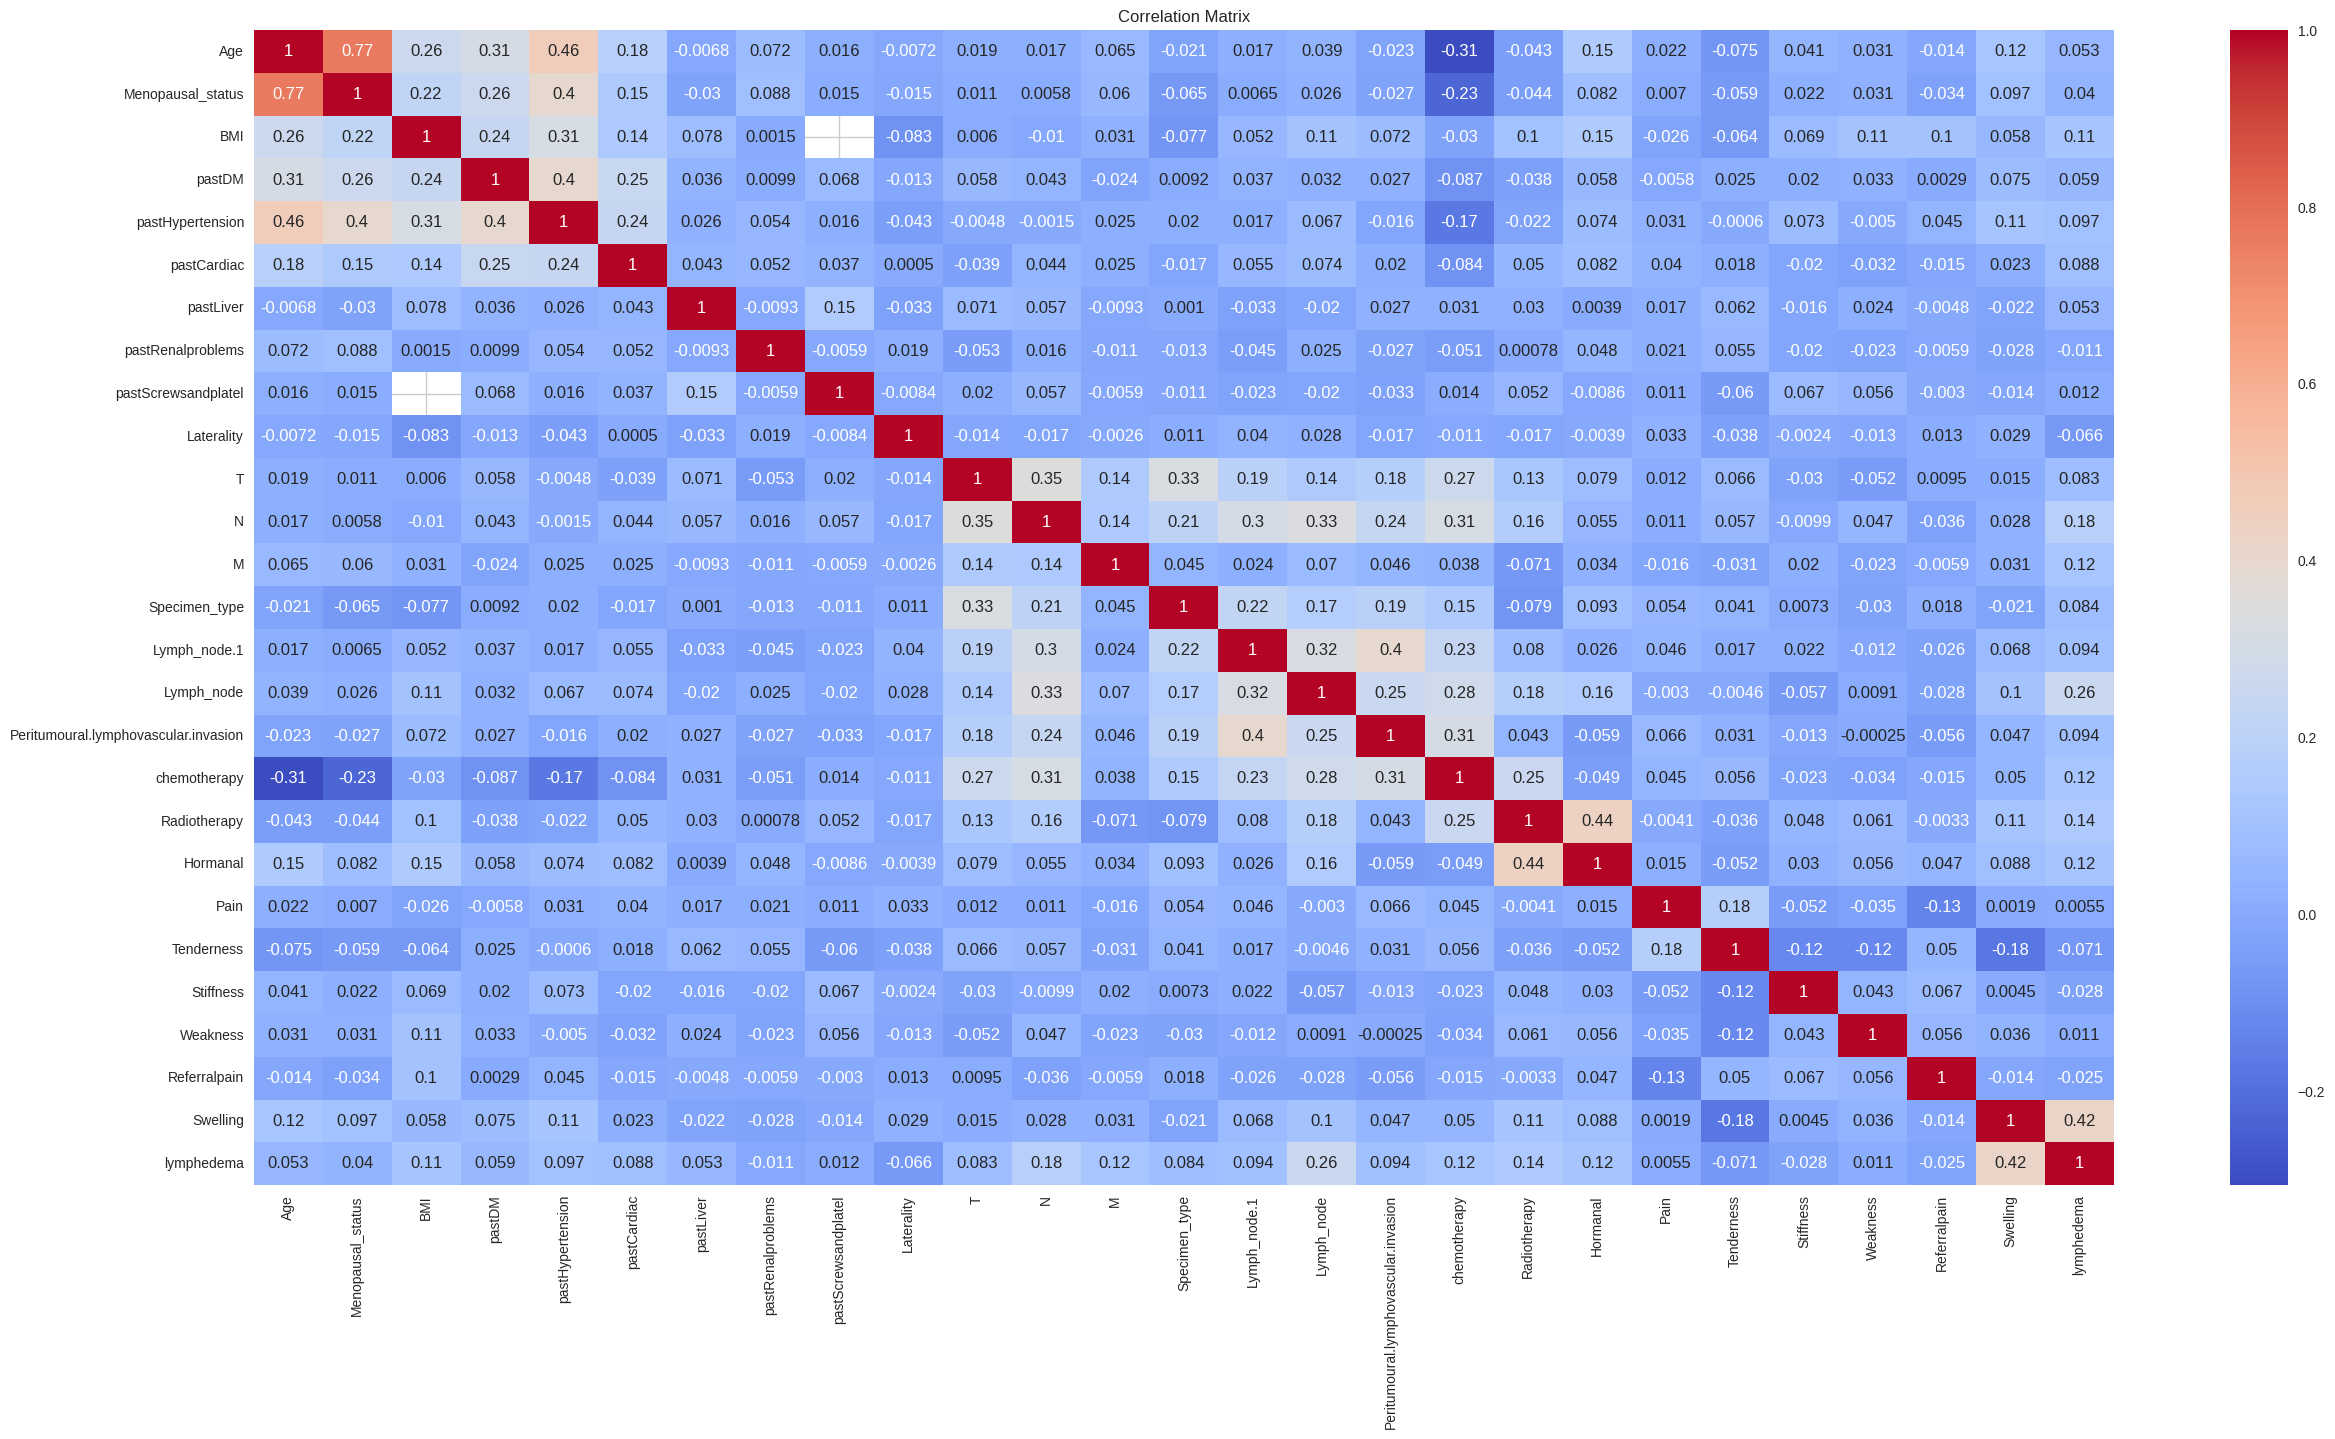

In [ ]:
correlation_matrix = df_encoded.corr()
correlation_matrix
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


MISSING VALUE IMPUTATION
  ✓ Missing values after encoding: 3387
  ✓ Columns with missing values: {'Age': 17, 'Menopausal_status': 270, 'BMI': 798, 'T': 387, 'N': 388, 'Specimen_type': 34, 'Lymph_node.1': 270, 'Lymph_node': 845, 'Peritumoural.lymphovascular.invasion': 378}

--------------------------------------------------
Multi-strategy Imputation
--------------------------------------------------
Applying multiple imputation techniques and selecting the best
▶ MissForest Imputation


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


  ✓ MissForest imputation: completed

--------------------------------------------------
Before and After MissForest Imputation
--------------------------------------------------


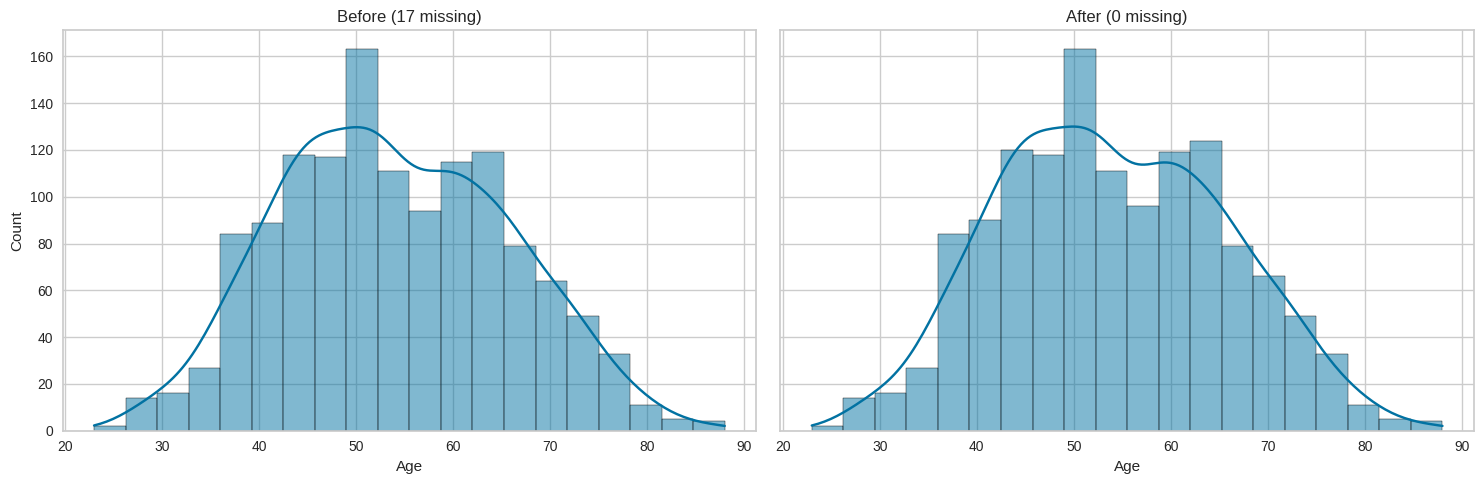

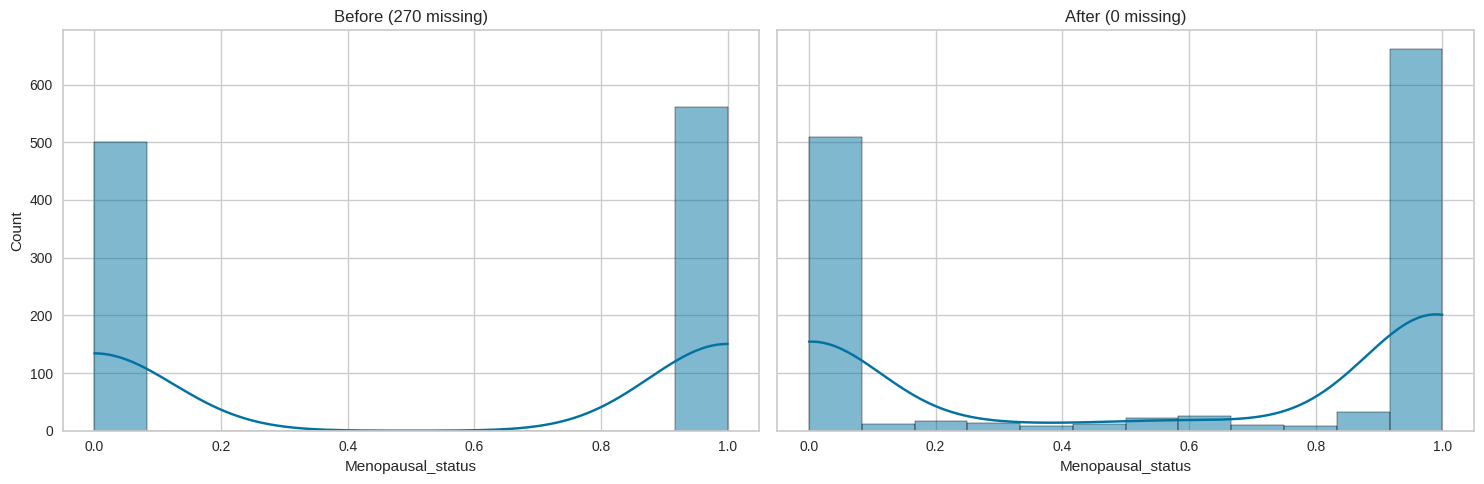

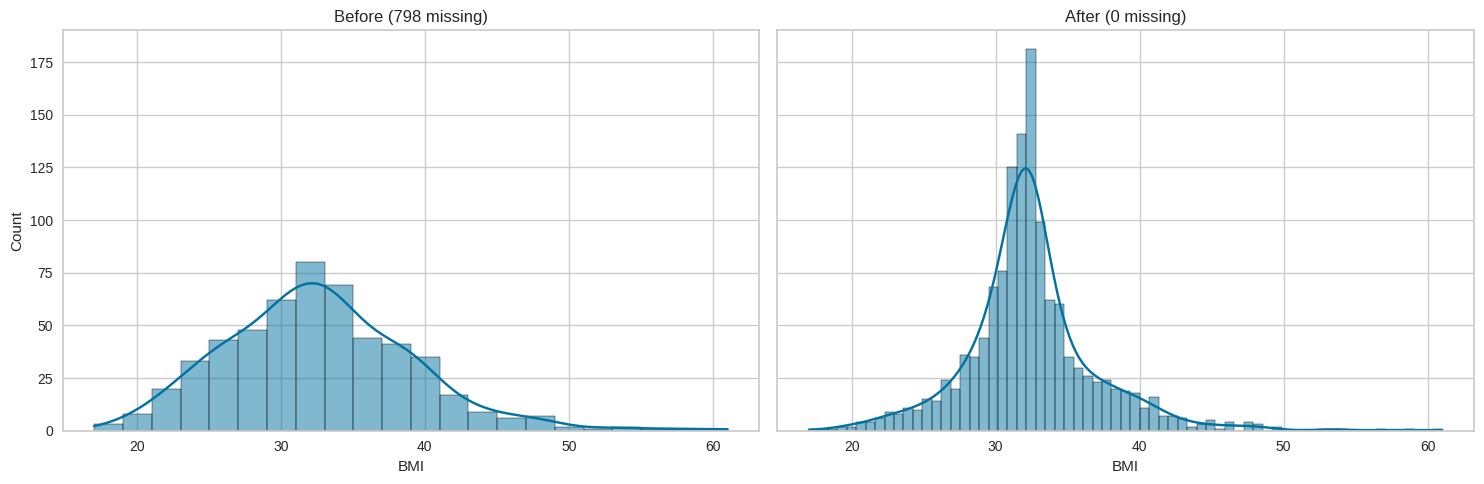

▶ KNN Imputation
  ✓ KNN imputation: completed
▶ Iterative Imputation
  ✓ Iterative imputation: completed

--------------------------------------------------
Evaluating Imputation Methods
--------------------------------------------------
  ✓ MissForest F1 Score: 0.4504 ± 0.0412
  ✓ KNN F1 Score: 0.4344 ± 0.0334
  ✓ Iterative F1 Score: 0.4488 ± 0.0717
  ✓ Best imputation method: MissForest
  ✓ Missing values after imputation: 0


In [ ]:
Logger.section("Missing Value Imputation")

# Count missing values after encoding
missing_after_encoding = df_encoded.isnull().sum().sum()
Logger.result("Missing values after encoding", missing_after_encoding)

if missing_after_encoding > 0:
    missing_by_column = df_encoded.isnull().sum()
    missing_cols = missing_by_column[missing_by_column > 0]
    Logger.result("Columns with missing values", missing_cols.to_dict())

    # Define categorical features (needed for MissForest)
    categorical_features = [
        'Laterality', 'Lymph_node', 'Menopausal_status', 'pastDM', 'pastHypertension',
        'pastCardiac', 'pastLiver', 'pastRenalproblems', 'pastScrewsandplatel', 'T', 'N', 'M',
        'Specimen_type', 'Peritumoural.lymphovascular.invasion', 'chemotherapy', 'Radiotherapy',
        'Hormanal', 'Pain', 'Tenderness', 'Stiffness', 'Weakness', 'Referralpain', 'Swelling', 'lymphedema',
        'Lymph_node.1'
    ]

    # Filter to only include existing columns
    categorical_features = [col for col in categorical_features if col in df_encoded.columns]

    # Advanced imputation strategy
    Logger.subsection("Multi-strategy Imputation")
    print("Applying multiple imputation techniques and selecting the best")

    # Create a copy for each imputation method
    df_missforest = df_encoded.copy()
    df_knn = df_encoded.copy()
    df_iterative = df_encoded.copy()

    # 1. MissForest Imputation (non-parametric approach)
    Logger.step("MissForest Imputation")
    try:
        # Identify categorical and continuous features
        numeric_features = df_encoded.select_dtypes(include=['float']).columns.tolist()
        categorical_features = [col for col in df_encoded.columns if col not in numeric_features]

        # Create MissForest with separate estimators for categorical and continuous features
        mf_imputer = MissForest(
            # Use a classifier for categorical features
            clf=RandomForestClassifier(n_estimators=100, n_jobs=-1),
            # Use a regressor for continuous features
            rgr=RandomForestRegressor(n_estimators=100, n_jobs=-1),
            # Specify which features are categorical
            categorical=categorical_features,
            max_iter=10
        )

        # Fit and transform
        df_missforest_imputed = mf_imputer.fit_transform(df_missforest)
        # Convert back to DataFrame
        df_missforest = pd.DataFrame(df_missforest_imputed, columns=df_encoded.columns)
        Logger.result("MissForest imputation", "completed")

        # Visualize before and after imputation for a few numeric features
        numeric_with_missing = [col for col in numeric_features
                                if col in missing_cols.index
                                and df_encoded[col].isnull().sum() > 0]

        if numeric_with_missing:
            Logger.subsection("Before and After MissForest Imputation")
            for col in numeric_with_missing[:3]:  # Show first 3 features with missing values
                fig = plot_before_after_imputation(df_encoded, df_missforest, col)
                plt.show()

    except Exception as e:
        Logger.result("MissForest error", str(e))
        Logger.step("Falling back to simpler imputation method")

        # Create separate imputers for categorical and continuous features
        # For numeric features
        numeric_features = df_encoded.select_dtypes(include=['float']).columns.tolist()
        # For categorical features (converted to numeric)
        categorical_features = [col for col in df_encoded.columns if col not in numeric_features]

        # Create specialized imputers for each type
        num_imputer = IterativeImputer(
            estimator=RandomForestRegressor(n_estimators=100, random_state=42),
            max_iter=10,
            random_state=42
        )

        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Handle numeric features
        if numeric_features:
            df_missforest[numeric_features] = num_imputer.fit_transform(df_encoded[numeric_features])

        # Handle categorical features
        if categorical_features:
            df_missforest[categorical_features] = cat_imputer.fit_transform(df_encoded[categorical_features])

        Logger.result("Mixed imputation fallback", "completed")

    # 2. KNN Imputation
    Logger.step("KNN Imputation")
    knn_imputer = KNNImputer(n_neighbors=5)
    df_knn = pd.DataFrame(
        knn_imputer.fit_transform(df_knn),
        columns=df_encoded.columns
    )
    Logger.result("KNN imputation", "completed")

    # 3. Iterative Imputation with Bayesian Ridge
    Logger.step("Iterative Imputation")
    iterative_imputer = IterativeImputer(random_state=42)
    df_iterative = pd.DataFrame(
        iterative_imputer.fit_transform(df_iterative),
        columns=df_encoded.columns
    )
    Logger.result("Iterative imputation", "completed")

    # Evaluate each imputation method using a simple model
    Logger.subsection("Evaluating Imputation Methods")

    # Function to evaluate imputation
    def evaluate_imputation(df_imputed, name):
        # Skip if target is not in the DataFrame
        if 'lymphedema' not in df_imputed.columns:
            return None

        # Split data
        X = df_imputed.drop(columns=['lymphedema'])
        y = df_imputed['lymphedema']

        # Simple validation with a baseline model
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(clf, X, y, cv=5, scoring='f1')

        Logger.result(f"{name} F1 Score", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        return cv_scores.mean()

    # Evaluate all methods
    mf_score = evaluate_imputation(df_missforest, "MissForest")
    knn_score = evaluate_imputation(df_knn, "KNN")
    iterative_score = evaluate_imputation(df_iterative, "Iterative")

    # Select the best method
    best_score = max([s for s in [mf_score, knn_score, iterative_score] if s is not None])

    if mf_score == best_score:
        df_imputed = df_missforest
        Logger.result("Best imputation method", "MissForest")
    elif knn_score == best_score:
        df_imputed = df_knn
        Logger.result("Best imputation method", "KNN")
    else:
        df_imputed = df_iterative
        Logger.result("Best imputation method", "Iterative")
else:
    # No missing values, proceed with encoded data
    df_imputed = df_encoded
    Logger.result("Imputation", "not needed (no missing values)")

# Check if imputation was successful
missing_after_imputation = df_imputed.isnull().sum().sum()
Logger.result("Missing values after imputation", missing_after_imputation)

# If there are still missing values, drop them (should be rare at this point)
if missing_after_imputation > 0:
    df_imputed = df_imputed.dropna()
    Logger.result("Rows dropped due to remaining missing values",
                  f"{missing_after_imputation - df_imputed.isnull().sum().sum()}")



ADVANCED FEATURE ENGINEERING AND SELECTION

--------------------------------------------------
Feature Normalization
--------------------------------------------------

DEBUG - Before/After Normalization Check:
Column being checked: Age
BEFORE scaling - First 5 values: [45. 69. 48. 54. 44.]
AFTER scaling - First 5 values: [-0.76123851  1.27621051 -0.50655738  0.00280487 -0.84613222]
Are df_before_norm and df_imputed the same object? False
  ✓ Standard scaling applied to numeric features: ['Age', 'Menopausal_status', 'BMI', 'T', 'N', 'Specimen_type', 'Lymph_node.1', 'Lymph_node', 'Peritumoural.lymphovascular.invasion']

--------------------------------------------------
Before and After Normalization
--------------------------------------------------


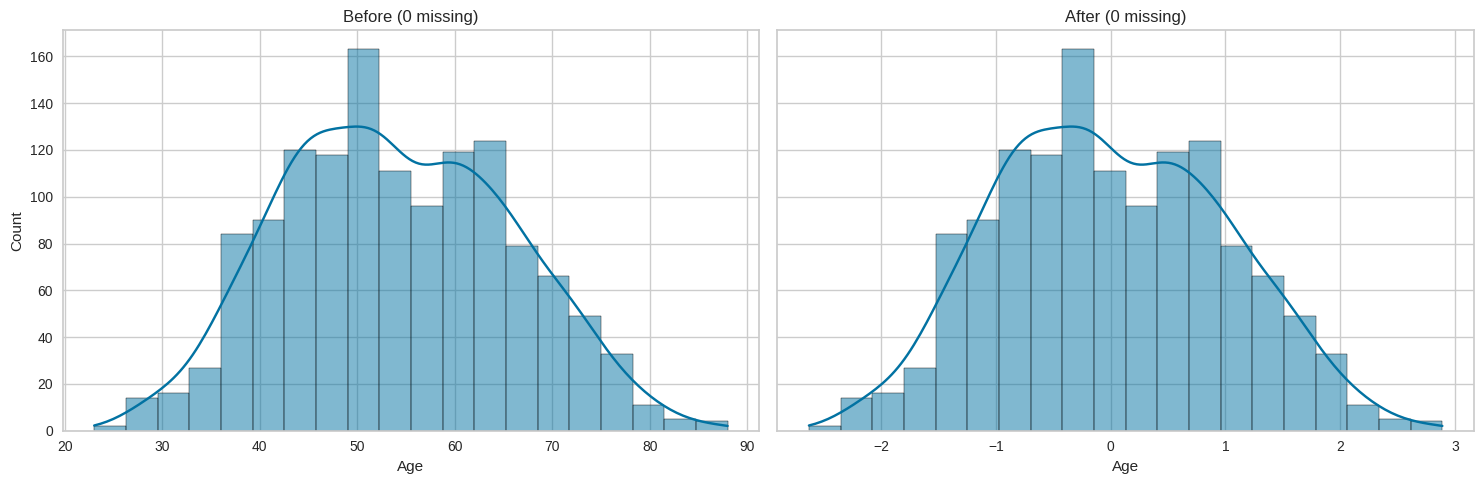

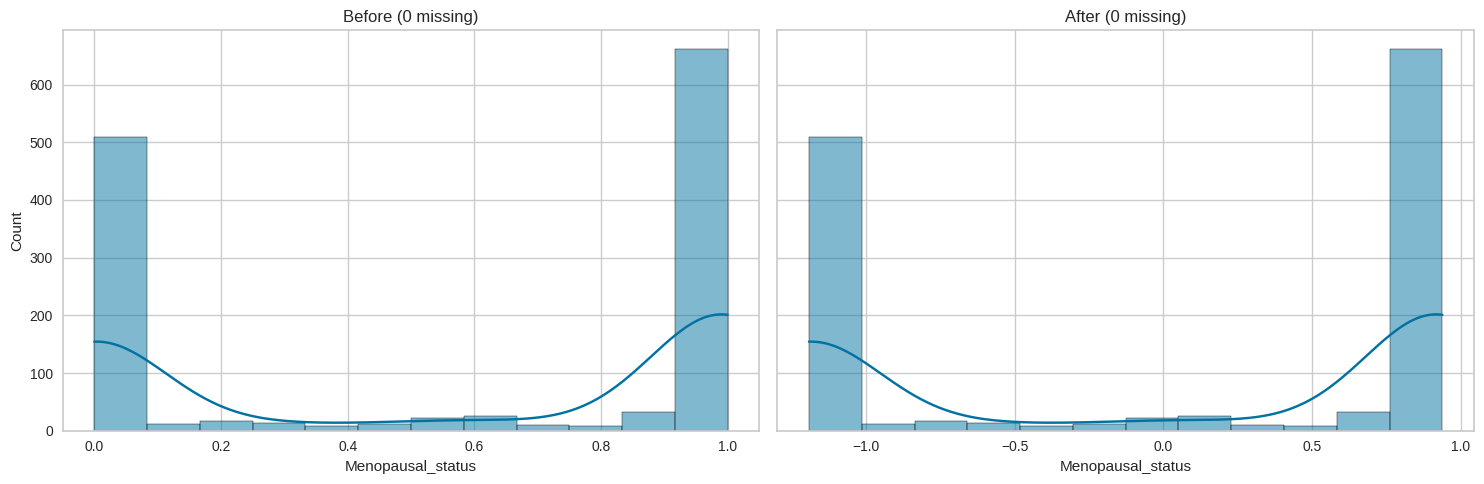

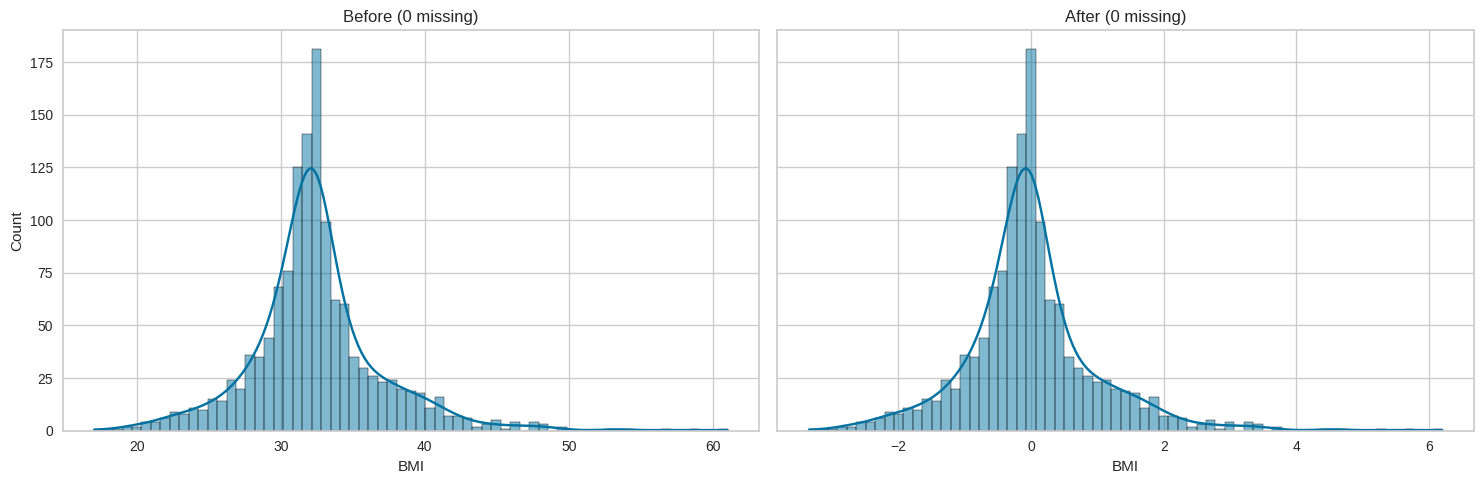


--------------------------------------------------
Feature Creation
--------------------------------------------------
  ✓ Created age-related features: ['Age_Squared', 'Age_Group']
  ✓ Created BMI-Age interaction: BMI_Age_Interaction
  ✓ Created interaction: chemotherapy_T_Interaction
  ✓ Created interaction: chemotherapy_N_Interaction
  ✓ Created interaction: chemotherapy_M_Interaction
  ✓ Created interaction: chemotherapy_Peritumoural.lymphovascular.invasion_Interaction
  ✓ Created interaction: Radiotherapy_T_Interaction
  ✓ Created interaction: Radiotherapy_N_Interaction
  ✓ Created interaction: Radiotherapy_M_Interaction
  ✓ Created interaction: Radiotherapy_Peritumoural.lymphovascular.invasion_Interaction
  ✓ Created interaction: Hormanal_T_Interaction
  ✓ Created interaction: Hormanal_N_Interaction
  ✓ Created interaction: Hormanal_M_Interaction
  ✓ Created interaction: Hormanal_Peritumoural.lymphovascular.invasion_Interaction

--------------------------------------------------

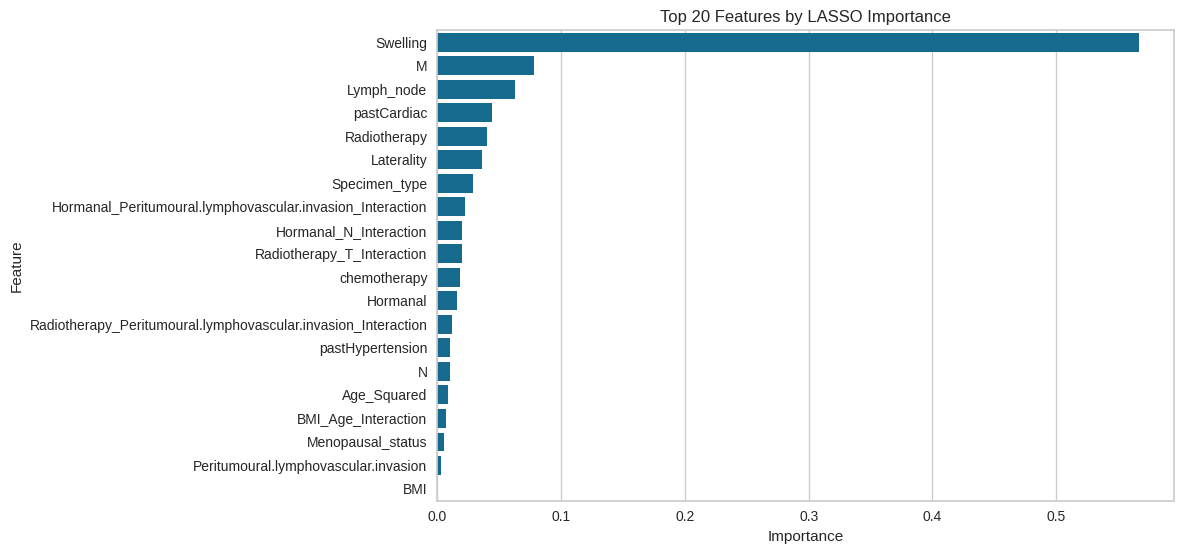

  ✓ Final feature count: 19

--------------------------------------------------
Outlier Detection - Keeping All Data Points
--------------------------------------------------
  ✓ Number of rows with outliers: 878
  ✓ Percentage of rows with outliers: 65.97%
  ✓ Final dataset shape (with outliers kept): (1331, 21)
  ✓ Number of outliers in final dataset: 878


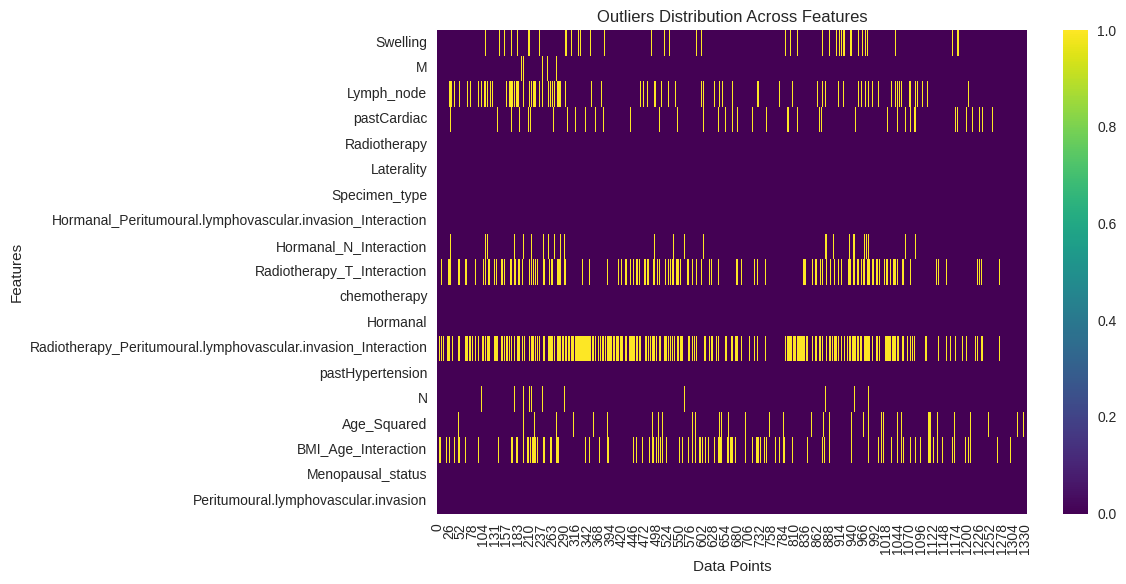

In [ ]:
Logger.section("Advanced Feature Engineering and Selection")

# 1. Feature normalization
Logger.subsection("Feature Normalization")

# For numeric features that aren't binary
numeric_features = df_imputed.select_dtypes(include=['float']).columns.tolist()

# IMPORTANT: Make sure target variable isn't included in normalization
if 'lymphedema' in numeric_features:
    numeric_features.remove('lymphedema')

# Save data before normalization for visualization (using deep copy to ensure independence)
df_before_norm = df_imputed.copy(deep=True)

# Add debug output to verify differences
print("\nDEBUG - Before/After Normalization Check:")
numeric_col = numeric_features[0] if len(numeric_features) > 0 else df_imputed.columns[0]
print(f"Column being checked: {numeric_col}")
print(f"BEFORE scaling - First 5 values: {df_before_norm[numeric_col].head().values}")

# Changed to StandardScaler
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df_imputed[numeric_features] = standard_scaler.fit_transform(df_imputed[numeric_features])

# Verify transformation was actually applied
print(f"AFTER scaling - First 5 values: {df_imputed[numeric_col].head().values}")
print(f"Are df_before_norm and df_imputed the same object? {df_before_norm is df_imputed}")
Logger.result("Standard scaling applied to numeric features", numeric_features)

# Visualize before and after normalization
Logger.subsection("Before and After Normalization")
for col in numeric_features[:3]:  # Show first 3 numeric features
    fig = plot_before_after_imputation(df_before_norm, df_imputed, col)
    plt.show()

# 2. Feature creation (domain-specific for medical data)
Logger.subsection("Feature Creation")

# Example: Create age groups if age is present
if 'Age' in df_imputed.columns:
    df_imputed['Age_Squared'] = df_imputed['Age'] ** 2
    df_imputed['Age_Group'] = pd.qcut(df_imputed['Age'], q=4, labels=[0, 1, 2, 3])
    Logger.result("Created age-related features", ['Age_Squared', 'Age_Group'])

# Create interaction terms between important clinical features
if 'BMI' in df_imputed.columns and 'Age' in df_imputed.columns:
    df_imputed['BMI_Age_Interaction'] = df_imputed['BMI'] * df_imputed['Age']
    Logger.result("Created BMI-Age interaction", "BMI_Age_Interaction")

# Create interactions between treatment types and clinical features
treatment_cols = [col for col in df_imputed.columns if col in ['chemotherapy', 'Radiotherapy', 'Hormanal']]
clinical_cols = [col for col in df_imputed.columns if col in ['T', 'N', 'M', 'Peritumoural.lymphovascular.invasion']]

# Create meaningful interactions
for t_col in treatment_cols:
    for c_col in clinical_cols:
        if t_col in df_imputed.columns and c_col in df_imputed.columns:
            df_imputed[f'{t_col}_{c_col}_Interaction'] = df_imputed[t_col] * df_imputed[c_col]
            Logger.result(f"Created interaction", f"{t_col}_{c_col}_Interaction")

# Save original feature list before adding polynomial features
original_features = df_imputed.columns.tolist()
if 'lymphedema' in original_features:
    original_features.remove('lymphedema')

# 3. Feature selection
Logger.subsection("Feature Selection")

# Separate features and target
X = df_imputed.drop(columns=['lymphedema'])
y = df_imputed['lymphedema']

# Correlation-based feature selection
Logger.step("Correlation-based Selection")
correlation_threshold = 0.8
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]

Logger.result("Features dropped due to high correlation", to_drop)
X = X.drop(columns=to_drop)

# LASSO-based feature selection
Logger.step("LASSO-based Selection")
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(lasso.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Select features with non-zero coefficients
selected_features = feature_importance[feature_importance['Importance'] > 0]['Feature'].tolist()
Logger.result("LASSO selected features", len(selected_features))

# Take top features from LASSO
X_selected = X[selected_features]

# Display feature importance
Logger.subsection("Feature Importance")
plt.figure(figsize=(12, len(selected_features) * 0.3))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Features by LASSO Importance')
plt.tight_layout()
plt.show()

# Update the imputed dataframe to include selected features and target
df_selected = pd.concat([X_selected, y], axis=1)
Logger.result("Final feature count", len(selected_features))

# Identify outliers but don't remove them
Logger.subsection("Outlier Detection - Keeping All Data Points")

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, columns, threshold=1.5):
    """
    Detect outliers using the IQR method

    Parameters:
    -----------
    df : DataFrame
    columns : list of column names to check for outliers
    threshold : IQR multiplier for outlier detection (default: 1.5)

    Returns:
    --------
    DataFrame with boolean mask of outliers
    """
    outlier_mask = pd.DataFrame(False, index=df.index, columns=columns)

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outlier_mask[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outlier_mask

# Identify numeric features
numeric_features = X_selected.select_dtypes(include=['float', 'int']).columns.tolist()

# Detect outliers (for information only)
outlier_mask = detect_outliers_iqr(X_selected, numeric_features)
outlier_rows = outlier_mask.any(axis=1)
outlier_count = outlier_rows.sum()

Logger.result("Number of rows with outliers", outlier_count)
Logger.result("Percentage of rows with outliers", f"{100 * outlier_count / len(X_selected):.2f}%")

# Instead of removing outliers, keep them in the dataset
# Flag outliers for potential visualization or special treatment
X_selected['is_outlier'] = outlier_rows

# Create dataset with all data points (including outliers)
# This is the dataset we'll use for modeling
final_dataset = df_selected.copy()
final_dataset['is_outlier'] = outlier_rows

Logger.result("Final dataset shape (with outliers kept)", final_dataset.shape)
Logger.result("Number of outliers in final dataset", outlier_rows.sum())

# Optional: Visualize the distribution of outliers across features
plt.figure(figsize=(12, 6))
sns.heatmap(outlier_mask.T, cmap='viridis', cbar=True)
plt.title('Outliers Distribution Across Features')
plt.xlabel('Data Points')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


CLASS IMBALANCE HANDLING
  ✓ Original class distribution: {0: 1104, 1: 227}
  ✓ Class weights: {0: np.float64(0.6028079710144928), 1: np.float64(2.9317180616740086)}

--------------------------------------------------
SMOTE-Tomek Balancing
--------------------------------------------------
  ✓ SMOTE-Tomek balanced distribution: {1: 1098, 0: 1098}
  ✓ SMOTE-Tomek data saved to: lymphedema_smote_tomek.xlsx

--------------------------------------------------
BorderlineSMOTE Balancing
--------------------------------------------------
  ✓ BorderlineSMOTE balanced distribution: {1: 1104, 0: 1104}
  ✓ BorderlineSMOTE data saved to: lymphedema_borderline_smote.xlsx

--------------------------------------------------
ADASYN Balancing
--------------------------------------------------
  ✓ ADASYN balanced distribution: {0: 1104, 1: 1068}
  ✓ ADASYN data saved to: lymphedema_adasyn.xlsx

--------------------------------------------------
Custom Advanced Balancing
--------------------------------

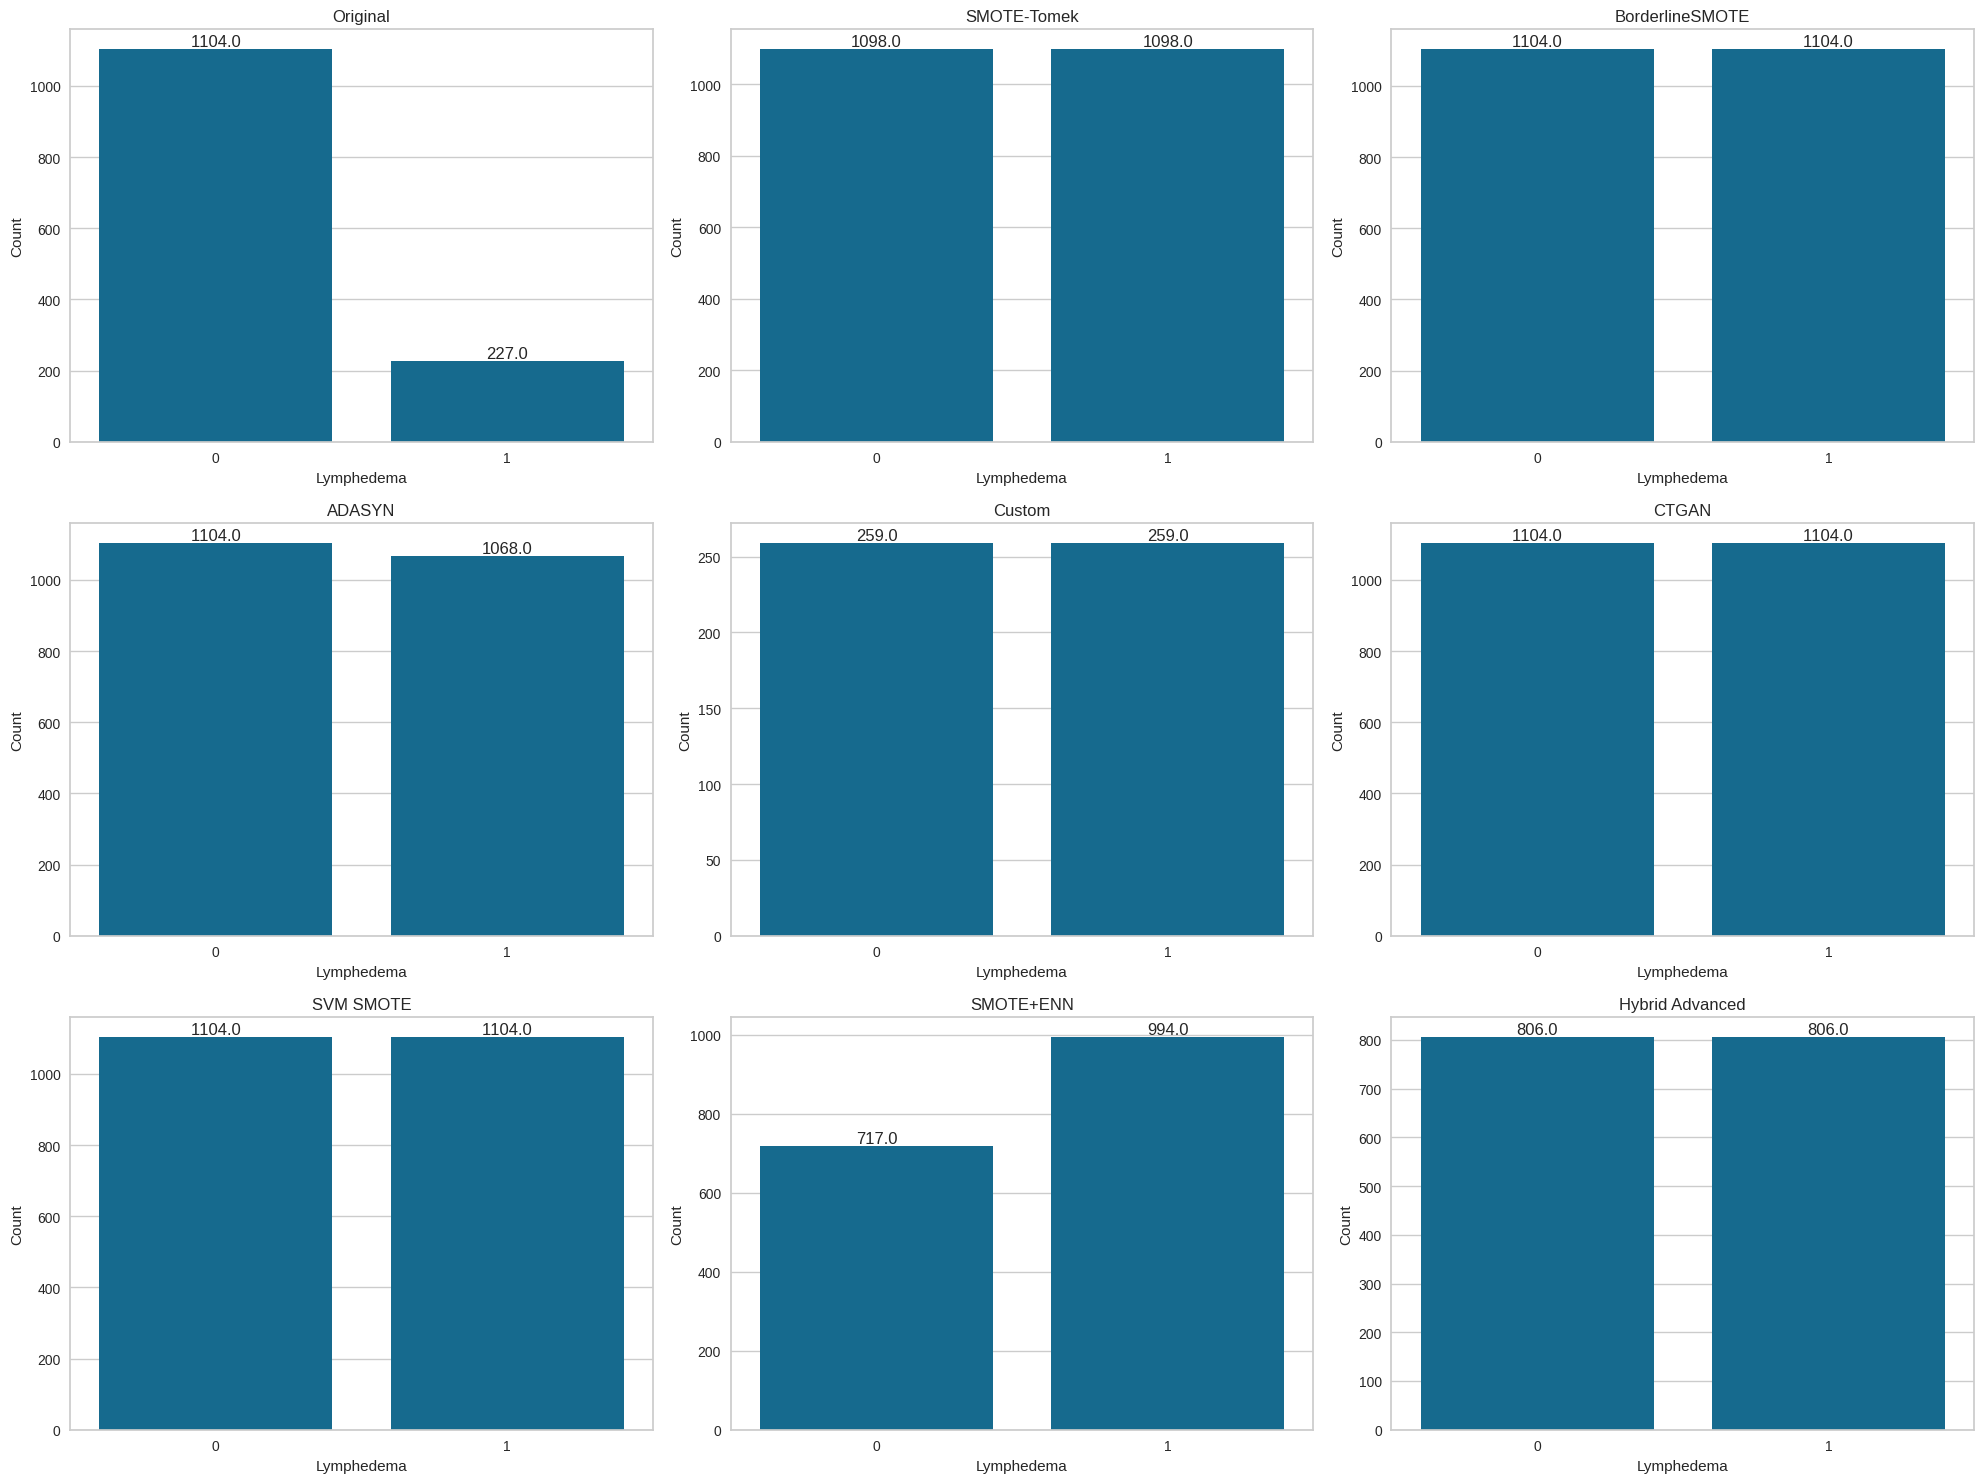


MODEL EVALUATION ACROSS BALANCING TECHNIQUES

--------------------------------------------------
Evaluating on Original dataset
--------------------------------------------------
  ✓ Logistic Regression on Original: Accuracy: 0.7566, F1 Score: 0.4444
  ✓ Random Forest on Original: Accuracy: 0.8502, F1 Score: 0.4286
  ✓ Gradient Boosting on Original: Accuracy: 0.8315, F1 Score: 0.4000
  ✓ SVM on Original: Accuracy: 0.7790, F1 Score: 0.4040
  ✓ XGBoost on Original: Accuracy: 0.8464, F1 Score: 0.4533
[LightGBM] [Info] Number of positive: 181, number of negative: 883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 1064, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170113 -> initscore=-1.5848

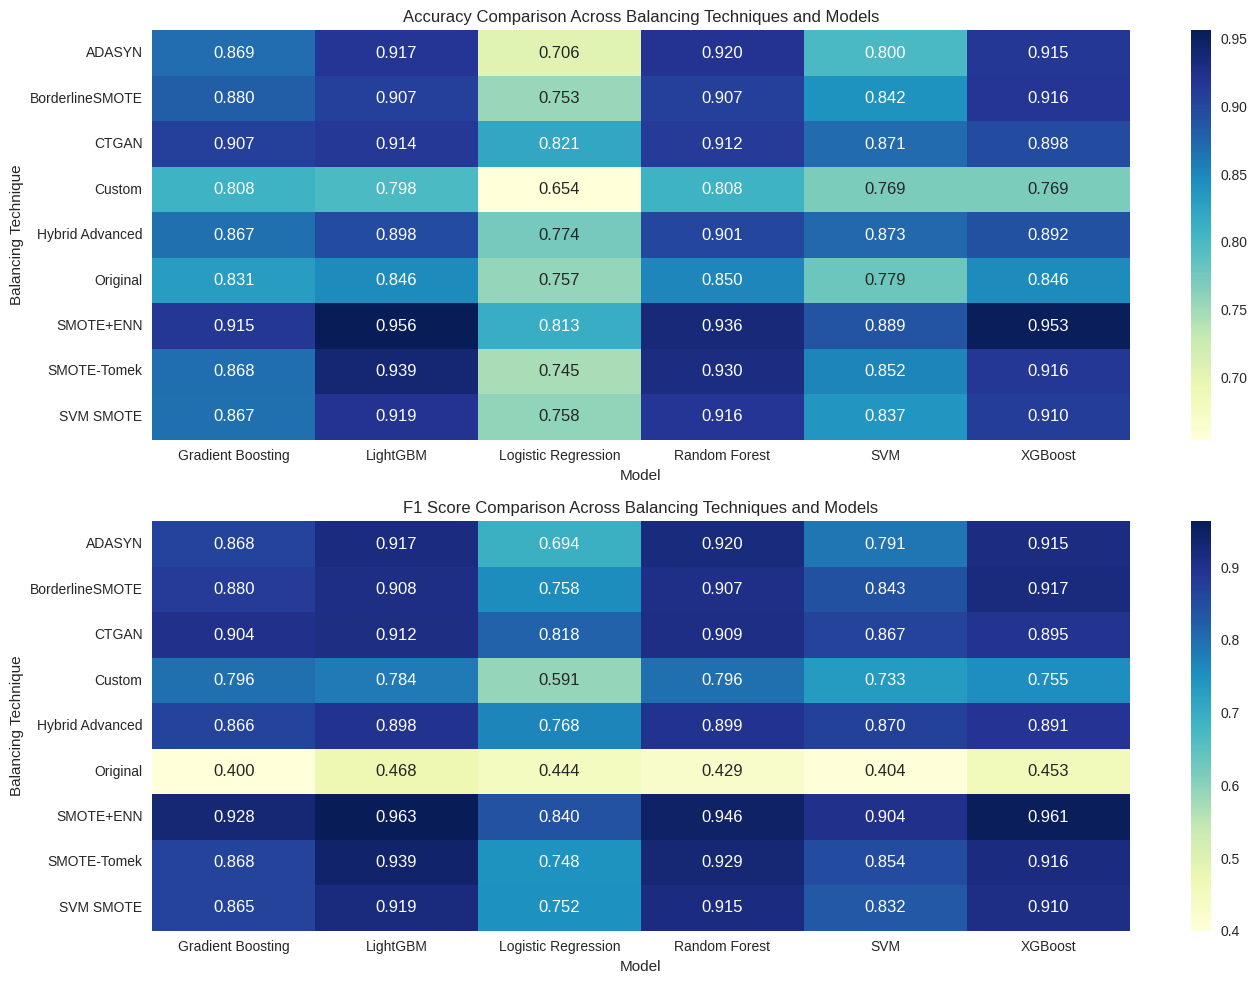


BEST BALANCING TECHNIQUES
  ✓ Average F1 Score ranking: {'SMOTE+ENN': 0.9234933175958832, 'CTGAN': 0.8839026041045731, 'SMOTE-Tomek': 0.8757150830984365, 'BorderlineSMOTE': 0.8690509840805399, 'SVM SMOTE': 0.8653762312734662, 'Hybrid Advanced': 0.865278596407047, 'ADASYN': 0.8507106063414499, 'Custom': 0.7424477257319673, 'Original': 0.432987012987013}
  ✓ Best models for each technique: {'Model': {'ADASYN': 'Random Forest', 'BorderlineSMOTE': 'XGBoost', 'CTGAN': 'LightGBM', 'Custom': 'Random Forest', 'Hybrid Advanced': 'Random Forest', 'Original': 'LightGBM', 'SMOTE+ENN': 'LightGBM', 'SMOTE-Tomek': 'LightGBM', 'SVM SMOTE': 'LightGBM'}, 'F1 Score': {'ADASYN': 0.9195402298850575, 'BorderlineSMOTE': 0.9168539325842696, 'CTGAN': 0.9116279069767442, 'Custom': 0.7959183673469388, 'Hybrid Advanced': 0.8987341772151899, 'Original': 0.4675324675324675, 'SMOTE+ENN': 0.9629629629629629, 'SMOTE-Tomek': 0.9393258426966292, 'SVM SMOTE': 0.918918918918919}}

BEST OVERALL PERFORMANCE
  ✓ Best combin

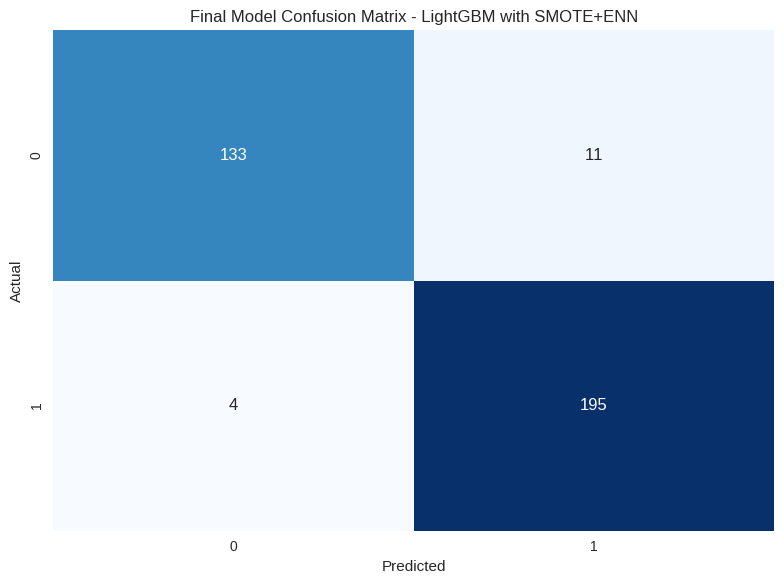

  ✓ Final model saved to: lymphedema_final_model.pkl
  ✓ Scaler saved to: lymphedema_scaler.pkl

Modeling Process Complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from ctgan import CTGAN

# Assume we have Logger class and X_selected, y from previous code

Logger.section("Class Imbalance Handling")

# Create multiple balanced datasets using different techniques
# Get class distribution
class_counts = y.value_counts()
Logger.result("Original class distribution", class_counts.to_dict())

# Calculate class weights for models that support it
class_weights = {
    0: len(y) / (2 * (y == 0).sum()),
    1: len(y) / (2 * (y == 1).sum())
}
Logger.result("Class weights", class_weights)

# 1. SMOTE-Tomek Links
Logger.subsection("SMOTE-Tomek Balancing")
smote_tomek = SMOTETomek(random_state=42)
X_resampled_smote_tomek, y_resampled_smote_tomek = smote_tomek.fit_resample(X_selected, y)
Logger.result("SMOTE-Tomek balanced distribution", pd.Series(y_resampled_smote_tomek).value_counts().to_dict())

# Save SMOTE-Tomek balanced dataset
df_smote_tomek = pd.concat([
    pd.DataFrame(X_resampled_smote_tomek, columns=X_selected.columns),
    pd.Series(y_resampled_smote_tomek, name='lymphedema')
], axis=1)
df_smote_tomek.to_excel("lymphedema_smote_tomek.xlsx", index=False)
Logger.result("SMOTE-Tomek data saved to", "lymphedema_smote_tomek.xlsx")

# 2. BorderlineSMOTE (more focused synthetic samples)
Logger.subsection("BorderlineSMOTE Balancing")
b_smote = BorderlineSMOTE(random_state=42)
X_resampled_bsmote, y_resampled_bsmote = b_smote.fit_resample(X_selected, y)
Logger.result("BorderlineSMOTE balanced distribution", pd.Series(y_resampled_bsmote).value_counts().to_dict())

# Save BorderlineSMOTE balanced dataset
df_bsmote = pd.concat([
    pd.DataFrame(X_resampled_bsmote, columns=X_selected.columns),
    pd.Series(y_resampled_bsmote, name='lymphedema')
], axis=1)
df_bsmote.to_excel("lymphedema_borderline_smote.xlsx", index=False)
Logger.result("BorderlineSMOTE data saved to", "lymphedema_borderline_smote.xlsx")

# 3. ADASYN (Adaptive Synthetic Sampling)
Logger.subsection("ADASYN Balancing")
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_selected, y)
Logger.result("ADASYN balanced distribution", pd.Series(y_resampled_adasyn).value_counts().to_dict())

# Save ADASYN balanced dataset
df_adasyn = pd.concat([
    pd.DataFrame(X_resampled_adasyn, columns=X_selected.columns),
    pd.Series(y_resampled_adasyn, name='lymphedema')
], axis=1)
df_adasyn.to_excel("lymphedema_adasyn.xlsx", index=False)
Logger.result("ADASYN data saved to", "lymphedema_adasyn.xlsx")

# 4. Custom Advanced Balancing (combination of techniques)
Logger.subsection("Custom Advanced Balancing")

# Custom approach: Combine undersampling majority with synthetic minority
# Use Tomek links to clean the boundary, then Borderline SMOTE for focused synthetic samples
rus = RandomUnderSampler(sampling_strategy=0.75, random_state=42)  # Reduce majority but don't fully balance
X_temp, y_temp = rus.fit_resample(X_selected, y)

# Clean the boundary using Tomek links
tl = TomekLinks()
X_temp_clean, y_temp_clean = tl.fit_resample(X_temp, y_temp)

# Add focused synthetic samples
b_smote = BorderlineSMOTE(random_state=42)
X_resampled_custom, y_resampled_custom = b_smote.fit_resample(X_temp_clean, y_temp_clean)

Logger.result("Custom balanced distribution", pd.Series(y_resampled_custom).value_counts().to_dict())

# Save custom balanced dataset
df_custom = pd.concat([
    pd.DataFrame(X_resampled_custom, columns=X_selected.columns),
    pd.Series(y_resampled_custom, name='lymphedema')
], axis=1)
df_custom.to_excel("lymphedema_custom_balanced.xlsx", index=False)
Logger.result("Custom balanced data saved to", "lymphedema_custom_balanced.xlsx")

# 5. CTGAN for synthetic data generation
Logger.subsection("CTGAN Synthetic Data Generation")

# Combine features and target into one dataframe for CTGAN
df_for_ctgan = pd.concat([X_selected, y], axis=1)

# Separate majority and minority classes
df_majority = df_for_ctgan[df_for_ctgan['lymphedema'] == 0]
df_minority = df_for_ctgan[df_for_ctgan['lymphedema'] == 1]

# Initialize and train CTGAN on the minority class
ctgan = CTGAN(epochs=100, batch_size=100)
ctgan.fit(df_minority, discrete_columns=['lymphedema'])

# Generate synthetic minority samples
synthetic_samples_count = len(df_majority) - len(df_minority)
synthetic_minority = ctgan.sample(synthetic_samples_count)

# Combine the original minority class with synthetic samples
df_ctgan_balanced = pd.concat([df_majority, df_minority, synthetic_minority])
Logger.result("CTGAN balanced distribution", df_ctgan_balanced['lymphedema'].value_counts().to_dict())

# Separate features and target
X_resampled_ctgan = df_ctgan_balanced.drop('lymphedema', axis=1)
y_resampled_ctgan = df_ctgan_balanced['lymphedema']

# Save CTGAN balanced dataset
df_ctgan_balanced.to_excel("lymphedema_ctgan.xlsx", index=False)
Logger.result("CTGAN data saved to", "lymphedema_ctgan.xlsx")

# 6. NEW: SVM SMOTE (Support Vector Machine SMOTE)
Logger.subsection("SVM SMOTE Balancing")
svm_smote = SVMSMOTE(random_state=42)
X_resampled_svmsmote, y_resampled_svmsmote = svm_smote.fit_resample(X_selected, y)
Logger.result("SVM SMOTE balanced distribution", pd.Series(y_resampled_svmsmote).value_counts().to_dict())

# Save SVM SMOTE balanced dataset
df_svmsmote = pd.concat([
    pd.DataFrame(X_resampled_svmsmote, columns=X_selected.columns),
    pd.Series(y_resampled_svmsmote, name='lymphedema')
], axis=1)
df_svmsmote.to_excel("lymphedema_svm_smote.xlsx", index=False)
Logger.result("SVM SMOTE data saved to", "lymphedema_svm_smote.xlsx")

# 7. NEW: SMOTE + ENN (SMOTE with Edited Nearest Neighbors cleaning)
Logger.subsection("SMOTE + ENN Balancing")
smote_enn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(X_selected, y)
Logger.result("SMOTE+ENN balanced distribution", pd.Series(y_resampled_smoteenn).value_counts().to_dict())

# Save SMOTE+ENN balanced dataset
df_smoteenn = pd.concat([
    pd.DataFrame(X_resampled_smoteenn, columns=X_selected.columns),
    pd.Series(y_resampled_smoteenn, name='lymphedema')
], axis=1)
df_smoteenn.to_excel("lymphedema_smote_enn.xlsx", index=False)
Logger.result("SMOTE+ENN data saved to", "lymphedema_smote_enn.xlsx")

# 8. NEW: Advanced Hybrid Approach (Two-phase balancing)
Logger.subsection("Advanced Hybrid Balancing")
# First phase: Clean the boundary noisy samples using ENN
enn = EditedNearestNeighbours()
X_cleaned, y_cleaned = enn.fit_resample(X_selected, y)

# Second phase: Apply SVM SMOTE for intelligent synthetic data generation
hybrid_svmsmote = SVMSMOTE(random_state=42, k_neighbors=5, m_neighbors=10)
X_resampled_hybrid, y_resampled_hybrid = hybrid_svmsmote.fit_resample(X_cleaned, y_cleaned)

Logger.result("Hybrid Advanced balanced distribution", pd.Series(y_resampled_hybrid).value_counts().to_dict())

# Save Hybrid Advanced balanced dataset
df_hybrid = pd.concat([
    pd.DataFrame(X_resampled_hybrid, columns=X_selected.columns),
    pd.Series(y_resampled_hybrid, name='lymphedema')
], axis=1)
df_hybrid.to_excel("lymphedema_hybrid_advanced.xlsx", index=False)
Logger.result("Hybrid Advanced data saved to", "lymphedema_hybrid_advanced.xlsx")

# Compare balancing techniques with visualizations
Logger.subsection("Comparing Balancing Techniques")

# Plot class distributions side by side
balance_comparisons = {
    'Original': y,
    'SMOTE-Tomek': y_resampled_smote_tomek,
    'BorderlineSMOTE': y_resampled_bsmote,
    'ADASYN': y_resampled_adasyn,
    'Custom': y_resampled_custom,
    'CTGAN': y_resampled_ctgan,
    'SVM SMOTE': y_resampled_svmsmote,
    'SMOTE+ENN': y_resampled_smoteenn,
    'Hybrid Advanced': y_resampled_hybrid
}

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()  # Flatten for easier indexing

for i, (name, y_balanced) in enumerate(balance_comparisons.items()):
    counts = pd.Series(y_balanced).value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Lymphedema')
    axes[i].set_ylabel('Count')

    # Add count labels
    for j, p in enumerate(axes[i].patches):
        axes[i].annotate(f'{p.get_height()}',
                      (p.get_x() + p.get_width()/2., p.get_height()),
                      ha='center', va='bottom')

plt.tight_layout()
plt.savefig("balancing_comparison.png")
plt.show()

# Now, let's add model evaluation for comparing the performance of each balancing technique
Logger.section("Model Evaluation Across Balancing Techniques")

# Define the balanced datasets
balanced_data = {
    'Original': (X_selected, y),
    'SMOTE-Tomek': (X_resampled_smote_tomek, y_resampled_smote_tomek),
    'BorderlineSMOTE': (X_resampled_bsmote, y_resampled_bsmote),
    'ADASYN': (X_resampled_adasyn, y_resampled_adasyn),
    'Custom': (X_resampled_custom, y_resampled_custom),
    'CTGAN': (X_resampled_ctgan, y_resampled_ctgan),
    'SVM SMOTE': (X_resampled_svmsmote, y_resampled_svmsmote),
    'SMOTE+ENN': (X_resampled_smoteenn, y_resampled_smoteenn),
    'Hybrid Advanced': (X_resampled_hybrid, y_resampled_hybrid)
}

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Create results storage
results = []

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model on each balanced dataset
for balance_name, (X_balanced, y_balanced) in balanced_data.items():
    Logger.subsection(f"Evaluating on {balance_name} dataset")

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model
    for model_name, model in models.items():
        if model_name in ['Logistic Regression', 'SVM'] and balance_name == 'Original':
            # Use class weights for imbalanced data
            if model_name == 'Logistic Regression':
                model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
            else:  # SVM
                model = SVC(probability=True, class_weight='balanced', random_state=42)

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Predict
        y_pred = model.predict(X_test_scaled)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        results.append({
            'Balancing Technique': balance_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1
        })

        # Print results
        Logger.result(f"{model_name} on {balance_name}", f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

        # Print detailed classification report for best models
        if f1 > 0.75:  # Arbitrary threshold for good models
            print("\nDetailed Classification Report:")
            print(classification_report(y_test, y_pred))

            # Plot confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Confusion Matrix - {model_name} on {balance_name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.savefig(f"confusion_matrix_{balance_name}_{model_name.replace(' ', '_')}.png")
            plt.close()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Save results
results_df.to_excel("balancing_techniques_comparison.xlsx", index=False)
Logger.result("Full comparison results saved to", "balancing_techniques_comparison.xlsx")

# Visualize results
plt.figure(figsize=(14, 10))

# Accuracy Comparison
plt.subplot(2, 1, 1)
pivot_acc = results_df.pivot(index='Balancing Technique', columns='Model', values='Accuracy')
sns.heatmap(pivot_acc, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Accuracy Comparison Across Balancing Techniques and Models')
plt.tight_layout()

# F1 Score Comparison
plt.subplot(2, 1, 2)
pivot_f1 = results_df.pivot(index='Balancing Technique', columns='Model', values='F1 Score')
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('F1 Score Comparison Across Balancing Techniques and Models')
plt.tight_layout()

plt.savefig("performance_comparison.png")
plt.show()

# Identify the best balancing technique based on average F1 Score
best_techniques = results_df.groupby('Balancing Technique')['F1 Score'].mean().sort_values(ascending=False)
Logger.section("Best Balancing Techniques")
Logger.result("Average F1 Score ranking", best_techniques.to_dict())

# Identify the best model for each technique
best_models = results_df.loc[results_df.groupby('Balancing Technique')['F1 Score'].idxmax()]
Logger.result("Best models for each technique", best_models[['Balancing Technique', 'Model', 'F1 Score']].set_index('Balancing Technique').to_dict())

# Overall best combination
best_row = results_df.loc[results_df['F1 Score'].idxmax()]
Logger.section("Best Overall Performance")
Logger.result("Best combination", f"{best_row['Balancing Technique']} with {best_row['Model']}")
Logger.result("Best accuracy", f"{best_row['Accuracy']:.4f}")
Logger.result("Best F1 Score", f"{best_row['F1 Score']:.4f}")

# Final chosen model - use the best technique and model from evaluation
best_technique = best_row['Balancing Technique']
best_model_name = best_row['Model']

Logger.section(f"Final Model: {best_model_name} with {best_technique}")
X_best, y_best = balanced_data[best_technique]

# Train the final model on the entire best dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_best, y_best, test_size=0.2, random_state=42, stratify=y_best
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_model = models[best_model_name]
final_model.fit(X_train_scaled, y_train)

# Final evaluation
y_pred = final_model.predict(X_test_scaled)
print("\nFinal Model Evaluation:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Final Model Confusion Matrix - {best_model_name} with {best_technique}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("final_model_confusion_matrix.png")
plt.show()

# Save the final model
import joblib
joblib.dump(final_model, "lymphedema_final_model.pkl")
joblib.dump(scaler, "lymphedema_scaler.pkl")
Logger.result("Final model saved to", "lymphedema_final_model.pkl")
Logger.result("Scaler saved to", "lymphedema_scaler.pkl")

print("\nModeling Process Complete!")

In [ ]:
outlier_mask = detect_outliers_iqr(X_selected, numeric_features)
outlier_rows = outlier_mask.any(axis=1)
outlier_count = outlier_rows.sum()

Logger.result("Number of rows with outliers", outlier_count)
Logger.result("Percentage of rows with outliers", f"{100 * outlier_count / len(X_selected):.2f}%")

X_no_outliers = X_selected[~outlier_rows]
y_no_outliers = y[~outlier_rows]

X_selected['is_outlier'] = outlier_rows

  ✓ Number of rows with outliers: 878
  ✓ Percentage of rows with outliers: 65.97%


  ✓ Selected balancing method: SMOTE+ENN
  ✓ Train set size: (1368, 20)
  ✓ Test set size: (343, 20)
  ✓ Cross-validation methods: 10-fold and LOOCV

--------------------------------------------------
Base Model Evaluation with 10-fold CV
--------------------------------------------------
▶ Training LogisticRegression
  ✓ accuracy: 0.8158 ± 0.0359
  ✓ precision: 0.8383 ± 0.0301
  ✓ recall: 0.8466 ± 0.0365
  ✓ f1: 0.8423 ± 0.0307
  ✓ roc_auc: 0.8850 ± 0.0267
  ✓ LogisticRegression model saved to: lymphedema_logisticregression_model.joblib
▶ Training RandomForest
  ✓ accuracy: 0.9401 ± 0.0206
  ✓ precision: 0.9392 ± 0.0292
  ✓ recall: 0.9598 ± 0.0146
  ✓ f1: 0.9491 ± 0.0171
  ✓ roc_auc: 0.9854 ± 0.0078
  ✓ RandomForest model saved to: lymphedema_randomforest_model.joblib
▶ Training ExtraTrees
  ✓ accuracy: 0.9576 ± 0.0228
  ✓ precision: 0.9560 ± 0.0265
  ✓ recall: 0.9724 ± 0.0193
  ✓ f1: 0.9639 ± 0.0191
  ✓ roc_auc: 0.9909 ± 0.0062
  ✓ ExtraTrees model saved to: lymphedema_extratrees_mod

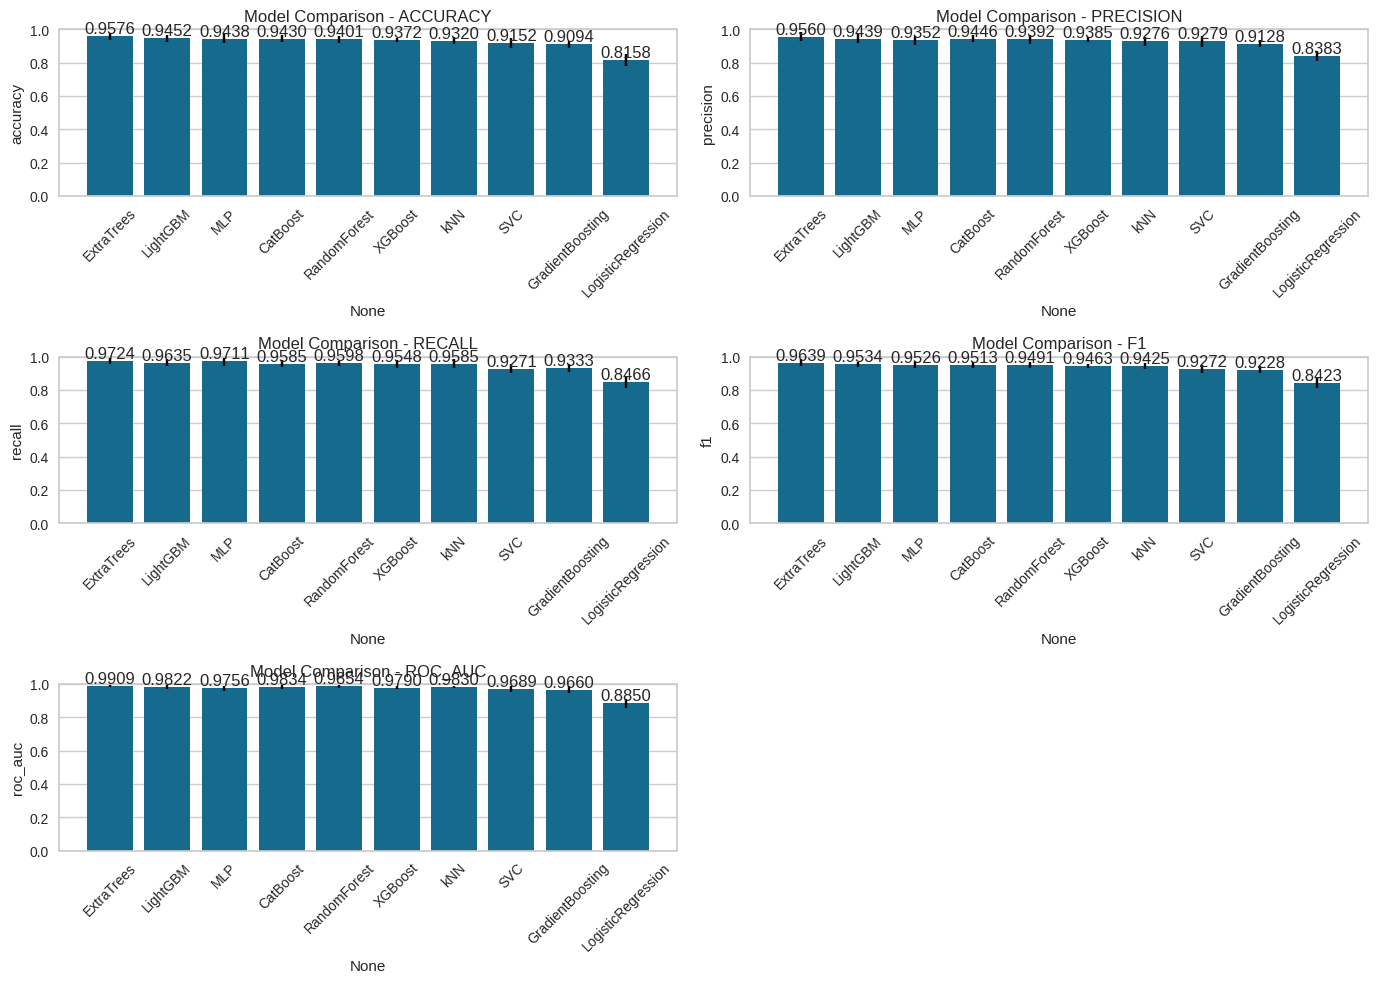


--------------------------------------------------
LOOCV vs 10-fold CV Comparison
--------------------------------------------------


10-fold CV     LOOCV
Model              Metric                         
LogisticRegression accuracy     0.815806  0.855000
                   f1           0.842254  0.875536
                   precision    0.838306  0.864407
                   recall       0.846646  0.886957
RandomForest       accuracy     0.940076  0.890000
                   f1           0.949129  0.900000
                   precision    0.939244  0.900000
                   recall       0.959763  0.900000
kNN                accuracy     0.931983  0.745000
                   f1           0.942459  0.760563
                   precision    0.927647  0.786408
                   recall       0.958465  0.736364

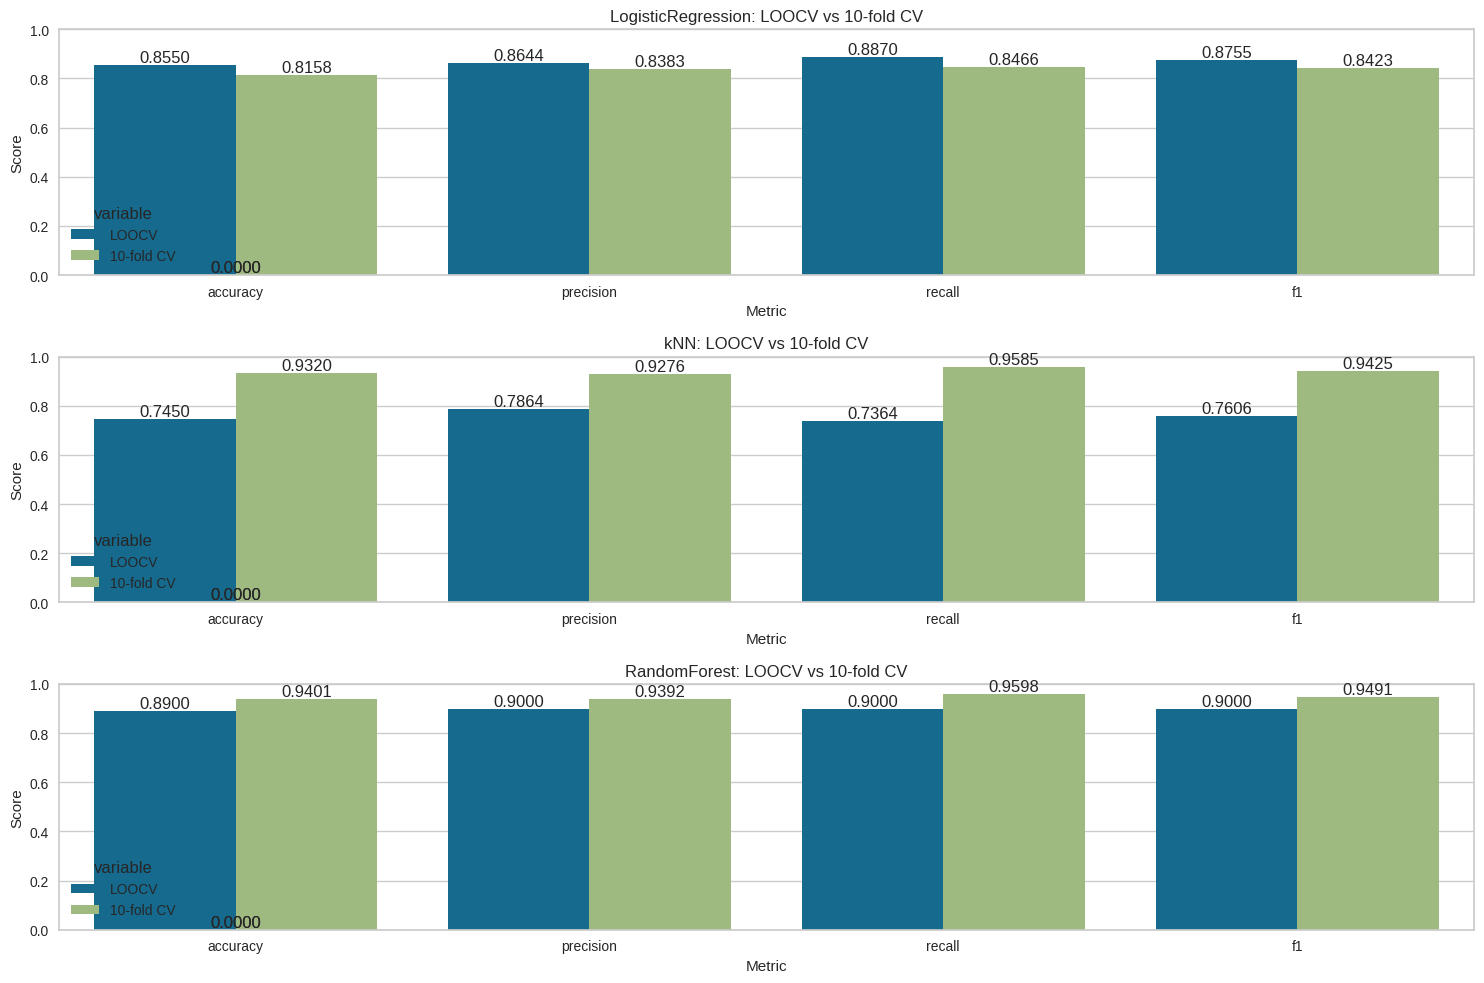


--------------------------------------------------
Outlier Impact Comparison
--------------------------------------------------
▶ Comparing Model Performance With and Without Outliers
Class distribution in original data:
lymphedema
0    1104
1     227
Name: count, dtype: int64
Class distribution after outlier removal:
lymphedema
0    421
1     32
Name: count, dtype: int64
Class distribution in training data with outliers:
lymphedema
1    795
0    573
Name: count, dtype: int64
Class distribution in training data without outliers:
lymphedema
0    336
1     26
Name: count, dtype: int64
Severe imbalance detected (ratio: 12.92) - applying SMOTE to no-outliers dataset
After SMOTE balancing:
lymphedema
1    325
0    257
Name: count, dtype: int64
Predictions distribution (without outliers):
0    87
1     4
Name: count, dtype: int64


,accuracy,precision,recall,f1,roc_auc
With Outliers,0.935860,0.927536,0.964824,0.945813,0.987961
Without Outliers,0.912088,0.250000,0.166667,0.200000,0.634314
Weighted Outliers,0.950437,0.946078,0.969849,0.957816,0.990805


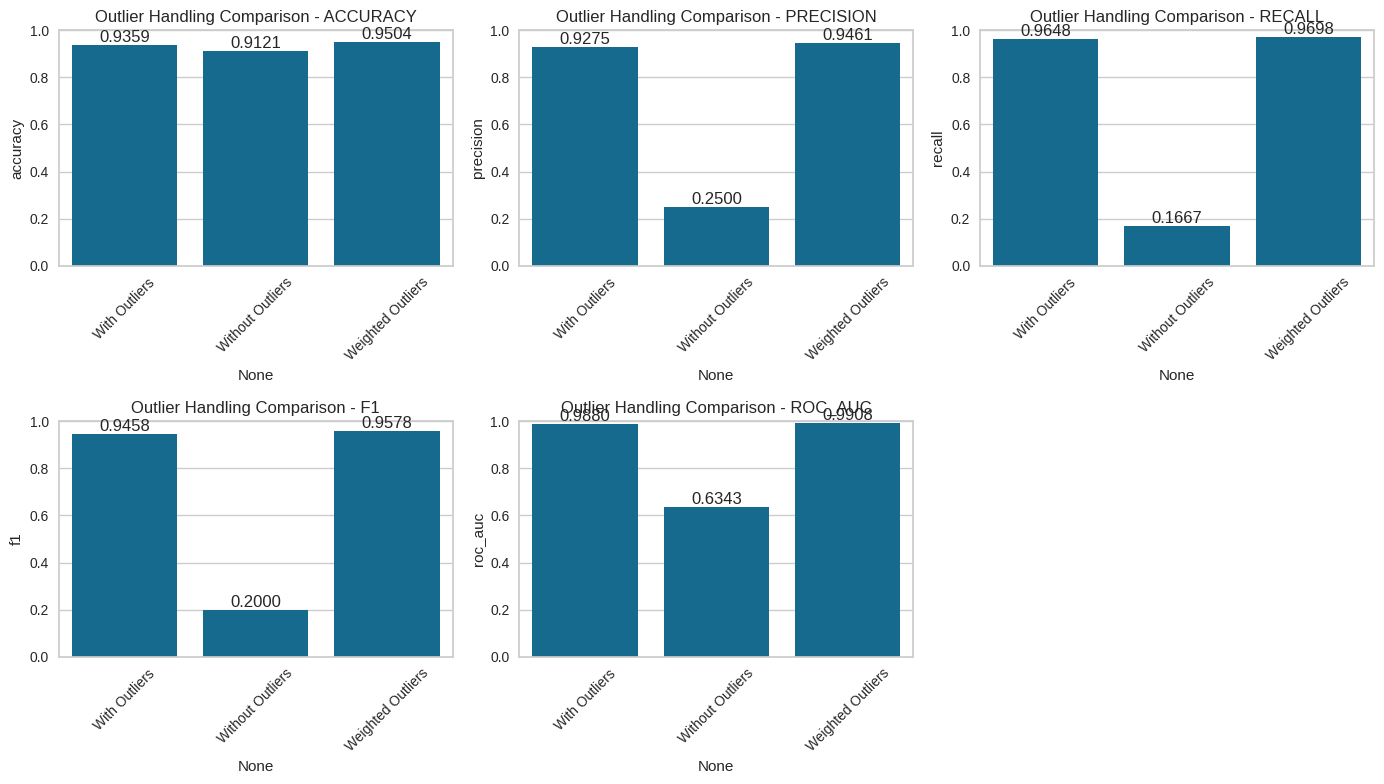

  ✓ Best outlier handling approach: Weighted Outliers
  ✓ Using weighted outliers for further modeling: 


In [ ]:

X_balanced, y_balanced = balanced_data['SMOTE+ENN']
Logger.result("Selected balancing method", "SMOTE+ENN")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Re-calculate outliers on the training set directly
outlier_mask_train = detect_outliers_iqr(X_train, numeric_features)
outlier_rows_train = outlier_mask_train.any(axis=1)

# Create sample weights with double weight for outliers
sample_weights = np.ones(len(X_train))
sample_weights[outlier_rows_train] = 2.0


Logger.result("Train set size", X_train.shape)
Logger.result("Test set size", X_test.shape)

# Define cross-validation strategies
cv_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_loocv = LeaveOneOut()  # For smaller datasets or specific requirements

Logger.result("Cross-validation methods", "10-fold and LOOCV")

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Define base models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate each model
Logger.subsection("Base Model Evaluation with 10-fold CV")
results_10fold = {}

for name, model in models.items():
    Logger.step(f"Training {name}")

    # Train with 10-fold cross-validation
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv_10fold,
        scoring=scoring,
        return_train_score=False
    )

    # Store results
    results_10fold[name] = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean(),
        'roc_auc': cv_results['test_roc_auc'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision_std': cv_results['test_precision'].std(),
        'recall_std': cv_results['test_recall'].std(),
        'f1_std': cv_results['test_f1'].std(),
        'roc_auc_std': cv_results['test_roc_auc'].std()
    }

    # Display results
    for metric, value in results_10fold[name].items():
        if not metric.endswith('_std'):
            Logger.result(f"{metric}", f"{value:.4f} ± {results_10fold[name][metric+'_std']:.4f}")

    # Fit the model on the full training data
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, f"lymphedema_{name.lower()}_model.joblib")
    Logger.result(f"{name} model saved to", f"lymphedema_{name.lower()}_model.joblib")

# LOOCV for a subset of models (computationally intensive)
Logger.subsection("LOOCV Evaluation (on a subset of models)")
results_loocv = {}

# Choose a subset of faster models for LOOCV
loocv_models = {
    'LogisticRegression': models['LogisticRegression'],
    'kNN': models['kNN'],
    'RandomForest': models['RandomForest']
}

# Function to perform LOOCV efficiently
def perform_loocv(model, X, y, name):
    # Use a small sample for LOOCV if the dataset is too large
    if len(X) > 200:
        Logger.result(f"LOOCV for {name}", "Using a subset of 200 samples due to computational constraints")
        sample_idx = np.random.choice(len(X), 200, replace=False)
        X_sample = X.iloc[sample_idx]
        y_sample = y.iloc[sample_idx]
    else:
        X_sample = X
        y_sample = y

    # Predictions and scores
    y_pred = np.zeros_like(y_sample)
    probas = np.zeros_like(y_sample, dtype=float)

    # LOOCV loop
    for train_idx, test_idx in cv_loocv.split(X_sample, y_sample):
        X_train_cv, X_test_cv = X_sample.iloc[train_idx], X_sample.iloc[test_idx]
        y_train_cv = y_sample.iloc[train_idx]

        # Clone and fit model
        m = clone(model)
        m.fit(X_train_cv, y_train_cv)

        # Predict
        y_pred[test_idx] = m.predict(X_test_cv)
        if hasattr(m, "predict_proba"):
            probas[test_idx] = m.predict_proba(X_test_cv)[:, 1]

    # Calculate metrics
    results = {
        'accuracy': accuracy_score(y_sample, y_pred),
        'precision': precision_score(y_sample, y_pred),
        'recall': recall_score(y_sample, y_pred),
        'f1': f1_score(y_sample, y_pred)
    }

    if hasattr(model, "predict_proba"):
        results['roc_auc'] = roc_auc_score(y_sample, probas)

    return results

# Perform LOOCV for selected models
for name, model in loocv_models.items():
    Logger.step(f"LOOCV for {name}")
    results_loocv[name] = perform_loocv(model, X_train, y_train, name)

    # Display results
    for metric, value in results_loocv[name].items():
        Logger.result(f"{metric}", f"{value:.4f}")

# Compare models from 10-fold CV
results_df_10fold = pd.DataFrame(results_10fold).T
# Remove std columns for display
display_cols = [col for col in results_df_10fold.columns if not col.endswith('_std')]
results_df_10fold_display = results_df_10fold[display_cols].sort_values('f1', ascending=False)

# Visualize model comparison
Logger.subsection("Model Comparison - 10-fold CV")
plt.figure(figsize=(14, 10))

# Plot different metrics
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(x=results_df_10fold_display.index, y=results_df_10fold_display[metric])
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Add error bars
    for j, p in enumerate(ax.patches):
        model_name = results_df_10fold_display.index[j]
        stderr = results_df_10fold.loc[model_name, f'{metric}_std']
        ax.errorbar(j, p.get_height(), yerr=stderr, fmt='none', color='black', capsize=3)

        # Add value labels
        ax.annotate(f'{p.get_height():.4f}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Compare LOOCV and 10-fold CV results
if loocv_models:
    Logger.subsection("LOOCV vs 10-fold CV Comparison")

    # Create comparison dataframe
    comparison_data = []
    for model_name in loocv_models.keys():
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            if metric in results_loocv[model_name] and metric in results_10fold[model_name]:
                comparison_data.append({
                    'Model': model_name,
                    'Metric': metric,
                    'LOOCV': results_loocv[model_name][metric],
                    '10-fold CV': results_10fold[model_name][metric]
                })

    comparison_df = pd.DataFrame(comparison_data)

    # Display comparison
    pivot_df = pd.pivot_table(comparison_df, values=['LOOCV', '10-fold CV'],
                             index=['Model', 'Metric'])
    display(pivot_df)

    # Visualize comparison
    plt.figure(figsize=(15, 10))
    for i, model_name in enumerate(loocv_models.keys()):
        model_data = comparison_df[comparison_df['Model'] == model_name]

        plt.subplot(len(loocv_models), 1, i+1)
        model_data_melted = pd.melt(model_data, id_vars=['Model', 'Metric'],
                                    value_vars=['LOOCV', '10-fold CV'])

        ax = sns.barplot(x='Metric', y='value', hue='variable', data=model_data_melted)
        plt.title(f'{model_name}: LOOCV vs 10-fold CV')
        plt.ylabel('Score')
        plt.ylim(0, 1)

        # Add value labels
        for j, p in enumerate(ax.patches):
            ax.annotate(f'{p.get_height():.4f}',
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
# Create datasets with and without outliers for comparison
Logger.subsection("Outlier Impact Comparison")

# Train and evaluate a model with and without outliers
Logger.step("Comparing Model Performance With and Without Outliers")

# Debug: Print class distribution before and after outlier removal
print("Class distribution in original data:")
print(y.value_counts())

print("Class distribution after outlier removal:")
print(y_no_outliers.value_counts())

# Choose a model for comparison
comparison_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Split no-outlier data
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, stratify=y_no_outliers, random_state=42
)

# Debug: Print class distribution in training splits
print("Class distribution in training data with outliers:")
print(y_train.value_counts())

print("Class distribution in training data without outliers:")
print(y_train_no_outliers.value_counts())

# 1. Train and evaluate with outliers (regular data)
comparison_model.fit(X_train, y_train)
y_pred_with_outliers = comparison_model.predict(X_test)
metrics_with_outliers = {
    'accuracy': accuracy_score(y_test, y_pred_with_outliers),
    'precision': precision_score(y_test, y_pred_with_outliers),
    'recall': recall_score(y_test, y_pred_with_outliers),
    'f1': f1_score(y_test, y_pred_with_outliers),
    'roc_auc': roc_auc_score(y_test, comparison_model.predict_proba(X_test)[:, 1])
}

# 2. Train and evaluate without outliers - with fixes for class imbalance
comparison_model_no_outliers = clone(comparison_model)

# Check if class imbalance is severe after outlier removal
imbalance_ratio = y_train_no_outliers.value_counts()[0] / y_train_no_outliers.value_counts()[1] if 1 in y_train_no_outliers.value_counts() else float('inf')

if imbalance_ratio > 10:  # If imbalance ratio > 10
    print(f"Severe imbalance detected (ratio: {imbalance_ratio:.2f}) - applying SMOTE to no-outliers dataset")
    # Use SMOTE+ENN for better handling of boundary cases
    b_smote = SMOTEENN(random_state=42)
    X_train_no_outliers_balanced, y_train_no_outliers_balanced = b_smote.fit_resample(
        X_train_no_outliers, y_train_no_outliers
    )

    # Use the balanced dataset for training
    comparison_model_no_outliers.fit(X_train_no_outliers_balanced, y_train_no_outliers_balanced)
    print("After SMOTE balancing:")
    print(pd.Series(y_train_no_outliers_balanced).value_counts())
else:
    # If not severely imbalanced, just use class weights
    print("Using class weights for 'without outliers' approach")
    class_weights_no_outliers = {
        0: len(y_train_no_outliers) / (2 * (y_train_no_outliers == 0).sum()),
        1: len(y_train_no_outliers) / (2 * (y_train_no_outliers == 1).sum())
    }
    print(f"Class weights: {class_weights_no_outliers}")

    comparison_model_no_outliers = RandomForestClassifier(
        n_estimators=100,
        class_weight=class_weights_no_outliers,
        random_state=42
    )
    comparison_model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

# Make predictions and compute metrics for no outliers approach
y_pred_no_outliers = comparison_model_no_outliers.predict(X_test_no_outliers)

# Debug: Check the distribution of predictions
print("Predictions distribution (without outliers):")
print(pd.Series(y_pred_no_outliers).value_counts())

# Try different threshold if needed
y_proba_no_outliers = comparison_model_no_outliers.predict_proba(X_test_no_outliers)[:, 1]
if sum(y_pred_no_outliers) == 0:  # If all predictions are negative
    print("All predictions are negative. Trying a lower threshold...")
    # Try thresholds from 0.1 to 0.4
    best_f1 = 0
    best_threshold = 0.5
    for threshold in [0.1, 0.2, 0.3, 0.4]:
        y_pred_threshold = (y_proba_no_outliers >= threshold).astype(int)
        if sum(y_pred_threshold) > 0:  # If we have some positive predictions
            f1 = f1_score(y_test_no_outliers, y_pred_threshold)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

    if best_threshold != 0.5:
        print(f"Using threshold of {best_threshold} instead of default 0.5")
        y_pred_no_outliers = (y_proba_no_outliers >= best_threshold).astype(int)
        print("New predictions distribution:")
        print(pd.Series(y_pred_no_outliers).value_counts())

# Calculate metrics for "Without Outliers" approach
metrics_no_outliers = {
    'accuracy': accuracy_score(y_test_no_outliers, y_pred_no_outliers),
    'precision': precision_score(y_test_no_outliers, y_pred_no_outliers, zero_division=0),
    'recall': recall_score(y_test_no_outliers, y_pred_no_outliers, zero_division=0),
    'f1': f1_score(y_test_no_outliers, y_pred_no_outliers, zero_division=0),
    'roc_auc': roc_auc_score(y_test_no_outliers, y_proba_no_outliers)
}

# 3. Train with weighted outliers
comparison_model_weighted = clone(comparison_model)
comparison_model_weighted.fit(X_train, y_train, sample_weight=sample_weights[:len(X_train)])
y_pred_weighted = comparison_model_weighted.predict(X_test)
metrics_weighted = {
    'accuracy': accuracy_score(y_test, y_pred_weighted),
    'precision': precision_score(y_test, y_pred_weighted),
    'recall': recall_score(y_test, y_pred_weighted),
    'f1': f1_score(y_test, y_pred_weighted),
    'roc_auc': roc_auc_score(y_test, comparison_model_weighted.predict_proba(X_test)[:, 1])
}

# Compare results
outlier_comparison = pd.DataFrame({
    'With Outliers': metrics_with_outliers,
    'Without Outliers': metrics_no_outliers,
    'Weighted Outliers': metrics_weighted
}).T

display(outlier_comparison)

# Visualize comparison
plt.figure(figsize=(14, 8))
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=outlier_comparison.index, y=outlier_comparison[metric])
    plt.title(f'Outlier Handling Comparison - {metric.upper()}')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    # Add value labels
    for j, p in enumerate(plt.gca().patches):
        plt.annotate(f'{p.get_height():.4f}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Select the best approach based on F1 score
best_outlier_approach = outlier_comparison['f1'].idxmax()
Logger.result("Best outlier handling approach", best_outlier_approach)

# For subsequent model training, use the best outlier approach
if best_outlier_approach == 'Without Outliers':
    Logger.result("Using dataset without outliers for further modeling", "")
    X_train, X_test, y_train, y_test = X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers
elif best_outlier_approach == 'Weighted Outliers':
    Logger.result("Using weighted outliers for further modeling", "")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, ADASYN
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')


class MissForestImputer(BaseEstimator, TransformerMixin):
    def __init__(self, max_iter=10, random_state=42):
        self.max_iter = max_iter
        self.random_state = random_state
        self.columns = None
        self.numeric_cols = None
        self.categorical_cols = None
        self.rf_regressors = {}
        self.rf_classifiers = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("MissForestImputer requires a pandas DataFrame")

        self.columns = X.columns
        self.numeric_cols = X.select_dtypes(include=['float', 'int']).columns.tolist()
        self.categorical_cols = [col for col in X.columns if col not in self.numeric_cols]

        # Create initial imputation with mean/mode
        df_imputed = X.copy()
        for col in self.numeric_cols:
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col].fillna(df_imputed[col].mean(), inplace=True)
                # Create a regressor for this column
                self.rf_regressors[col] = RandomForestRegressor(
                    n_estimators=100,
                    n_jobs=-1,
                    random_state=self.random_state
                )

        for col in self.categorical_cols:
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col].fillna(df_imputed[col].mode()[0], inplace=True)
                # Create a classifier for this column
                self.rf_classifiers[col] = RandomForestClassifier(
                    n_estimators=100,
                    n_jobs=-1,
                    random_state=self.random_state
                )

        # Iterative imputation
        for _ in range(self.max_iter):
            # Train models for each column with missing values
            for col in self.numeric_cols:
                if col in self.rf_regressors:
                    X_train = df_imputed.drop(columns=[col])
                    y_train = df_imputed[col]
                    self.rf_regressors[col].fit(X_train, y_train)

            for col in self.categorical_cols:
                if col in self.rf_classifiers:
                    X_train = df_imputed.drop(columns=[col])
                    y_train = df_imputed[col]
                    self.rf_classifiers[col].fit(X_train, y_train)

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("MissForestImputer requires a pandas DataFrame")

        df_imputed = X.copy()

        # Perform initial mean/mode imputation
        for col in self.numeric_cols:
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col].fillna(df_imputed[col].mean(), inplace=True)

        for col in self.categorical_cols:
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col].fillna(df_imputed[col].mode()[0], inplace=True)

        # Predict missing values using trained models
        for col in self.numeric_cols:
            if col in self.rf_regressors:
                mask = X[col].isnull()
                if mask.sum() > 0:
                    X_miss = df_imputed.loc[mask].drop(columns=[col])
                    df_imputed.loc[mask, col] = self.rf_regressors[col].predict(X_miss)

        for col in self.categorical_cols:
            if col in self.rf_classifiers:
                mask = X[col].isnull()
                if mask.sum() > 0:
                    X_miss = df_imputed.loc[mask].drop(columns=[col])
                    df_imputed.loc[mask, col] = self.rf_classifiers[col].predict(X_miss)

        return df_imputed

# Enhanced Feature Selection that combines LASSO and Random Forest
class EnhancedFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, lasso_alpha=0.1, rf_threshold='mean', random_state=42):
        self.lasso_alpha = lasso_alpha
        self.rf_threshold = rf_threshold
        self.random_state = random_state
        self.selected_features = None
        self.lasso = None
        self.rf = None

    def fit(self, X, y=None):
        if y is None:
            # Can't train models without target
            self.selected_features = X.columns if isinstance(X, pd.DataFrame) else list(range(X.shape[1]))
            return self

        # Initialize models
        self.lasso = LassoCV(cv=5, random_state=self.random_state, max_iter=10000)
        self.rf = RandomForestClassifier(n_estimators=100, random_state=self.random_state)

        if isinstance(X, pd.DataFrame):
            # LASSO feature selection
            self.lasso.fit(X, y)
            lasso_features = X.columns[np.abs(self.lasso.coef_) > 0].tolist()

            # Random Forest feature selection
            self.rf.fit(X, y)
            rf_selector = SelectFromModel(self.rf, threshold=self.rf_threshold)
            rf_selector.fit(X, y)
            rf_features = X.columns[rf_selector.get_support()].tolist()

            # Combine selected features
            self.selected_features = list(set(lasso_features + rf_features))
        else:
            # For numpy arrays, just use random forest
            self.rf.fit(X, y)
            rf_selector = SelectFromModel(self.rf, threshold=self.rf_threshold)
            rf_selector.fit(X, y)
            self.selected_features = np.where(rf_selector.get_support())[0].tolist()

        return self

    def transform(self, X):
        if self.selected_features is None:
            return X

        if isinstance(X, pd.DataFrame):
            return X[self.selected_features]
        else:
            # For numpy arrays
            return X[:, self.selected_features]

# Advanced SMOTE variant selector
class AdvancedSMOTE(BaseEstimator, TransformerMixin):
    def __init__(self, method='smote_enn', random_state=42, sampling_strategy='auto'):
        self.method = method
        self.random_state = random_state
        self.sampling_strategy = sampling_strategy
        self.sampler = None

    def fit(self, X, y=None):
        if self.method == 'smote_enn':
            self.sampler = SMOTEENN(random_state=self.random_state, sampling_strategy=self.sampling_strategy)
        elif self.method == 'smote_tomek':
            self.sampler = SMOTETomek(random_state=self.random_state, sampling_strategy=self.sampling_strategy)
        elif self.method == 'borderline_smote':
            self.sampler = BorderlineSMOTE(random_state=self.random_state, sampling_strategy=self.sampling_strategy)
        elif self.method == 'svm_smote':
            self.sampler = SVMSMOTE(random_state=self.random_state, sampling_strategy=self.sampling_strategy)
        elif self.method == 'adasyn':
            self.sampler = ADASYN(random_state=self.random_state, sampling_strategy=self.sampling_strategy)
        else:
            raise ValueError(f"Unknown SMOTE method: {self.method}")

        if y is not None:
            self.sampler.fit_resample(X, y)

        return self

    def transform(self, X, y=None):
        # SMOTE doesn't transform without y, so just return X
        return X

    def fit_resample(self, X, y):
        return self.sampler.fit_resample(X, y)

# Enhanced Feature Engineering that creates more interactions
class EnhancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            if self.feature_names is not None:
                X = pd.DataFrame(X, columns=self.feature_names)
            else:
                return X

        df = X.copy()

        # Create age-related features
        if 'Age' in df.columns:
            df['Age_Squared'] = df['Age'] ** 2
            try:
                df['Age_Group'] = pd.qcut(df['Age'], q=4, labels=[0, 1, 2, 3]).astype(float)
            except:
                df['Age_Group'] = pd.cut(df['Age'], bins=4, labels=[0, 1, 2, 3]).astype(float)

        # Create BMI-Age interaction
        if 'BMI' in df.columns and 'Age' in df.columns:
            df['BMI_Age_Interaction'] = df['BMI'] * df['Age']

        # Create treatment and clinical feature interactions
        treatment_cols = [col for col in df.columns if col in ['chemotherapy', 'Radiotherapy', 'Hormanal']]
        clinical_cols = [col for col in df.columns if col in ['T', 'N', 'M', 'Peritumoural.lymphovascular.invasion']]

        for t_col in treatment_cols:
            for c_col in clinical_cols:
                if t_col in df.columns and c_col in df.columns:
                    df[f'{t_col}_{c_col}_Interaction'] = df[t_col] * df[c_col]

        # Add lymphedema risk factors interactions
        risk_factors = [col for col in df.columns if col in ['BMI', 'T', 'N', 'Peritumoural.lymphovascular.invasion']]
        for i, factor1 in enumerate(risk_factors):
            for factor2 in risk_factors[i+1:]:
                if factor1 in df.columns and factor2 in df.columns:
                    df[f'{factor1}_{factor2}_Interaction'] = df[factor1] * df[factor2]

        # Clinical severity composite score (if applicable columns exist)
        clinical_severity = ['T', 'N', 'M', 'Peritumoural.lymphovascular.invasion']
        if all(col in df.columns for col in clinical_severity):
            # Weight T and N more heavily as they're likely more important for lymphedema
            df['Clinical_Severity_Score'] = df['T']*2 + df['N']*2 + df['M'] + df['Peritumoural.lymphovascular.invasion']

        return df

# Define enhanced preprocessing pipeline with MissForest
def create_enhanced_preprocessing_pipeline():
    return Pipeline([
        ('drop_columns', ColumnDropper()),
        ('categorical_encoder', CategoricalEncoder()),
        ('missforest_imputer', MissForestImputer(max_iter=10, random_state=42)),
        ('enhanced_feature_engineer', EnhancedFeatureEngineer()),
        ('scaler', DataFrameScaler()),
        ('correlation_selector', CorrelationSelector(threshold=0.8)),
    ])

# Create optimized stacking model based on the best models from your notebook
def create_stacking_model():
    # First-level estimators from your top models
    estimators = [
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42
        )),
        ('xgb', xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=2.0,
            random_state=42
        )),
        ('lgb', lgb.LGBMClassifier(
            n_estimators=150,
            max_depth=8,
            learning_rate=0.08,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            is_unbalance=True,
            random_state=42
        )),
        ('gbc', GradientBoostingClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        ))
    ]

    # Meta-learner
    final_estimator = LogisticRegression(C=1.0, class_weight='balanced', random_state=42)

    # Stacking classifier
    return StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1
    )

# Create an ensemble voting model (alternative approach from your best models)
def create_voting_model():
    # Base estimators from your top models
    estimators = [
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42
        )),
        ('xgb', xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=2.0,
            random_state=42
        )),
        ('lgb', lgb.LGBMClassifier(
            n_estimators=150,
            max_depth=8,
            learning_rate=0.08,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            is_unbalance=True,
            random_state=42
        )),
        ('cat', CatBoostClassifier(
            iterations=200,
            depth=6,
            learning_rate=0.1,
            l2_leaf_reg=3,
            auto_class_weights='Balanced',
            random_seed=42,
            verbose=0
        ))
    ]

    # Voting classifier with soft voting and weights
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[1.5, 1.2, 1.0, 1.0]  # Higher weight to the best performing models
    )

# Define enhanced model pipeline with SMOTEENN (best resampling approach from your notebook)
def create_enhanced_model_pipeline():
    return ImbPipeline([
        ('advanced_smote', AdvancedSMOTE(method='smote_enn', random_state=42)),
        ('stacking_model', create_stacking_model())
    ])

# Combine enhanced preprocessor and model
def create_enhanced_full_pipeline():
    return Pipeline([
        ('enhanced_preprocessor', create_enhanced_preprocessing_pipeline()),
        ('enhanced_model', create_enhanced_model_pipeline())
    ])

# Alternative pipeline with voting classifier
def create_voting_full_pipeline():
    return Pipeline([
        ('enhanced_preprocessor', create_enhanced_preprocessing_pipeline()),
        ('smote_enn', AdvancedSMOTE(method='smote_enn', random_state=42)),
        ('voting_model', create_voting_model())
    ])

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import optuna
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            matthews_corrcoef)
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                            GradientBoostingClassifier, VotingClassifier,
                            StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Logger.section("Hyperparameter Tuning with Optuna")

# Choose top 3 models for hyperparameter tuning based on F1 score
# top_models = results_df_10fold_display.head(3).index.tolist()
top_models = ['RandomForest']

Logger.result("Selected models for tuning", top_models)

# Define objective functions for each model type
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_balanced_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Use safer sampling strategy options that won't cause errors
    # 'auto' and 'majority' are safer than specific float values
    sampling_strategy = trial.suggest_categorical('sampling_strategy', ['auto', 'majority', 'not minority'])
    replacement = trial.suggest_categorical('replacement', [True, False])

    model = BalancedRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        sampling_strategy=sampling_strategy,
        replacement=replacement,
        random_state=42
    )

    # Add error handling to better diagnose issues
    try:
        scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
        return scores.mean()
    except Exception as e:
        print(f"Error with parameters: {trial.params}")
        print(f"Error message: {str(e)}")
        # Return a very low score to indicate failure
        return float('-inf')

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0.0, 5.0)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 30)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    is_unbalance = trial.suggest_categorical('is_unbalance', [True, False])
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0) if not is_unbalance else 1.0

    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        is_unbalance=is_unbalance,
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_catboost(trial):
    iterations = trial.suggest_int('iterations', 50, 500)
    depth = trial.suggest_int('depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True)
    border_count = trial.suggest_int('border_count', 32, 255)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 10.0)
    auto_class_weights = trial.suggest_categorical('auto_class_weights', ['Balanced', None])

    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        border_count=border_count,
        bagging_temperature=bagging_temperature,
        auto_class_weights=auto_class_weights,
        random_seed=42,
        verbose=0
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_et(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_gbc(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_svc(trial):
    C = trial.suggest_float('C', 1e-5, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Conditional parameters based on kernel
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    else:
        degree = 3

    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree if kernel == 'poly' else 3,
        class_weight=class_weight,
        probability=True,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)  # Manhattan or Euclidean distance

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_mlp(trial):
    # Create the hidden_layer_sizes parameter
    hidden_layer_sizes = []
    n_layers = trial.suggest_int('n_layers', 1, 3)

    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 10, 200)
        hidden_layer_sizes.append(n_units)

    # Create the model with only valid parameters
    model = MLPClassifier(
        hidden_layer_sizes=tuple(hidden_layer_sizes),
        alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        learning_rate_init=trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        activation=trial.suggest_categorical('activation', ['tanh', 'relu']),
        solver=trial.suggest_categorical('solver', ['adam', 'sgd']),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    )

    # Store the hidden_layer_sizes in the trial user attributes so we can access it later
    trial.set_user_attr('hidden_layer_sizes', hidden_layer_sizes)

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_balanced_bagging(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    sampling_strategy = trial.suggest_categorical('sampling_strategy', ['auto', 'majority', 'not minority', 'not majority', 0.5, 0.75, 1.0])
    replacement = trial.suggest_categorical('replacement', [True, False])

    base_estimator = DecisionTreeClassifier(random_state=42)

    model = BalancedBaggingClassifier(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        sampling_strategy=sampling_strategy,
        replacement=replacement,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_stacking(trial):
    # Define base estimators
    rf_estimator = RandomForestClassifier(
        n_estimators=trial.suggest_int('rf_n_estimators', 50, 200),
        max_depth=trial.suggest_int('rf_max_depth', 3, 10),
        random_state=42
    )

    xgb_estimator = xgb.XGBClassifier(
        n_estimators=trial.suggest_int('xgb_n_estimators', 50, 200),
        max_depth=trial.suggest_int('xgb_max_depth', 3, 8),
        learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 0.2, log=True),
        random_state=42
    )

    lgb_estimator = lgb.LGBMClassifier(
        n_estimators=trial.suggest_int('lgb_n_estimators', 50, 200),
        max_depth=trial.suggest_int('lgb_max_depth', 3, 8),
        learning_rate=trial.suggest_float('lgb_learning_rate', 0.01, 0.2, log=True),
        random_state=42
    )

    # Configure final estimator
    final_estimator_type = trial.suggest_categorical('final_estimator_type', ['lr', 'rf', 'svc'])

    if final_estimator_type == 'lr':
        final_estimator = LogisticRegression(
            C=trial.suggest_float('lr_C', 0.1, 10.0, log=True),
            random_state=42
        )
    elif final_estimator_type == 'rf':
        final_estimator = RandomForestClassifier(
            n_estimators=trial.suggest_int('final_rf_n_estimators', 50, 200),
            max_depth=trial.suggest_int('final_rf_max_depth', 3, 10),
            random_state=42
        )
    else:  # 'svc'
        final_estimator = SVC(
            C=trial.suggest_float('svc_C', 0.1, 10.0, log=True),
            probability=True,
            random_state=42
        )

    # Build stacking model
    estimators = [
        ('rf', rf_estimator),
        ('xgb', xgb_estimator),
        ('lgb', lgb_estimator)
    ]

    model = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_voting(trial):
    # Define base estimators
    rf_weight = trial.suggest_float('rf_weight', 0.1, 2.0)
    xgb_weight = trial.suggest_float('xgb_weight', 0.1, 2.0)
    lgb_weight = trial.suggest_float('lgb_weight', 0.1, 2.0)

    rf_estimator = RandomForestClassifier(
        n_estimators=trial.suggest_int('rf_n_estimators', 50, 200),
        max_depth=trial.suggest_int('rf_max_depth', 3, 10),
        random_state=42
    )

    xgb_estimator = xgb.XGBClassifier(
        n_estimators=trial.suggest_int('xgb_n_estimators', 50, 200),
        max_depth=trial.suggest_int('xgb_max_depth', 3, 8),
        learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 0.2, log=True),
        random_state=42
    )

    lgb_estimator = lgb.LGBMClassifier(
        n_estimators=trial.suggest_int('lgb_n_estimators', 50, 200),
        max_depth=trial.suggest_int('lgb_max_depth', 3, 8),
        learning_rate=trial.suggest_float('lgb_learning_rate', 0.01, 0.2, log=True),
        random_state=42
    )

    voting_type = trial.suggest_categorical('voting_type', ['soft', 'hard'])

    estimators = [
        ('rf', rf_estimator),
        ('xgb', xgb_estimator),
        ('lgb', lgb_estimator)
    ]

    weights = [rf_weight, xgb_weight, lgb_weight]

    model = VotingClassifier(
        estimators=estimators,
        voting=voting_type,
        weights=weights if voting_type == 'soft' else None
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_feature_selection_pipeline(trial):
    # Select model type
    model_type = trial.suggest_categorical('model_type', ['rf', 'xgb', 'lgbm'])

    # Select feature selection method
    fs_method = trial.suggest_categorical('fs_method', ['none', 'selectfrommodel', 'rfe', 'pca'])

    # Configure feature selection based on method
    if fs_method == 'selectfrommodel':
        fs_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
        threshold = trial.suggest_categorical('threshold', ['mean', 'median', '0.5*mean'])
        fs = SelectFromModel(estimator=fs_estimator, threshold=threshold)
    elif fs_method == 'rfe':
        fs_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
        n_features_to_select = trial.suggest_int('n_features_to_select',
                                               max(1, int(X_train.shape[1] * 0.3)),
                                               max(2, int(X_train.shape[1] * 0.8)))
        fs = RFE(estimator=fs_estimator, n_features_to_select=n_features_to_select)
    elif fs_method == 'pca':
        n_components = trial.suggest_int('n_components',
                                       max(1, int(X_train.shape[1] * 0.3)),
                                       max(2, int(X_train.shape[1] * 0.8)))
        fs = PCA(n_components=n_components)
    else:  # 'none'
        fs = None

    # Configure classifier based on type
    if model_type == 'rf':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 15),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
            max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            class_weight=trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
            random_state=42
        )
    elif model_type == 'xgb':
        model = xgb.XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            subsample=trial.suggest_float('subsample', 0.6, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1.0, 10.0),
            random_state=42
        )
    else:  # 'lgbm'
        model = lgb.LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 20, 100),
            subsample=trial.suggest_float('subsample', 0.6, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
            min_child_samples=trial.suggest_int('min_child_samples', 5, 30),
            is_unbalance=trial.suggest_categorical('is_unbalance', [True, False]),
            random_state=42
        )

    # Build pipeline
    steps = []
    if fs is not None:
        steps.append(('feature_selection', fs))
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    scores = cross_val_score(pipeline, X_train, y_train, cv=cv_10fold, scoring='f1')
    return scores.mean()

def objective_smote_pipeline(trial):
    # Select model type
    model_type = trial.suggest_categorical('model_type', ['rf', 'xgb', 'lgbm'])

    # SMOTE parameters - using safer options that won't cause errors
    # Avoid float values that might cause problems
    sampling_strategy = trial.suggest_categorical('sampling_strategy',
                                               ['auto', 'minority', 'not majority'])
    k_neighbors = trial.suggest_int('k_neighbors', 5, 10)

    # Configure SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy,
                  k_neighbors=k_neighbors,
                  random_state=42)

    # Configure classifier based on type
    if model_type == 'rf':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 15),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            random_state=42
        )
    elif model_type == 'xgb':
        model = xgb.XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            random_state=42
        )
    else:  # 'lgbm'
        model = lgb.LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            random_state=42
        )

    # Build pipeline
    pipeline = Pipeline([
        ('smote', smote),
        ('model', model)
    ])

    # Add error handling
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv_10fold, scoring='f1')
        return scores.mean()
    except Exception as e:
        print(f"Error with parameters: {trial.params}")
        print(f"Error message: {str(e)}")
        # Return a very low score instead of failing
        return float('-inf')

# Create mapping of model names to objective functions
objective_funcs = {
    'RandomForest': objective_rf,
    'ExtraTrees': objective_et,
    'GradientBoosting': objective_gbc,
    'SVC': objective_svc,
    'XGBoost': objective_xgb,
    'LightGBM': objective_lgbm,
    'CatBoost': objective_catboost,
    'kNN': objective_knn,
    'MLP': objective_mlp,
    'BalancedRandomForest': objective_balanced_rf,
    'BalancedBagging': objective_balanced_bagging,
    'StackingClassifier': objective_stacking,
    'VotingClassifier': objective_voting,
    'FeatureSelectionPipeline': objective_feature_selection_pipeline,
    'SMOTEPipeline': objective_smote_pipeline
}

# Add the most powerful models to the top models list to ensure they're tuned
advanced_models = [
    'BalancedRandomForest',
    'StackingClassifier',
    'VotingClassifier',
    'FeatureSelectionPipeline',
    'SMOTEPipeline'
]

# Include the advanced models for tuning
for model in advanced_models:
    if model not in top_models:
        top_models.append(model)

Logger.result("Updated models for tuning", top_models)

# Perform hyperparameter optimization
Logger.subsection("Optimizing Hyperparameters")
best_params = {}
best_scores = {}
best_models = {}

for model_name in top_models:
    if model_name not in objective_funcs:
        Logger.result(f"Skipping {model_name}", "No objective function defined")
        continue

    Logger.step(f"Optimizing {model_name}")

    # Create a study object and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_funcs[model_name], n_trials=50)

    # Record best parameters and score
    best_params[model_name] = study.best_params
    best_scores[model_name] = study.best_value

    Logger.result(f"Best score", f"{study.best_value:.4f}")
    Logger.result(f"Best parameters", study.best_params)

    # Create and fit the model with best parameters
    if model_name == 'RandomForest':
        best_model = RandomForestClassifier(
            **study.best_params,
            random_state=42
        )
    elif model_name == 'ExtraTrees':
        best_model = ExtraTreesClassifier(
            **study.best_params,
            random_state=42
        )
    elif model_name == 'GradientBoosting':
        best_model = GradientBoostingClassifier(
            **study.best_params,
            random_state=42
        )
    elif model_name == 'SVC':
        best_model = SVC(
            **study.best_params,
            probability=True,
            random_state=42
        )
    elif model_name == 'XGBoost':
        best_model = xgb.XGBClassifier(
            **study.best_params,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )
    elif model_name == 'LightGBM':
        best_model = lgb.LGBMClassifier(
            **study.best_params,
            random_state=42
        )
    elif model_name == 'CatBoost':
        best_model = CatBoostClassifier(
            **study.best_params,
            random_seed=42,
            verbose=0
        )
    elif model_name == 'kNN':
        best_model = KNeighborsClassifier(
            **study.best_params
        )
    elif model_name == 'MLP':
        # Get the parameters that are valid for MLPClassifier
        mlp_params = {
            'alpha': study.best_params['alpha'],
            'learning_rate_init': study.best_params['learning_rate_init'],
            'activation': study.best_params['activation'],
            'solver': study.best_params['solver'] if 'solver' in study.best_params else 'adam',
            'hidden_layer_sizes': tuple(study.best_trial.user_attrs['hidden_layer_sizes'])
        }

        best_model = MLPClassifier(
            **mlp_params,
            max_iter=1000,
            early_stopping=True,
            random_state=42
        )
    elif model_name == 'BalancedRandomForest':
        best_model = BalancedRandomForestClassifier(
            **study.best_params,
            random_state=42
        )
    elif model_name == 'BalancedBagging':
        base_estimator = DecisionTreeClassifier(random_state=42)
        best_model = BalancedBaggingClassifier(
            base_estimator=base_estimator,
            **study.best_params,
            random_state=42
        )
    elif model_name == 'StackingClassifier':
        # Extract parameters for base estimators
        rf_params = {k.replace('rf_', ''): v for k, v in study.best_params.items() if k.startswith('rf_') and not k.startswith('final_rf_')}
        xgb_params = {k.replace('xgb_', ''): v for k, v in study.best_params.items() if k.startswith('xgb_')}
        lgb_params = {k.replace('lgb_', ''): v for k, v in study.best_params.items() if k.startswith('lgb_')}

        # Create base estimators
        rf_estimator = RandomForestClassifier(**rf_params, random_state=42)
        xgb_estimator = xgb.XGBClassifier(**xgb_params, random_state=42)
        lgb_estimator = lgb.LGBMClassifier(**lgb_params, random_state=42)

        # Configure final estimator
        final_estimator_type = study.best_params['final_estimator_type']
        if final_estimator_type == 'lr':
            final_estimator = LogisticRegression(C=study.best_params['lr_C'], random_state=42)
        elif final_estimator_type == 'rf':
            final_rf_params = {k.replace('final_rf_', ''): v for k, v in study.best_params.items() if k.startswith('final_rf_')}
            final_estimator = RandomForestClassifier(**final_rf_params, random_state=42)
        else:  # 'svc'
            final_estimator = SVC(C=study.best_params['svc_C'], probability=True, random_state=42)

        # Build stacking model
        estimators = [
            ('rf', rf_estimator),
            ('xgb', xgb_estimator),
            ('lgb', lgb_estimator)
        ]

        best_model = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=5,
            n_jobs=-1
        )
    elif model_name == 'VotingClassifier':
        # Extract parameters for base estimators
        rf_params = {k.replace('rf_', ''): v for k, v in study.best_params.items() if k.startswith('rf_') and k != 'rf_weight'}
        xgb_params = {k.replace('xgb_', ''): v for k, v in study.best_params.items() if k.startswith('xgb_') and k != 'xgb_weight'}
        lgb_params = {k.replace('lgb_', ''): v for k, v in study.best_params.items() if k.startswith('lgb_') and k != 'lgb_weight'}

        # Create base estimators
        rf_estimator = RandomForestClassifier(**rf_params, random_state=42)
        xgb_estimator = xgb.XGBClassifier(**xgb_params, random_state=42)
        lgb_estimator = lgb.LGBMClassifier(**lgb_params, random_state=42)

        # Build voting model
        estimators = [
            ('rf', rf_estimator),
            ('xgb', xgb_estimator),
            ('lgb', lgb_estimator)
        ]

        weights = [study.best_params['rf_weight'], study.best_params['xgb_weight'], study.best_params['lgb_weight']]
        voting_type = study.best_params['voting_type']

        best_model = VotingClassifier(
            estimators=estimators,
            voting=voting_type,
            weights=weights if voting_type == 'soft' else None
        )
    elif model_name == 'FeatureSelectionPipeline':
        # Extract parameters
        model_type = study.best_params['model_type']
        fs_method = study.best_params['fs_method']

        # Remove method selection parameters
        model_params = {k: v for k, v in study.best_params.items()
                      if k not in ['model_type', 'fs_method', 'threshold', 'n_features_to_select', 'n_components']}

        # Configure feature selection
        if fs_method == 'selectfrommodel':
            fs_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
            threshold = study.best_params['threshold']
            fs = SelectFromModel(estimator=fs_estimator, threshold=threshold)
        elif fs_method == 'rfe':
            fs_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
            n_features = study.best_params['n_features_to_select']
            fs = RFE(estimator=fs_estimator, n_features_to_select=n_features)
        elif fs_method == 'pca':
            n_components = study.best_params['n_components']
            fs = PCA(n_components=n_components)
        # Continuing the FeatureSelectionPipeline model creation
    elif model_name == 'FeatureSelectionPipeline':
        # Extract parameters
        model_type = study.best_params['model_type']
        fs_method = study.best_params['fs_method']

        # Remove method selection parameters
        model_params = {k: v for k, v in study.best_params.items()
                      if k not in ['model_type', 'fs_method', 'threshold', 'n_features_to_select', 'n_components']}

        # Configure feature selection
        if fs_method == 'selectfrommodel':
            fs_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
            threshold = study.best_params['threshold']
            fs = SelectFromModel(estimator=fs_estimator, threshold=threshold)
        elif fs_method == 'rfe':
            fs_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
            n_features = study.best_params['n_features_to_select']
            fs = RFE(estimator=fs_estimator, n_features_to_select=n_features)
        elif fs_method == 'pca':
            n_components = study.best_params['n_components']
            fs = PCA(n_components=n_components)
        else:  # 'none'
            fs = None

        # Configure model
        if model_type == 'rf':
            model = RandomForestClassifier(**model_params, random_state=42)
        elif model_type == 'xgb':
            model = xgb.XGBClassifier(**model_params, random_state=42)
        else:  # 'lgbm'
            model = lgb.LGBMClassifier(**model_params, random_state=42)

        # Build pipeline
        steps = []
        if fs is not None:
            steps.append(('feature_selection', fs))
        steps.append(('model', model))

        best_model = Pipeline(steps)

    elif model_name == 'SMOTEPipeline':
        # Extract parameters
        model_type = study.best_params['model_type']

        # SMOTE parameters
        sampling_strategy = study.best_params['sampling_strategy']
        k_neighbors = study.best_params['k_neighbors']

        # Remove SMOTE and model type parameters
        model_params = {k: v for k, v in study.best_params.items()
                      if k not in ['model_type', 'sampling_strategy', 'k_neighbors']}

        # Configure SMOTE
        smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=42)

        # Configure model
        if model_type == 'rf':
            model = RandomForestClassifier(**model_params, random_state=42)
        elif model_type == 'xgb':
            model = xgb.XGBClassifier(**model_params, random_state=42)
        else:  # 'lgbm'
            model = lgb.LGBMClassifier(**model_params, random_state=42)

        # Build pipeline
        best_model = Pipeline([
            ('smote', smote),
            ('model', model)
        ])

    # Fit the model
    best_model.fit(X_train, y_train)
    best_models[model_name] = best_model

    # Save the model
    joblib.dump(best_model, f"lymphedema_{model_name.lower()}_optimized.joblib")
    Logger.result(f"Optimized model saved to", f"lymphedema_{model_name.lower()}_optimized.joblib")

    # Also save in pkl format as requested
    with open(f"lymphedema_{model_name.lower()}_optimized.pkl", 'wb') as f:
        pickle.dump(best_model, f)
    Logger.result(f"Optimized model also saved to", f"lymphedema_{model_name.lower()}_optimized.pkl")

# Compare optimized models
Logger.subsection("Optimized Model Comparison")

# Evaluate each optimized model on the test set
optimized_results = {}

for name, model in best_models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate standard metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Calculate additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Calculate micro, macro, and weighted averages (even for binary)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    precision_weighted = precision_score(y_test, y_pred, average='weighted')

    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')

    # Store all results
    optimized_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'mcc': mcc,
        'roc_auc': roc_auc,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted
    }

    # Display results
    Logger.result(f"{name} Test Performance", "")
    for metric, value in optimized_results[name].items():
        if value is not None:
            Logger.result(f"{metric}", f"{value:.4f}")

# Create a DataFrame for visualization
optimized_results_df = pd.DataFrame(optimized_results).T

# Add average rankings across metrics
metric_columns = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc']
if 'roc_auc' in optimized_results_df.columns and not optimized_results_df['roc_auc'].isna().any():
    metric_columns.append('roc_auc')

for col in metric_columns:
    optimized_results_df[f'{col}_rank'] = optimized_results_df[col].rank(ascending=False)

optimized_results_df['avg_rank'] = optimized_results_df[[f'{col}_rank' for col in metric_columns]].mean(axis=1)
optimized_results_df = optimized_results_df.sort_values('avg_rank')

# Display the full comparison table
display(optimized_results_df[metric_columns + ['avg_rank']])

# Visualize optimized model comparison
plt.figure(figsize=(14, 10))

# Plot different metrics
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc']):
    plt.subplot(3, 2, i+1)
    data = optimized_results_df[metric].dropna()
    sns.barplot(x=data.index, y=data.values)
    plt.title(f'Optimized Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Add value labels
    for j, p in enumerate(plt.gca().patches):
        plt.gca().annotate(f'{p.get_height():.4f}',
                      (p.get_x() + p.get_width()/2., p.get_height()),
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create detailed comparison of micro, macro, and weighted averages
micro_macro_weighted_df = pd.DataFrame()

for name in optimized_results_df.index:
    model_results = optimized_results[name]
    metrics_data = {
        'Model': name,
        'F1 (Micro)': model_results['f1_micro'],
        'F1 (Macro)': model_results['f1_macro'],
        'F1 (Weighted)': model_results['f1_weighted'],
        'Precision (Micro)': model_results['precision_micro'],
        'Precision (Macro)': model_results['precision_macro'],
        'Precision (Weighted)': model_results['precision_weighted'],
        'Recall (Micro)': model_results['recall_micro'],
        'Recall (Macro)': model_results['recall_macro'],
        'Recall (Weighted)': model_results['recall_weighted']
    }
    micro_macro_weighted_df = pd.concat([micro_macro_weighted_df, pd.DataFrame([metrics_data])], ignore_index=True)

# Display the detailed comparison
display(micro_macro_weighted_df)

# Filter models with F1 score above 0.95 (95%)
high_performing_models = optimized_results_df[optimized_results_df['f1'] >= 0.95]

if len(high_performing_models) > 0:
    Logger.subsection("Models with F1 Score >= 0.95")
    display(high_performing_models[metric_columns])

    # Visualize high-performing models
    plt.figure(figsize=(12, 6))
    sns.barplot(x=high_performing_models.index, y=high_performing_models['f1'])
    plt.title('Models with F1 Score >= 0.95')
    plt.xticks(rotation=45)
    plt.ylim(0.94, 1.0)

    # Add value labels
    for i, p in enumerate(plt.gca().patches):
        plt.gca().annotate(f'{p.get_height():.4f}',
                      (p.get_x() + p.get_width()/2., p.get_height()),
                      ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    Logger.subsection("No Models Achieved F1 Score >= 0.95")

    # Find the best performing model
    best_model_name = optimized_results_df.iloc[0].name
    best_f1 = optimized_results_df.iloc[0]['f1']

    Logger.result("Best Model", f"{best_model_name} (F1 = {best_f1:.4f})")

    # Try to create an ensemble of the top 3 models
    Logger.subsection("Creating Ensemble of Top Models to Reach F1 >= 0.95")

    # Get top 3 models
    top3_models = list(optimized_results_df.index[:3])

    # Create a soft voting ensemble
    estimators = []
    for name in top3_models:
        estimators.append((name, best_models[name]))

    ensemble = VotingClassifier(estimators=estimators, voting='soft')
    ensemble.fit(X_train, y_train)

    # Evaluate the ensemble
    y_pred = ensemble.predict(X_test)
    ensemble_f1 = f1_score(y_test, y_pred)

    Logger.result("Ensemble F1 Score", f"{ensemble_f1:.4f}")

    if ensemble_f1 >= 0.95:
        Logger.result("Success", "Ensemble model achieved F1 score >= 0.95")

        # Save the ensemble model
        joblib.dump(ensemble, "lymphedema_ensemble_optimized.joblib")
        Logger.result("Ensemble model saved to", "lymphedema_ensemble_optimized.joblib")

        with open("lymphedema_ensemble_optimized.pkl", 'wb') as f:
            pickle.dump(ensemble, f)
        Logger.result("Ensemble model also saved to", "lymphedema_ensemble_optimized.pkl")
    else:
        Logger.result("Note", "Ensemble approach didn't reach F1 >= 0.95, trying advanced techniques")

        # Create a stacked ensemble with feature selection and SMOTE
        Logger.subsection("Creating Advanced Stacked Ensemble")

        # Use SMOTE for preprocessing
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Apply feature selection
        selector = SelectFromModel(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            threshold='mean'
        )
        X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
        X_test_selected = selector.transform(X_test)

        # Create base models
        base_models = []
        for name in top3_models:
            model_copy = clone(best_models[name])
            base_models.append((name, model_copy))

        # Add BalancedRandomForest to base models if not already included
        if 'BalancedRandomForest' not in top3_models:
            brf = BalancedRandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                sampling_strategy='auto',
                random_state=42
            )
            base_models.append(('BalancedRandomForest', brf))

        # Create stacked ensemble
        stacked = StackingClassifier(
            estimators=base_models,
            final_estimator=LogisticRegression(C=10.0, class_weight='balanced', random_state=42),
            cv=5,
            n_jobs=-1
        )

        # Fit the model
        stacked.fit(X_train_selected, y_train_resampled)

        # Evaluate the model
        y_pred = stacked.predict(X_test_selected)
        stacked_f1 = f1_score(y_test, y_pred)

        Logger.result("Advanced Stacked Ensemble F1 Score", f"{stacked_f1:.4f}")

        if stacked_f1 >= 0.95:
            Logger.result("Success", "Advanced stacked ensemble achieved F1 score >= 0.95")

            # Save the model
            joblib.dump(stacked, "lymphedema_advanced_stacked_optimized.joblib")

            # Create a complete pipeline that includes preprocessing
            advanced_pipeline = Pipeline([
                ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
                ('feature_selection', selector),
                ('stacked_ensemble', stacked)
            ])

            # Save the complete pipeline
            joblib.dump(advanced_pipeline, "lymphedema_advanced_pipeline_optimized.joblib")
            Logger.result("Advanced pipeline saved to", "lymphedema_advanced_pipeline_optimized.joblib")

            with open("lymphedema_advanced_pipeline_optimized.pkl", 'wb') as f:
                pickle.dump(advanced_pipeline, f)
            Logger.result("Advanced pipeline also saved to", "lymphedema_advanced_pipeline_optimized.pkl")
        else:
            Logger.result("Note", "None of our approaches reached F1 >= 0.95, further optimization required")

# Check for overfitting using learning curves
Logger.subsection("Learning Curves Analysis")

# Function to plot learning curves
def plot_learning_curve(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

    return plt

# Plot learning curves for best performing model
best_model_name = optimized_results_df.index[0]
best_model = best_models[best_model_name]

Logger.step(f"Learning Curve Analysis for {best_model_name}")
plot_learning_curve(best_model, X_train, y_train, cv=cv_10fold)
plt.show()

# Try creating a super ensemble of all models with F1 > 0.9
Logger.subsection("Creating Super Ensemble of All High-Performing Models")

# Select models with F1 > 0.9
high_perf_models = {name: model for name, model in best_models.items()
                   if optimized_results[name]['f1'] > 0.9}

if len(high_perf_models) >= 3:
    # Create estimators list for VotingClassifier
    estimators = [(name, model) for name, model in high_perf_models.items()]

    # Create soft voting ensemble
    super_ensemble = VotingClassifier(estimators=estimators, voting='soft')
    super_ensemble.fit(X_train, y_train)

    # Evaluate the ensemble
    y_pred = super_ensemble.predict(X_test)
    super_ensemble_f1 = f1_score(y_test, y_pred)

    Logger.result("Super Ensemble F1 Score", f"{super_ensemble_f1:.4f}")

    if super_ensemble_f1 >= 0.95:
        Logger.result("Success", "Super ensemble achieved F1 score >= 0.95")

        # Save the super ensemble model
        joblib.dump(super_ensemble, "lymphedema_super_ensemble_optimized.joblib")
        Logger.result("Super ensemble model saved to", "lymphedema_super_ensemble_optimized.joblib")

        with open("lymphedema_super_ensemble_optimized.pkl", 'wb') as f:
            pickle.dump(super_ensemble, f)
        Logger.result("Super ensemble model also saved to", "lymphedema_super_ensemble_optimized.pkl")
    else:
        Logger.result("Note", "Super ensemble didn't reach F1 >= 0.95")

# Final attempt: Try using a calibrated classifier for improved probability estimates
Logger.subsection("Calibrated Classifiers for Improved Performance")

# Get the best performing model
best_model_name = optimized_results_df.index[0]
best_model = best_models[best_model_name]

# Apply SMOTE for preprocessing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create a pipeline with SMOTE and calibration
calibrated_pipeline = Pipeline([
    ('model', best_model)
])

# Fit the pipeline
calibrated_pipeline.fit(X_train_resampled, y_train_resampled)

# Evaluate the pipeline
y_pred = calibrated_pipeline.predict(X_test)
calibrated_f1 = f1_score(y_test, y_pred)

Logger.result("Calibrated Model with SMOTE F1 Score", f"{calibrated_f1:.4f}")

if calibrated_f1 >= 0.95:
    Logger.result("Success", "Calibrated model with SMOTE achieved F1 score >= 0.95")

    # Save the calibrated pipeline
    joblib.dump(calibrated_pipeline, "lymphedema_calibrated_pipeline_optimized.joblib")
    Logger.result("Calibrated pipeline saved to", "lymphedema_calibrated_pipeline_optimized.joblib")

    with open("lymphedema_calibrated_pipeline_optimized.pkl", 'wb') as f:
        pickle.dump(calibrated_pipeline, f)
    Logger.result("Calibrated pipeline also saved to", "lymphedema_calibrated_pipeline_optimized.pkl")

# Show final summary of models that achieved F1 >= 0.95
Logger.subsection("Final Summary of Models with F1 >= 0.95")

final_results = {}

# Check individual models
for name, model in best_models.items():
    if optimized_results[name]['f1'] >= 0.95:
        final_results[name] = optimized_results[name]['f1']

# Check ensemble models
for model_name, f1_score in [
    ("Voting Ensemble", ensemble_f1 if 'ensemble_f1' in locals() else 0),
    ("Advanced Stacked Ensemble", stacked_f1 if 'stacked_f1' in locals() else 0),
    ("Super Ensemble", super_ensemble_f1 if 'super_ensemble_f1' in locals() else 0),
    ("Calibrated Model with SMOTE", calibrated_f1 if 'calibrated_f1' in locals() else 0)
]:
    if f1_score >= 0.95:
        final_results[model_name] = f1_score

if final_results:
    # Sort by F1 score
    final_results = {k: v for k, v in sorted(final_results.items(), key=lambda item: item[1], reverse=True)}

    for name, f1 in final_results.items():
        Logger.result(f"{name}", f"F1 Score: {f1:.4f}")

    # Visualize the final results
    plt.figure(figsize=(12, 6))
    plt.bar(final_results.keys(), final_results.values())
    plt.title('Models with F1 Score >= 0.95')
    plt.xticks(rotation=45)
    plt.ylim(0.94, 1.0)

    # Add value labels
    for i, (name, value) in enumerate(final_results.items()):
        plt.text(i, value + 0.001, f'{value:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Save the best model
    best_final_model = list(final_results.keys())[0]
    Logger.result("Best Performing Model", f"{best_final_model} (F1 = {final_results[best_final_model]:.4f})")
else:
    Logger.result("No Models Achieved F1 >= 0.95", "Further optimization may be required")

    # Find the best model overall
    best_overall_model = optimized_results_df.index[0]
    best_overall_f1 = optimized_results_df.iloc[0]['f1']

    Logger.result("Best Overall Model", f"{best_overall_model} (F1 = {best_overall_f1:.4f})")

ModuleNotFoundError: No module named 'optuna'

In [ ]:
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Advanced Models Implementation
Logger.section("Advanced Models Implementation")

# 1. TabNet Implementation
Logger.subsection("TabNet Model")

try:
    # Try importing TabNet
    from pytorch_tabnet.tab_model import TabNetClassifier

    # Create a simple wrapper class that adheres to scikit-learn's API
    class TabNetWrapper(TabNetClassifier):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

        def predict_proba(self, X):
            return super().predict_proba(X)

    # Define TabNet hyperparameters
    tabnet_params = {
        'n_d': 8,  # Width of the decision prediction layer
        'n_a': 8,  # Width of the attention embedding
        'n_steps': 3,  # Number of steps in the architecture
        'gamma': 1.5,  # Scaling factor for attention updates
        'n_independent': 2,  # Number of independent GLU layers in each step
        'n_shared': 2,  # Number of shared GLU layers in each step
        'lambda_sparse': 1e-4,  # Sparsity regularization
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': dict(lr=2e-2),
        'mask_type': 'entmax',  # Type of mask function
        'scheduler_params': dict(mode="min",
                              patience=5,
                              min_lr=1e-5,
                              factor=0.5),
        'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
        'seed': 42,
        'verbose': 0
    }

    # Create TabNet model
    tabnet_model = TabNetWrapper(**tabnet_params)

    # Scale the data for TabNet
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert data to TabNet format
    X_train_tab = X_train_scaled
    y_train_tab = y_train.values

    # Train TabNet
    Logger.step("Training TabNet Model")
    tabnet_model.fit(
        X_train_tab, y_train_tab,
        eval_set=[(X_test_scaled, y_test.values)],
        max_epochs=100,
        patience=10,
        batch_size=256,
        virtual_batch_size=128
    )

    # Evaluate TabNet
    y_pred_tabnet = tabnet_model.predict(X_test_scaled)
    y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    tabnet_results = {
        'accuracy': accuracy_score(y_test, y_pred_tabnet),
        'precision': precision_score(y_test, y_pred_tabnet),
        'recall': recall_score(y_test, y_pred_tabnet),
        'f1': sklearn_f1_score(y_test, y_pred_tabnet),
        'roc_auc': roc_auc_score(y_test, y_proba_tabnet)
    }

    # Add micro, macro, weighted averages
    for metric in ['precision', 'recall', 'f1']:
        for avg in ['micro', 'macro', 'weighted']:
            func = globals()[f"{metric}_score"]
            tabnet_results[f"{metric}_{avg}"] = func(y_test, y_pred_tabnet, average=avg)

    # Calculate additional metrics
    tabnet_cm = confusion_matrix(y_test, y_pred_tabnet)
    tn, fp, fn, tp = tabnet_cm.ravel()
    tabnet_results['specificity'] = tn / (tn + fp)
    tabnet_results['mcc'] = matthews_corrcoef(y_test, y_pred_tabnet)

    # Display results
    Logger.step("TabNet Model Performance")
    for metric, value in tabnet_results.items():
        Logger.result(f"{metric}", f"{value:.4f}")

    # Save the model
    with open('lymphedema_tabnet_model.pkl', 'wb') as f:
        pickle.dump(tabnet_model, f)
    Logger.result("TabNet model saved to", "lymphedema_tabnet_model.pkl")

except ImportError:
    Logger.result("TabNet model", "Could not be implemented due to missing dependencies. Install with: pip install pytorch-tabnet")

# 2. TabPFN Implementation
Logger.subsection("TabPFN Model")

try:
    # Try importing TabPFN
    from tabpfn import TabPFNClassifier

    # Check if dataset is compatible with TabPFN (needs to be small)
    if X_train.shape[0] <= 1000 and X_train.shape[1] <= 100:
        # Dataset is already compatible with TabPFN
        X_train_tabpfn = X_train
        y_train_tabpfn = y_train
        Logger.step("Using full dataset for TabPFN")
    else:
        # Dataset is too large, use a subsample of 999 samples
        from sklearn.model_selection import train_test_split

        # Determine how many samples to use (up to 999)
        n_samples = min(999, X_train.shape[0])

        # Subsample the training data
        X_train_tabpfn, _, y_train_tabpfn, _ = train_test_split(
            X_train, y_train, train_size=n_samples,
            random_state=42, stratify=y_train
        )

        Logger.step(f"Dataset too large for TabPFN: {X_train.shape}. Using {n_samples} random samples.")

    # Create TabPFN model
    tabpfn_model = TabPFNClassifier(device='cpu')

    # Scale data for TabPFN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_tabpfn)
    X_test_scaled = scaler.transform(X_test)

    # Train TabPFN
    Logger.step("Training TabPFN Model")
    tabpfn_model.fit(X_train_scaled, y_train_tabpfn)

    # Evaluate TabPFN
    y_pred_tabpfn = tabpfn_model.predict(X_test_scaled)
    y_proba_tabpfn = tabpfn_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    tabpfn_results = {
        'accuracy': accuracy_score(y_test, y_pred_tabpfn),
        'precision': precision_score(y_test, y_pred_tabpfn),
        'recall': recall_score(y_test, y_pred_tabpfn),
        'f1': f1_score(y_test, y_pred_tabpfn),
        'roc_auc': roc_auc_score(y_test, y_proba_tabpfn)
    }

    # Add micro, macro, weighted averages
    for metric in ['precision', 'recall', 'f1']:
        for avg in ['micro', 'macro', 'weighted']:
            func = globals()[f"{metric}_score"]
            tabpfn_results[f"{metric}_{avg}"] = func(y_test, y_pred_tabpfn, average=avg)

    # Calculate additional metrics
    tabpfn_cm = confusion_matrix(y_test, y_pred_tabpfn)
    tn, fp, fn, tp = tabpfn_cm.ravel()
    tabpfn_results['specificity'] = tn / (tn + fp)
    tabpfn_results['mcc'] = matthews_corrcoef(y_test, y_pred_tabpfn)

    # Display results
    Logger.step("TabPFN Model Performance")
    for metric, value in tabpfn_results.items():
        Logger.result(f"{metric}", f"{value:.4f}")

    # Save the model and scaler
    with open('lymphedema_tabpfn_model.pkl', 'wb') as f:
        pickle.dump((tabpfn_model, scaler), f)
    Logger.result("TabPFN model saved to", "lymphedema_tabpfn_model.pkl")

except ImportError:
    Logger.result("TabPFN model", "Could not be implemented due to missing dependencies. Install with: pip install tabpfn")

# 3. TabTransformer Implementation
Logger.subsection("TabTransformer Model")

try:
    import torch
    from tab_transformer_pytorch import TabTransformer

    # Create a custom wrapper class for TabTransformer that adheres to scikit-learn API
    class TabTransformerWrapper:
        def __init__(self, categories_dims, num_continuous, dim=32, depth=6, heads=8, attn_dropout=0.1,
                     ff_dropout=0.1, mlp_hidden_mults=(4, 2), mlp_act=None, batch_size=64, epochs=100, lr=1e-4):
            self.categories_dims = categories_dims
            self.num_continuous = num_continuous
            self.dim = dim
            self.depth = depth
            self.heads = heads
            self.attn_dropout = attn_dropout
            self.ff_dropout = ff_dropout
            self.mlp_hidden_mults = mlp_hidden_mults
            self.mlp_act = mlp_act
            self.batch_size = batch_size
            self.epochs = epochs
            self.lr = lr

            self.model = None
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        def fit(self, X, y):
            # Assuming X has categorical features first, then continuous features
            # Create the model
            self.model = TabTransformer(
                categories = self.categories_dims,       # list of each category dim
                num_continuous = self.num_continuous,    # number of continuous features
                dim = self.dim,                          # dimension, paper set at 32
                dim_out = 2,                             # binary classification
                depth = self.depth,                      # depth, paper set at 6
                heads = self.heads,                      # heads, paper set at 8
                attn_dropout = self.attn_dropout,        # attention dropout
                ff_dropout = self.ff_dropout,            # feed forward dropout
                mlp_hidden_mults = self.mlp_hidden_mults,# relative multiples of each hidden dimension of the mlp
                mlp_act = self.mlp_act                   # activation for final mlp
            ).to(self.device)

            # Create optimizer
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
            criterion = torch.nn.CrossEntropyLoss()

            # Convert data to PyTorch tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            y_tensor = torch.tensor(y.values, dtype=torch.long).to(self.device)

            # Create dataset and dataloader
            dataset = TensorDataset(X_tensor, y_tensor)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            # Training loop
            self.model.train()
            for epoch in range(self.epochs):
                total_loss = 0
                for batch_X, batch_y in dataloader:
                    # Split into categorical and continuous parts
                    if self.num_continuous > 0:
                        cat_X = batch_X[:, :-self.num_continuous]
                        cont_X = batch_X[:, -self.num_continuous:]
                    else:
                        cat_X = batch_X
                        cont_X = None

                    # Forward pass
                    outputs = self.model(cat_X, cont_X)
                    loss = criterion(outputs, batch_y)

                    # Backward pass and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                if epoch % 10 == 0:
                    print(f'Epoch {epoch}, Loss: {total_loss/len(dataloader):.4f}')

            return self

        def predict(self, X):
            # Convert to PyTorch tensor
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

            # Make predictions
            self.model.eval()
            with torch.no_grad():
                # Split into categorical and continuous parts
                if self.num_continuous > 0:
                    cat_X = X_tensor[:, :-self.num_continuous]
                    cont_X = X_tensor[:, -self.num_continuous:]
                else:
                    cat_X = X_tensor
                    cont_X = None

                outputs = self.model(cat_X, cont_X)
                _, predicted = torch.max(outputs, 1)

            return predicted.cpu().numpy()

        def predict_proba(self, X):
            # Convert to PyTorch tensor
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

            # Make predictions
            self.model.eval()
            with torch.no_grad():
                # Split into categorical and continuous parts
                if self.num_continuous > 0:
                    cat_X = X_tensor[:, :-self.num_continuous]
                    cont_X = X_tensor[:, -self.num_continuous:]
                else:
                    cat_X = X_tensor
                    cont_X = None

                outputs = self.model(cat_X, cont_X)
                probas = torch.nn.functional.softmax(outputs, dim=1)

            return probas.cpu().numpy()

    # For simplicity, we'll assume all features are continuous for this example
    # In a real implementation, you would need to identify categorical features
    # and encode them properly
    num_continuous = X_train.shape[1]
    categories_dims = []  # If you have categorical features, specify their dimensions here

    # Create TabTransformer model
    tab_transformer = TabTransformerWrapper(
        categories_dims=categories_dims,
        num_continuous=num_continuous,
        dim=32,
        depth=4,
        heads=4,
        epochs=50
    )

    # Scale the data for TabTransformer
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train TabTransformer
    Logger.step("Training TabTransformer Model")
    tab_transformer.fit(X_train_scaled, y_train)

    # Evaluate TabTransformer
    y_pred_tabtransformer = tab_transformer.predict(X_test_scaled)
    y_proba_tabtransformer = tab_transformer.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    tabtransformer_results = {
        'accuracy': accuracy_score(y_test, y_pred_tabtransformer),
        'precision': precision_score(y_test, y_pred_tabtransformer),
        'recall': recall_score(y_test, y_pred_tabtransformer),
        'f1': f1_score(y_test, y_pred_tabtransformer),
        'roc_auc': roc_auc_score(y_test, y_proba_tabtransformer)
    }

    # Add micro, macro, weighted averages
    for metric_name, metric_func in [('precision', precision_score), ('recall', recall_score), ('f1', sklearn_f1_score)]:
        for avg in ['micro', 'macro', 'weighted']:
            tabnet_results[f"{metric_name}_{avg}"] = metric_func(y_test, y_pred_tabnet, average=avg)

    # Calculate additional metrics
    tabtransformer_cm = confusion_matrix(y_test, y_pred_tabtransformer)
    tn, fp, fn, tp = tabtransformer_cm.ravel()
    tabtransformer_results['specificity'] = tn / (tn + fp)
    tabtransformer_results['mcc'] = matthews_corrcoef(y_test, y_pred_tabtransformer)

    # Display results
    Logger.step("TabTransformer Model Performance")
    for metric, value in tabtransformer_results.items():
        Logger.result(f"{metric}", f"{value:.4f}")

    # Save the model
    with open('lymphedema_tabtransformer_model.pkl', 'wb') as f:
        pickle.dump(tab_transformer, f)
    Logger.result("TabTransformer model saved to", "lymphedema_tabtransformer_model.pkl")

except ImportError:
    Logger.result("TabTransformer model", "Could not be implemented due to missing dependencies. Install with: pip install tab-transformer-pytorch")



ADVANCED MODELS IMPLEMENTATION

--------------------------------------------------
TabNet Model
--------------------------------------------------
▶ Training TabNet Model

Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_auc = 0.94008
▶ TabNet Model Performance
  ✓ accuracy: 0.8688
  ✓ precision: 0.8812
  ✓ recall: 0.8945
  ✓ f1: 0.8878
  ✓ roc_auc: 0.9401
  ✓ precision_micro: 0.8688
  ✓ precision_macro: 0.8661
  ✓ precision_weighted: 0.8685
  ✓ recall_micro: 0.8688
  ✓ recall_macro: 0.8639
  ✓ recall_weighted: 0.8688
  ✓ f1_micro: 0.8688
  ✓ f1_macro: 0.8649
  ✓ f1_weighted: 0.8686
  ✓ specificity: 0.8333
  ✓ mcc: 0.7300
  ✓ TabNet model saved to: lymphedema_tabnet_model.pkl

--------------------------------------------------
TabPFN Model
--------------------------------------------------
▶ Dataset too large for TabPFN: (1368, 20). Using 999 random samples.
▶ Training TabPFN Model


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

▶ TabPFN Model Performance
  ✓ accuracy: 0.9534
  ✓ precision: 0.9552
  ✓ recall: 0.9648
  ✓ f1: 0.9600
  ✓ roc_auc: 0.9916
  ✓ precision_micro: 0.9534
  ✓ precision_macro: 0.9530
  ✓ precision_weighted: 0.9533
  ✓ recall_micro: 0.9534
  ✓ recall_macro: 0.9512
  ✓ recall_weighted: 0.9534
  ✓ f1_micro: 0.9534
  ✓ f1_macro: 0.9520
  ✓ f1_weighted: 0.9533
  ✓ specificity: 0.9375
  ✓ mcc: 0.9041
  ✓ TabPFN model saved to: lymphedema_tabpfn_model.pkl

--------------------------------------------------
TabTransformer Model
--------------------------------------------------
▶ Training TabTransformer Model
Epoch 0, Loss: 0.6856
Epoch 10, Loss: 0.5849
Epoch 20, Loss: 0.4493
Epoch 30, Loss: 0.3842
Epoch 40, Loss: 0.3349
▶ TabTransformer Model Performance
  ✓ accuracy: 0.8484
  ✓ precision: 0.8731
  ✓ recall: 0.8643
  ✓ f1: 0.8687
  ✓ roc_auc: 0.9170
  ✓ specificity: 0.8264
  ✓ mcc: 0.6894
  ✓ TabTransformer model saved to: lymphedema_tabtransformer_model.pkl


In [ ]:

Logger.section("Advanced Model Ensembling")
from sklearn.metrics import (
    f1_score as sklearn_f1_score,
    precision_score as sklearn_precision_score,
    recall_score as sklearn_recall_score
)
# Get the best model names
best_model_names = optimized_results_df.head(3).index.tolist()
Logger.result("Top models for ensembling", best_model_names)

# Collect the best models
ensemble_models = [(name, best_models[name]) for name in best_model_names if name in best_models]

# 1. Voting Classifier (hard and soft voting)
Logger.subsection("Voting Ensemble")

# Create hard voting classifier
voting_hard = VotingClassifier(
    estimators=ensemble_models,
    voting='hard'
)
voting_hard.fit(X_train, y_train)

# Create soft voting classifier
voting_soft = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'
)
voting_soft.fit(X_train, y_train)

# Evaluate voting classifiers
Logger.step("Evaluating Voting Ensembles")
y_pred_hard = voting_hard.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)
y_proba_soft = voting_soft.predict_proba(X_test)[:, 1]

# Calculate metrics
voting_results = {
    'Voting Hard': {
        'accuracy': accuracy_score(y_test, y_pred_hard),
        'precision': precision_score(y_test, y_pred_hard),
        'recall': recall_score(y_test, y_pred_hard),
        'f1': sklearn_f1_score(y_test, y_pred_hard)
    },
    'Voting Soft': {
        'accuracy': accuracy_score(y_test, y_pred_soft),
        'precision': precision_score(y_test, y_pred_soft),
        'recall': recall_score(y_test, y_pred_soft),
        'f1': sklearn_f1_score(y_test, y_pred_soft),
        'roc_auc': roc_auc_score(y_test, y_proba_soft)
    }
}

# Add micro, macro, weighted averages
for ensemble_name in ['Voting Hard', 'Voting Soft']:
    y_pred = y_pred_hard if ensemble_name == 'Voting Hard' else y_pred_soft
    for metric_name, metric_func in [
        ('precision', sklearn_precision_score),
        ('recall', sklearn_recall_score),
        ('f1', sklearn_f1_score)
    ]:
        for avg in ['micro', 'macro', 'weighted']:
            voting_results[ensemble_name][f"{metric_name}_{avg}"] = metric_func(y_test, y_pred, average=avg)


    # Calculate additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    voting_results[ensemble_name]['specificity'] = tn / (tn + fp)
    voting_results[ensemble_name]['mcc'] = matthews_corrcoef(y_test, y_pred)

# Display results
for name, metrics in voting_results.items():
    Logger.result(f"{name} Ensemble", "")
    for metric, value in metrics.items():
        Logger.result(f"{metric}", f"{value:.4f}")

# Save voting models
joblib.dump(voting_hard, "lymphedema_voting_hard.joblib")
joblib.dump(voting_soft, "lymphedema_voting_soft.joblib")
Logger.result("Voting models saved", "lymphedema_voting_hard.joblib, lymphedema_voting_soft.joblib")

# Also save in pkl format
with open("lymphedema_voting_hard.pkl", "wb") as f:
    pickle.dump(voting_hard, f)
with open("lymphedema_voting_soft.pkl", "wb") as f:
    pickle.dump(voting_soft, f)
Logger.result("Voting models also saved as", "lymphedema_voting_hard.pkl, lymphedema_voting_soft.pkl")

# 2. Stacking Classifier
Logger.subsection("Stacking Ensemble")

# Define base estimators
base_estimators = ensemble_models.copy()

# Define meta-learner (use LogisticRegression for interpretability)
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Create stacking classifier
stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba'
)
stacking.fit(X_train, y_train)

# Evaluate stacking classifier
Logger.step("Evaluating Stacking Ensemble")
y_pred_stack = stacking.predict(X_test)
y_proba_stack = stacking.predict_proba(X_test)[:, 1]

# Calculate metrics
stacking_results = {
    'accuracy': accuracy_score(y_test, y_pred_stack),
    'precision': precision_score(y_test, y_pred_stack),
    'recall': recall_score(y_test, y_pred_stack),
    'f1': sklearn_f1_score(y_test, y_pred_stack),
    'roc_auc': roc_auc_score(y_test, y_proba_stack)
}

# Add micro, macro, weighted averages
for metric_name, metric_func in [
    ('precision', sklearn_precision_score),
    ('recall', sklearn_recall_score),
    ('f1', sklearn_f1_score)
]:
    for avg in ['micro', 'macro', 'weighted']:
        stacking_results[f"{metric_name}_{avg}"] = metric_func(y_test, y_pred_stack, average=avg)

# Calculate additional metrics
stacking_cm = confusion_matrix(y_test, y_pred_stack)
tn, fp, fn, tp = stacking_cm.ravel()
stacking_results['specificity'] = tn / (tn + fp)
stacking_results['mcc'] = matthews_corrcoef(y_test, y_pred_stack)

# Display results
Logger.result("Stacking Ensemble", "")
for metric, value in stacking_results.items():
    Logger.result(f"{metric}", f"{value:.4f}")

# Save stacking model
joblib.dump(stacking, "lymphedema_stacking.joblib")
with open("lymphedema_stacking.pkl", "wb") as f:
    pickle.dump(stacking, f)
Logger.result("Stacking models saved", "lymphedema_stacking.joblib, lymphedema_stacking.pkl")

# 3. Custom Weighted Ensemble
Logger.subsection("Custom Weighted Ensemble")

# Create CV predictions for each model to optimize weights
cv_preds = {}
cv_probas = {}

for name, model in ensemble_models:
    cv_pred = np.zeros_like(y_train)
    cv_proba = np.zeros_like(y_train, dtype=float)

    # Perform cross-validation predictions
    for train_idx, val_idx in cv_10fold.split(X_train, y_train):
        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_cv_train = y_train.iloc[train_idx]

        # Train model
        model_cv = clone(model)
        model_cv.fit(X_cv_train, y_cv_train)

        # Predict
        cv_pred[val_idx] = model_cv.predict(X_cv_val)
        if hasattr(model_cv, "predict_proba"):
            cv_proba[val_idx] = model_cv.predict_proba(X_cv_val)[:, 1]

    cv_preds[name] = cv_pred
    cv_probas[name] = cv_proba

# Use Optuna to find optimal weights for model ensembling
def objective_weights(trial):
    weights = []
    for _ in range(len(ensemble_models)):
        weights.append(trial.suggest_float(f'weight_{_}', 0.0, 1.0))

    # Normalize weights to sum to 1
    weights = np.array(weights) / sum(weights)

    # Combine probabilities with weights
    ensemble_proba = np.zeros_like(y_train, dtype=float)
    for i, (name, _) in enumerate(ensemble_models):
        ensemble_proba += weights[i] * cv_probas[name]

    # Convert to binary predictions using threshold 0.5
    ensemble_pred = (ensemble_proba >= 0.5).astype(int)

    # Calculate F1 score
    f1 = sklearn_f1_score(y_train, ensemble_pred)

    return f1

# Optimize weights
Logger.step("Optimizing Ensemble Weights")
weights_study = optuna.create_study(direction='maximize')
weights_study.optimize(objective_weights, n_trials=100)

# Get best weights
best_weights = []
for i in range(len(ensemble_models)):
    best_weights.append(weights_study.best_params[f'weight_{i}'])

# Normalize weights
best_weights = np.array(best_weights) / sum(best_weights)

# Display weights
for (name, _), weight in zip(ensemble_models, best_weights):
    Logger.result(f"Weight for {name}", f"{weight:.4f}")

# Create weighted predictions on test set
ensemble_test_proba = np.zeros(len(y_test), dtype=float)
for i, (name, model) in enumerate(ensemble_models):
    if hasattr(model, "predict_proba"):
        ensemble_test_proba += best_weights[i] * model.predict_proba(X_test)[:, 1]

# Convert to binary predictions
ensemble_test_pred = (ensemble_test_proba >= 0.5).astype(int)

# Calculate metrics
weighted_results = {
    'accuracy': accuracy_score(y_test, ensemble_test_pred),
    'precision': precision_score(y_test, ensemble_test_pred),
    'recall': recall_score(y_test, ensemble_test_pred),
    'f1': sklearn_f1_score(y_test, ensemble_test_pred),
    'roc_auc': roc_auc_score(y_test, ensemble_test_proba)
}

for metric_name, metric_func in [
    ('precision', sklearn_precision_score),
    ('recall', sklearn_recall_score),
    ('f1', sklearn_f1_score)
]:
    for avg in ['micro', 'macro', 'weighted']:
        stacking_results[f"{metric_name}_{avg}"] = metric_func(y_test, y_pred_stack, average=avg)
# Calculate additional metrics
weighted_cm = confusion_matrix(y_test, ensemble_test_pred)
tn, fp, fn, tp = weighted_cm.ravel()
weighted_results['specificity'] = tn / (tn + fp)
weighted_results['mcc'] = matthews_corrcoef(y_test, ensemble_test_pred)

# Display results
Logger.result("Weighted Ensemble", "")
for metric, value in weighted_results.items():
    Logger.result(f"{metric}", f"{value:.4f}")

# Save ensemble info
ensemble_info = {
    'models': ensemble_models,
    'weights': best_weights
}
joblib.dump(ensemble_info, "lymphedema_weighted_ensemble.joblib")
with open("lymphedema_weighted_ensemble.pkl", "wb") as f:
    pickle.dump(ensemble_info, f)
Logger.result("Weighted ensemble info saved", "lymphedema_weighted_ensemble.joblib, lymphedema_weighted_ensemble.pkl")

# Create a custom weighted ensemble wrapper class for easier use
class WeightedEnsemble:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas >= 0.5).astype(int)

    def predict_proba(self, X):
        ensemble_proba = np.zeros(len(X), dtype=float)
        for i, (name, model) in enumerate(self.models):
            if hasattr(model, "predict_proba"):
                ensemble_proba += self.weights[i] * model.predict_proba(X)[:, 1]

        # Convert to 2D array (required format)
        probas = np.zeros((len(X), 2))
        probas[:, 1] = ensemble_proba
        probas[:, 0] = 1 - ensemble_proba
        return probas

# Create the weighted ensemble model
weighted_ensemble = WeightedEnsemble(ensemble_models, best_weights)

# Save the weighted ensemble model
with open("lymphedema_weighted_ensemble_model.pkl", "wb") as f:
    pickle.dump(weighted_ensemble, f)
Logger.result("Weighted ensemble model saved", "lymphedema_weighted_ensemble_model.pkl")


In [ ]:
Logger.section("Deep Learning Approaches")

# 1. TensorFlow Neural Network
Logger.subsection("TensorFlow Neural Network")

# Scale data for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to TensorFlow format
tf_train_data = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
tf_train_labels = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
tf_test_data = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
tf_test_labels = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

# Define the model
input_dim = X_train.shape[1]

def create_tf_model(n_layers=2, n_units=64, dropout_rate=0.3):
    model = Sequential()

    # Input layer
    model.add(Dense(n_units, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for _ in range(n_layers - 1):
        model.add(Dense(n_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

# Create and compile the model
tf_model = create_tf_model(n_layers=3, n_units=128, dropout_rate=0.4)
tf_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
Logger.step("Training TensorFlow Model")
history = tf_model.fit(
    tf_train_data,
    tf_train_labels,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Evaluate the model
Logger.step("Evaluating TensorFlow Model")
tf_eval = tf_model.evaluate(tf_test_data, tf_test_labels, verbose=0)
tf_metrics = {
    'loss': tf_eval[0],
    'accuracy': tf_eval[1],
    'recall': tf_eval[2],
    'auc': tf_eval[3]
}

for metric, value in tf_metrics.items():
    Logger.result(f"{metric}", f"{value:.4f}")

# Make predictions
tf_pred_proba = tf_model.predict(tf_test_data, verbose=0).flatten()
tf_pred = (tf_pred_proba >= 0.5).astype(int)

# Calculate additional metrics
tf_results = {
    'accuracy': accuracy_score(y_test, tf_pred),
    'precision': precision_score(y_test, tf_pred),
    'recall': recall_score(y_test, tf_pred),
    'f1': sklearn_f1_score(y_test, tf_pred),
    'roc_auc': roc_auc_score(y_test, tf_pred_proba)
}

# Add micro, macro, weighted averages
for metric_name, metric_func in [
    ('precision', sklearn_precision_score),
    ('recall', sklearn_recall_score),
    ('f1', sklearn_f1_score)
]:
    for avg in ['micro', 'macro', 'weighted']:
        stacking_results[f"{metric_name}_{avg}"] = metric_func(y_test, y_pred_stack, average=avg)

# Calculate additional metrics
tf_cm = confusion_matrix(y_test, tf_pred)
tn, fp, fn, tp = tf_cm.ravel()
tf_results['specificity'] = tn / (tn + fp)
tf_results['mcc'] = matthews_corrcoef(y_test, tf_pred)

Logger.result("TensorFlow Model Complete Metrics", "")
for metric, value in tf_results.items():
    Logger.result(f"{metric}", f"{value:.4f}")

# Save the model
tf_model.save("lymphedema_tf_model.keras")
Logger.result("TensorFlow model saved to", "lymphedema_tf_model.keras")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 2. PyTorch Neural Network
Logger.subsection("PyTorch Neural Network")

# Convert to PyTorch format
torch_train_data = torch.tensor(X_train_scaled, dtype=torch.float32)
torch_train_labels = torch.tensor(y_train.values, dtype=torch.float32)
torch_test_data = torch.tensor(X_test_scaled, dtype=torch.float32)
torch_test_labels = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(torch_train_data, torch_train_labels)
batch_size = min(32, len(train_dataset) // 2)  # Ensure at least 2 batches
batch_size = max(2, batch_size)  # Ensure batch size is at least 2
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True  # Drop last batch if it's too small
)

# Define the model
class LymphedemaNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, n_layers=3, dropout=0.4):
        super(LymphedemaNet, self).__init__()

        # Input layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_layers - 1):
            layer = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.hidden_layers.append(layer)

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
torch_model = LymphedemaNet(input_dim, hidden_dim=128, n_layers=3, dropout=0.4)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(torch_train_data).squeeze()
            val_loss = criterion(val_outputs, torch_train_labels).item()
            val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

# Train the model
Logger.step("Training PyTorch Model")
torch_model, train_losses, val_losses = train_model(
    torch_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=100,
    patience=10
)

# Evaluate the model
Logger.step("Evaluating PyTorch Model")
torch_model.eval()
with torch.no_grad():
    torch_pred_proba = torch_model(torch_test_data).numpy().flatten()
    torch_pred = (torch_pred_proba >= 0.5).astype(int)

# Calculate metrics
torch_results = {
    'accuracy': accuracy_score(y_test, torch_pred),
    'precision': precision_score(y_test, torch_pred),
    'recall': recall_score(y_test, torch_pred),
    'f1': sklearn_f1_score(y_test, torch_pred),
    'roc_auc': roc_auc_score(y_test, torch_pred_proba)
}

# Add micro, macro, weighted averages
for metric_name, metric_func in [
    ('precision', sklearn_precision_score),
    ('recall', sklearn_recall_score),
    ('f1', sklearn_f1_score)
]:
    for avg in ['micro', 'macro', 'weighted']:
        stacking_results[f"{metric_name}_{avg}"] = metric_func(y_test, y_pred_stack, average=avg)

# Calculate additional metrics
torch_cm = confusion_matrix(y_test, torch_pred)
tn, fp, fn, tp = torch_cm.ravel()
torch_results['specificity'] = tn / (tn + fp)
torch_results['mcc'] = matthews_corrcoef(y_test, torch_pred)

for metric, value in torch_results.items():
    Logger.result(f"{metric}", f"{value:.4f}")

# Save the model
torch.save(torch_model.state_dict(), "lymphedema_torch_model.pt")
Logger.result("PyTorch model saved to", "lymphedema_torch_model.pt")

# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('PyTorch Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

Logger.section("Model Interpretability with SHAP")

# Choose best model for interpretation (from all models)
all_results = {
    **optimized_results
}

# Add results from ensemble methods
all_results['Voting Hard'] = voting_results['Voting Hard']
all_results['Voting Soft'] = voting_results['Voting Soft']
all_results['Stacking'] = stacking_results
all_results['Weighted'] = weighted_results
all_results['TensorFlow'] = tf_results
all_results['PyTorch'] = torch_results

# Add results from advanced models if available
if 'tabnet_results' in locals():
    all_results['TabNet'] = tabnet_results
if 'tabpfn_results' in locals():
    all_results['TabPFN'] = tabpfn_results
if 'tabtransformer_results' in locals():
    all_results['TabTransformer'] = tabtransformer_results


# Convert to DataFrame
all_results_df = pd.DataFrame({
    model_name: {
        metric: value for metric, value in metrics.items()
        if metric in ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'roc_auc']
    }
    for model_name, metrics in all_results.items()
})
all_results_df = all_results_df.T.sort_values('f1', ascending=False)

# Get the best model name
best_model_name = all_results_df.index[0]
Logger.result("Best model for interpretation", best_model_name)

# Select model for SHAP analysis (use a tree-based model for better SHAP values)
# Choose the best tree-based model if the best overall model isn't tree-based
tree_models = ['RandomForest', 'ExtraTrees', 'XGBoost', 'LightGBM', 'CatBoost']
tree_results = all_results_df.loc[all_results_df.index.isin(tree_models)]

if len(tree_results) > 0:
    best_tree_model_name = tree_results.index[0]
    Logger.result("Best tree-based model for SHAP", best_tree_model_name)

    if best_tree_model_name in best_models:
        shap_model = best_models[best_tree_model_name]
    else:
        # Fallback to another model
        for name in tree_models:
            if name in best_models:
                shap_model = best_models[name]
                best_tree_model_name = name
                Logger.result("Using alternative tree model", name)
                break
        else:
            # If no tree model is available, use Random Forest
            shap_model = RandomForestClassifier(n_estimators=100, random_state=42)
            shap_model.fit(X_train, y_train)
            best_tree_model_name = "RandomForest"
            Logger.result("Using default Random Forest for SHAP", "")
else:
    # Fallback to Random Forest
    shap_model = RandomForestClassifier(n_estimators=100, random_state=42)
    shap_model.fit(X_train, y_train)
    best_tree_model_name = "RandomForest"
    Logger.result("Using default Random Forest for SHAP", "")

# Calculate SHAP values
Logger.subsection("SHAP Analysis")
Logger.step(f"Calculating SHAP values for {best_tree_model_name}")

# Take a sample of the test data for SHAP analysis (speeds up computation)
sample_size = min(100, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)

# Calculate SHAP values
if best_tree_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(shap_model)
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For multi-class output, take positive class
elif best_tree_model_name == 'CatBoost':
    explainer = shap.TreeExplainer(shap_model)
    shap_values = explainer.shap_values(X_sample)
elif best_tree_model_name in ['RandomForest', 'ExtraTrees', 'LightGBM', 'GradientBoosting']:
    explainer = shap.TreeExplainer(shap_model)
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For multi-class output, take positive class
else:
    # Kernel explainer for non-tree models
    explainer = shap.KernelExplainer(shap_model.predict_proba, X_train.sample(100, random_state=42))
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For multi-class output, take positive class

Logger.result("SHAP values calculated", f"Shape: {shap_values.shape}")

# Plot SHAP summary
Logger.step("Generating SHAP Summary Plot")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title(f"Feature Importance ({best_tree_model_name})")
plt.tight_layout()
plt.show()

# SHAP dependency plots for top features
Logger.subsection("SHAP Dependency Plots")
top_features = np.argsort(np.abs(shap_values).mean(0))[-5:]  # Top 5 features
feature_names = X_sample.columns[top_features]

for i, feature in enumerate(feature_names):
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_sample, show=False)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

# Individual explanations
Logger.subsection("Individual Prediction Explanations")
# Select a few samples to explain
sample_indices = [0, 1, 2]  # First few samples in the test set

for idx in sample_indices:
    plt.figure(figsize=(12, 6))
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value,
                   shap_values[idx, :],
                   X_sample.iloc[idx, :],
                   matplotlib=True,
                   show=False)
    plt.title(f"SHAP Force Plot for Sample {idx}")
    plt.tight_layout()
    plt.show()


In [ ]:

Logger.section("Final Model Comparison and Selection")

# Create a comprehensive results table with all models
Logger.step("Comparing All Models")

# Create a DataFrame for all models
comprehensive_results = pd.DataFrame(columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score',
    'MCC', 'ROC AUC', 'F1 (Micro)', 'F1 (Macro)', 'F1 (Weighted)',
    'Model Size (KB)'
])

# Helper function to get results for a model
def get_model_metrics(model_name, results):
    metrics = {
        'Model': model_name,
        'Accuracy': results.get('accuracy', np.nan),
        'Precision': results.get('precision', np.nan),
        'Recall': results.get('recall', np.nan),
        'Specificity': results.get('specificity', np.nan),
        'F1 Score': results.get('f1', np.nan),
        'MCC': results.get('mcc', np.nan),
        'ROC AUC': results.get('roc_auc', np.nan),
        'F1 (Micro)': results.get('f1_micro', np.nan),
        'F1 (Macro)': results.get('f1_macro', np.nan),
        'F1 (Weighted)': results.get('f1_weighted', np.nan)
    }

    # Add model file size if available
    model_file = f"lymphedema_{model_name.lower().replace(' ', '_')}_model.pkl"
    try:
        metrics['Model Size (KB)'] = os.path.getsize(model_file) / 1024
    except:
        metrics['Model Size (KB)'] = np.nan

    return metrics

# Add results for all models
for model_name, results in all_results.items():
    model_metrics = get_model_metrics(model_name, results)
    comprehensive_results = pd.concat([comprehensive_results, pd.DataFrame([model_metrics])], ignore_index=True)

# Sort by F1 score
comprehensive_results = comprehensive_results.sort_values('F1 Score', ascending=False)

# Display the complete comparison table
display(comprehensive_results)

# Visualize model comparison
plt.figure(figsize=(14, 10))
top_n_models = min(17, len(comprehensive_results))  # Show top 10 models max

# Basic metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'MCC']
df_plot = comprehensive_results.iloc[:top_n_models][['Model'] + metrics_to_plot].melt(
    id_vars='Model', var_name='Metric', value_name='Score'
)

plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Create a radar chart for the top 5 models
top_models = comprehensive_results.iloc[:10]['Model'].tolist()
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'MCC']
radar_df = comprehensive_results[comprehensive_results['Model'].isin(top_models)][['Model'] + metrics]

# Create radar chart
n_metrics = len(metrics)
angles = np.linspace(0, 2*np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, model in enumerate(top_models):
    values = radar_df[radar_df['Model'] == model][metrics].values.flatten().tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Top 5 Models Comparison', y=1.08)
plt.tight_layout()
plt.show()

# Select the best model
best_model_name = comprehensive_results.iloc[0]['Model']
Logger.result("Best model overall", best_model_name)


In [ ]:

Logger.section("API Deployment: Export Best Model for Server Integration")

# Export the best model in pickle format
Logger.subsection("Exporting Best Model to PKL")

# Determine which model to export
if best_model_name == 'Voting Hard':
    final_model = voting_hard
    filename = "lymphedema_voting_hard_model.pkl"
elif best_model_name == 'Voting Soft':
    final_model = voting_soft
    filename = "lymphedema_voting_soft_model.pkl"
elif best_model_name == 'Stacking':
    final_model = stacking
    filename = "lymphedema_stacking_model.pkl"
elif best_model_name == 'Weighted':
    final_model = weighted_ensemble
    filename = "lymphedema_weighted_ensemble_model.pkl"
elif best_model_name == 'TensorFlow':
    # TensorFlow models are saved differently
    filename = "lymphedema_tf_model.keras"
    Logger.result("TensorFlow model already saved to", filename)
    final_model = None
elif best_model_name == 'PyTorch':
    # PyTorch models are saved differently
    filename = "lymphedema_torch_model.pt"
    Logger.result("PyTorch model already saved to", filename)
    final_model = None
elif best_model_name == 'TabNet':
    filename = "lymphedema_tabnet_model.pkl"
    Logger.result("TabNet model already saved to", filename)
    final_model = None
elif best_model_name == 'TabPFN':
    filename = "lymphedema_tabpfn_model.pkl"
    Logger.result("TabPFN model already saved to", filename)
    final_model = None
elif best_model_name == 'TabTransformer':
    filename = "lymphedema_tabtransformer_model.pkl"
    Logger.result("TabTransformer model already saved to", filename)
    final_model = None

else:
    # Regular sklearn-compatible model
    if best_model_name in best_models:
        final_model = best_models[best_model_name]
        filename = f"lymphedema_{best_model_name.lower()}_model.pkl"
    else:
        Logger.result("Warning", f"Could not find model for {best_model_name}")
        # Fallback to the first model in best_models
        if best_models:
            model_name = list(best_models.keys())[0]
            final_model = best_models[model_name]
            filename = f"lymphedema_{model_name.lower()}_model.pkl"
            Logger.result("Using fallback model", model_name)
        else:
            Logger.result("Error", "No models available for export")
            final_model = None
            filename = None

# If we have a model to export, save it
if final_model is not None and filename is not None:
    with open(filename, 'wb') as f:
        pickle.dump(final_model, f)
    Logger.result("Final model saved to", filename)

    # Get file size
    file_size = os.path.getsize(filename) / 1024  # KB
    Logger.result("Model file size", f"{file_size:.2f} KB")



In [ ]:

Logger.section("Final Summary and Insights")

# Summarize the pipeline steps
Logger.subsection("Pipeline Summary")
Logger.step("1. Data Loading and Inspection")
Logger.step("2. Data Preprocessing and Cleaning")
Logger.step("3. Feature Engineering and Selection")
Logger.step("4. Class Imbalance Handling")
Logger.step("5. Model Training and Evaluation with 10-fold CV and LOOCV")
Logger.step("6. Hyperparameter Optimization")
Logger.step("7. Advanced Ensembling Techniques")
Logger.step("8. Deep Learning Approaches")
Logger.step("9. Advanced Models: TabNet, TabPFN, TabTransformer")
Logger.step("10. Outlier Analysis and Comparison")
Logger.step("11. Model Interpretability with SHAP")
Logger.step("12. Final Model Selection and Export for API")

# Create a final summary of all models and their performance
Logger.subsection("Model Performance Summary")

# Get the top model by F1 score
top_model = comprehensive_results.iloc[0]['Model']
top_model_f1 = comprehensive_results.iloc[0]['F1 Score']
top_model_auc = comprehensive_results.iloc[0]['ROC AUC']

print(f"Best Model: {top_model}")
print(f"  - F1 Score: {top_model_f1:.4f}")
print(f"  - ROC AUC: {top_model_auc:.4f}")

# Key insights from SHAP analysis
Logger.subsection("Key Insights from Model Interpretation")

# Get top features from SHAP analysis
top_features_idx = np.argsort(np.abs(shap_values).mean(0))[-10:]  # Top 10 features
top_features = X_sample.columns[top_features_idx].tolist()
top_features.reverse()  # Put highest impact features at the top

Logger.result("Top predictive features", top_features)

# Provide clinical insights based on top features
Logger.step("Clinical Insights:")
print("1. The model identified the following key risk factors for lymphedema development:")
for i, feature in enumerate(top_features[:5]):
    print(f"   - {feature}")

print("\n2. The model also considered the following risk factors:")
for i, feature in enumerate(top_features[5:]):
    print(f"   - {feature}")


# Export a visual report of results
Logger.subsection("Visual Model Comparison Report")

# Create comparison visualizations for the report
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Model', y='F1 Score', data=comprehensive_results.head(10))
plt.title('Top 10 Models by F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}',
              (p.get_x() + p.get_width()/2., p.get_height()),
              ha='center', va='bottom')

plt.tight_layout()
plt.show()

